# Electricity Demand Forecasting: Comprehensive Data Exploration

**Objective**: Load, clean, analyze electricity demand and weather data with event feature integration.

**Workflow**:
1. **Setup**: Configure imports, paths, and parameters
2. **Data Loading**: Load regional demand + multi-city weather + event features
3. **Data Quality**: Verify completeness, consistency, and column mapping
4. **Demand Analysis**: Baseline statistics, outliers, event stratification
5. **Extreme Weather**: Temperature thresholds, elasticity, event interactions
6. **Temporal Patterns**: Hourly, daily, seasonal demand cycles
7. **Historical Similarity**: Find comparable past days for forecasting context
8. **Weather Relationships**: Temperature-demand correlation, spatial variation
9. **Summary**: Key findings and feature recommendations

## ⚡ Data Units

- **Demand**: MWh per hour (hourly energy consumption)
  - 1 MWh/hour ≈ 1 MW average power during that hour
  - All statistics, correlations, and comparisons use MWh
- **Temperature**: °C (Celsius)
- **Time**: Hourly resolution (one observation per hour)

In [41]:
# ============================================================================
# SECTION 1: IMPORTS & SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from scipy import stats

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Visualization Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports loaded successfully")

✓ Imports loaded successfully


In [42]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'
INPUT_DIR = DATA_DIR / 'input'
FIGURES_DIR = DATA_DIR / 'output' / 'figures' / 'exploration'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Parameters
CITIES = ['aydin', 'denizli', 'mugla']

print(f"Project Root: {PROJECT_ROOT}")
print(f"Input Data Directory: {INPUT_DIR}")
print(f"Figures Output: {FIGURES_DIR}")
print(f"Cities: {', '.join(CITIES)}")

Project Root: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting
Input Data Directory: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\input
Figures Output: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration
Cities: aydin, denizli, mugla


In [43]:
# ============================================================================
# SECTION 3: DATA LOADING FUNCTION
# ============================================================================

def parse_time_series(series: pd.Series) -> pd.Series:
    """Parse a time-like series with multiple fallbacks."""
    # Try with dayfirst=True for European date formats (DD.MM.YYYY)
    parsed = pd.to_datetime(series, errors='coerce', dayfirst=True)
    if parsed.notna().any():
        return parsed
    if pd.api.types.is_numeric_dtype(series):
        for unit in ['s', 'ms', 'us', 'ns']:
            parsed = pd.to_datetime(series, errors='coerce', unit=unit)
            if parsed.notna().any():
                return parsed
    parsed = pd.to_datetime(series.astype(str).str.replace('/', '-', regex=False), errors='coerce', dayfirst=True)
    return parsed


def load_city_data(city: str) -> pd.DataFrame:
    """Load and normalize data for a single city."""
    # Try loading file with events first, then fallback
    events_path = INPUT_DIR / f'{city}_with_events.csv'
    base_path = INPUT_DIR / f'{city}.csv'
    
    filepath = events_path if events_path.exists() else base_path
    if not filepath.exists():
        raise FileNotFoundError(f"No data found for {city}")
        
    # Read CSV with encoding fallback
    try:
        df = pd.read_csv(filepath, encoding='utf-8', on_bad_lines='skip')
    except (UnicodeDecodeError, ValueError):
        df = pd.read_csv(filepath, encoding='cp1254', on_bad_lines='skip')
    
    # Normalize columns FIRST
    df.columns = [c.lower().strip() for c in df.columns]
    
    # Remove duplicate columns AFTER normalization
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    
    # Standardize time column name if needed
    if 'time' not in df.columns:
        preferred_cols = ['time', 'date', 'datetime', 'timestamp']
        time_candidates = [c for c in df.columns if c in preferred_cols]
        if not time_candidates:
            time_candidates = [c for c in df.columns if 'time' in c or 'date' in c]
        if time_candidates:
            df = df.rename(columns={time_candidates[0]: 'time'})
    
    if 'time' not in df.columns:
        raise ValueError(f"No time column found for {city}. Columns: {list(df.columns)}")
    
    # Remove duplicate time columns if they exist
    time_cols = [i for i, col in enumerate(df.columns) if col == 'time']
    if len(time_cols) > 1:
        # Keep only the first time column
        cols_to_drop = [df.columns[i] for i in time_cols[1:]]
        df = df.drop(columns=cols_to_drop)
        
    # Parse time
    df['time'] = parse_time_series(df['time'])
    if df['time'].notna().any():
        df = df.dropna(subset=['time'])
        df = df.sort_values('time').reset_index(drop=True)
    else:
        logger.warning(f"All time values are NaT for {city}. Check source time format.")
        
    # Add metadata
    df['city'] = city
    
    logger.info(f"Loaded {city}: {df.shape[0]:,} hours, {df.shape[1]} columns")
    if events_path.exists():
        print(f"  [WITH EVENTS] {city}_with_events.csv")
    
    return df

# Load all city data
print("\nLoading data...")
dfs = {city: load_city_data(city) for city in CITIES}

# Create combined dataframe (use first city as base since demand identical across cities)
base_df = dfs[CITIES[0]].copy()
if 'demand' not in base_df.columns:
    raise ValueError("Demand column not found in data")
    
print(f"\n✓ Data loaded: {len(base_df):,} hourly observations")


Loading data...


2026-02-16 13:20:09,980 - INFO - Loaded aydin: 67,200 hours, 109 columns
2026-02-16 13:20:12,108 - INFO - Loaded denizli: 67,200 hours, 109 columns
2026-02-16 13:20:14,907 - INFO - Loaded mugla: 67,200 hours, 109 columns



✓ Data loaded: 67,200 hourly observations


In [44]:
# ============================================================================
# SECTION 4: DATA QUALITY CHECK
# ============================================================================

print("\n" + "="*80)
print("DATA QUALITY CHECK")
print("="*80)

print(f"\n[4.1] Units Verification")
print("-"*80)
print(f"Demand Column: MWh per hour")
print(f"  - Sample values: {base_df['demand'].head().round(2).tolist()}")
print(f"  - Mean: {base_df['demand'].mean():.2f} MWh")
print(f"  - Range: {base_df['demand'].min():.2f} - {base_df['demand'].max():.2f} MWh")

print(f"\nTemperature Column: °C")
print(f"  - Sample values: {base_df['temperature_2m'].head().round(2).tolist()}")
print(f"  - Mean: {base_df['temperature_2m'].mean():.2f}°C")
print(f"  - Range: {base_df['temperature_2m'].min():.2f} - {base_df['temperature_2m'].max():.2f}°C")

print(f"\n[4.2] Missing Values")
print("-"*80)
missing = base_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values detected")

print(f"\n[4.3] Available Event Columns")
print("-"*80)
event_cols = [col for col in base_df.columns if col.startswith('is_')]
if event_cols:
    for col in event_cols:
        pct = base_df[col].sum() / len(base_df) * 100
        print(f"  {col:.<30s} {pct:>6.2f}% ({base_df[col].sum():>6,d} hours)")
else:
    print("  ⚠ No event columns found. Run events_features.py first.")

print(f"\n[4.4] Time Range")
print("-"*80)
print(f"From: {base_df['time'].min()}")
print(f"To:   {base_df['time'].max()}")
print(f"Duration: {(base_df['time'].max() - base_df['time'].min()).days} days")


DATA QUALITY CHECK

[4.1] Units Verification
--------------------------------------------------------------------------------
Demand Column: MWh per hour
  - Sample values: [890.93, 855.77, 784.42, 737.33, 705.92]
  - Mean: 1157.91 MWh
  - Range: 448.72 - 2517.13 MWh

Temperature Column: °C
  - Sample values: [6.1, 5.6, 5.0, 4.7, 4.3]
  - Mean: 18.90°C
  - Range: -4.60 - 44.10°C

[4.2] Missing Values
--------------------------------------------------------------------------------
temperature_lag_1h          8
temperature_lag_24h       192
holiday_name            64560
days_since_eid          64320
distance_to_coast_km    67200
dtype: int64

[4.3] Available Event Columns
--------------------------------------------------------------------------------
  is_weekend....................  28.57% (19,200 hours)
  is_business_hour..............  32.74% (22,000 hours)
  is_morning_peak...............  12.50% ( 8,400 hours)
  is_evening_peak...............  20.83% (14,000 hours)
  is_night.....

In [45]:
# ============================================================================
# SECTION 5: DEMAND ANALYSIS - BASELINE STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SECTION 5: DEMAND ANALYSIS")
print("="*80)

demand = base_df['demand'].values

print("\n[5.1] Basic Statistics (MWh)")
print("-"*80)
demand_stats = base_df['demand'].describe()
print(f"Count:      {demand_stats['count']:,.0f} hours")
print(f"Mean:       {demand_stats['mean']:,.2f} MWh")
print(f"Median:     {demand_stats['50%']:,.2f} MWh")
print(f"Std Dev:    {demand_stats['std']:,.2f} MWh")
print(f"Min:        {demand_stats['min']:,.2f} MWh")
print(f"Max:        {demand_stats['max']:,.2f} MWh")
print(f"Range:      {demand_stats['max'] - demand_stats['min']:,.2f} MWh")
print(f"CV:         {(demand_stats['std'] / demand_stats['mean']):.2%}")
print(f"Skewness:   {stats.skew(demand):.3f}")
print(f"Kurtosis:   {stats.kurtosis(demand):.3f}")

print("\n[5.2] Percentiles")
print("-"*80)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(demand, p)
    print(f"  {p:2d}th percentile: {value:,.2f} MWh")

print("\n[5.3] Outlier Detection")
print("-"*80)
mean_demand = demand_stats['mean']
std_demand = demand_stats['std']
Q1 = demand_stats['25%']
Q3 = demand_stats['75%']
IQR = Q3 - Q1

outliers_3sigma_high = base_df[base_df['demand'] > mean_demand + 3*std_demand]
outliers_3sigma_low = base_df[base_df['demand'] < mean_demand - 3*std_demand]
outliers_iqr_high = base_df[base_df['demand'] > Q3 + 1.5*IQR]
outliers_iqr_low = base_df[base_df['demand'] < Q1 - 1.5*IQR]

print(f"3-Sigma Method:")
print(f"  High outliers (>μ+3σ): {len(outliers_3sigma_high):>6,d} ({len(outliers_3sigma_high)/len(base_df)*100:.2f}%)")
print(f"  Low outliers  (<μ-3σ): {len(outliers_3sigma_low):>6,d} ({len(outliers_3sigma_low)/len(base_df)*100:.2f}%)")
print(f"\nIQR Method (1.5×IQR):")
print(f"  High outliers: {len(outliers_iqr_high):>6,d} ({len(outliers_iqr_high)/len(base_df)*100:.2f}%)")
print(f"  Low outliers:  {len(outliers_iqr_low):>6,d} ({len(outliers_iqr_low)/len(base_df)*100:.2f}%)")


SECTION 5: DEMAND ANALYSIS

[5.1] Basic Statistics (MWh)
--------------------------------------------------------------------------------
Count:      67,200 hours
Mean:       1,157.91 MWh
Median:     1,125.14 MWh
Std Dev:    299.25 MWh
Min:        448.72 MWh
Max:        2,517.13 MWh
Range:      2,068.41 MWh
CV:         25.84%
Skewness:   0.915
Kurtosis:   1.086

[5.2] Percentiles
--------------------------------------------------------------------------------
   1th percentile: 675.10 MWh
   5th percentile: 760.26 MWh
  10th percentile: 808.46 MWh
  25th percentile: 936.44 MWh
  50th percentile: 1,125.14 MWh
  75th percentile: 1,308.82 MWh
  90th percentile: 1,553.68 MWh
  95th percentile: 1,735.55 MWh
  99th percentile: 2,075.46 MWh

[5.3] Outlier Detection
--------------------------------------------------------------------------------
3-Sigma Method:
  High outliers (>μ+3σ):    753 (1.12%)
  Low outliers  (<μ-3σ):      0 (0.00%)

IQR Method (1.5×IQR):
  High outliers:  2,045 (3.04%

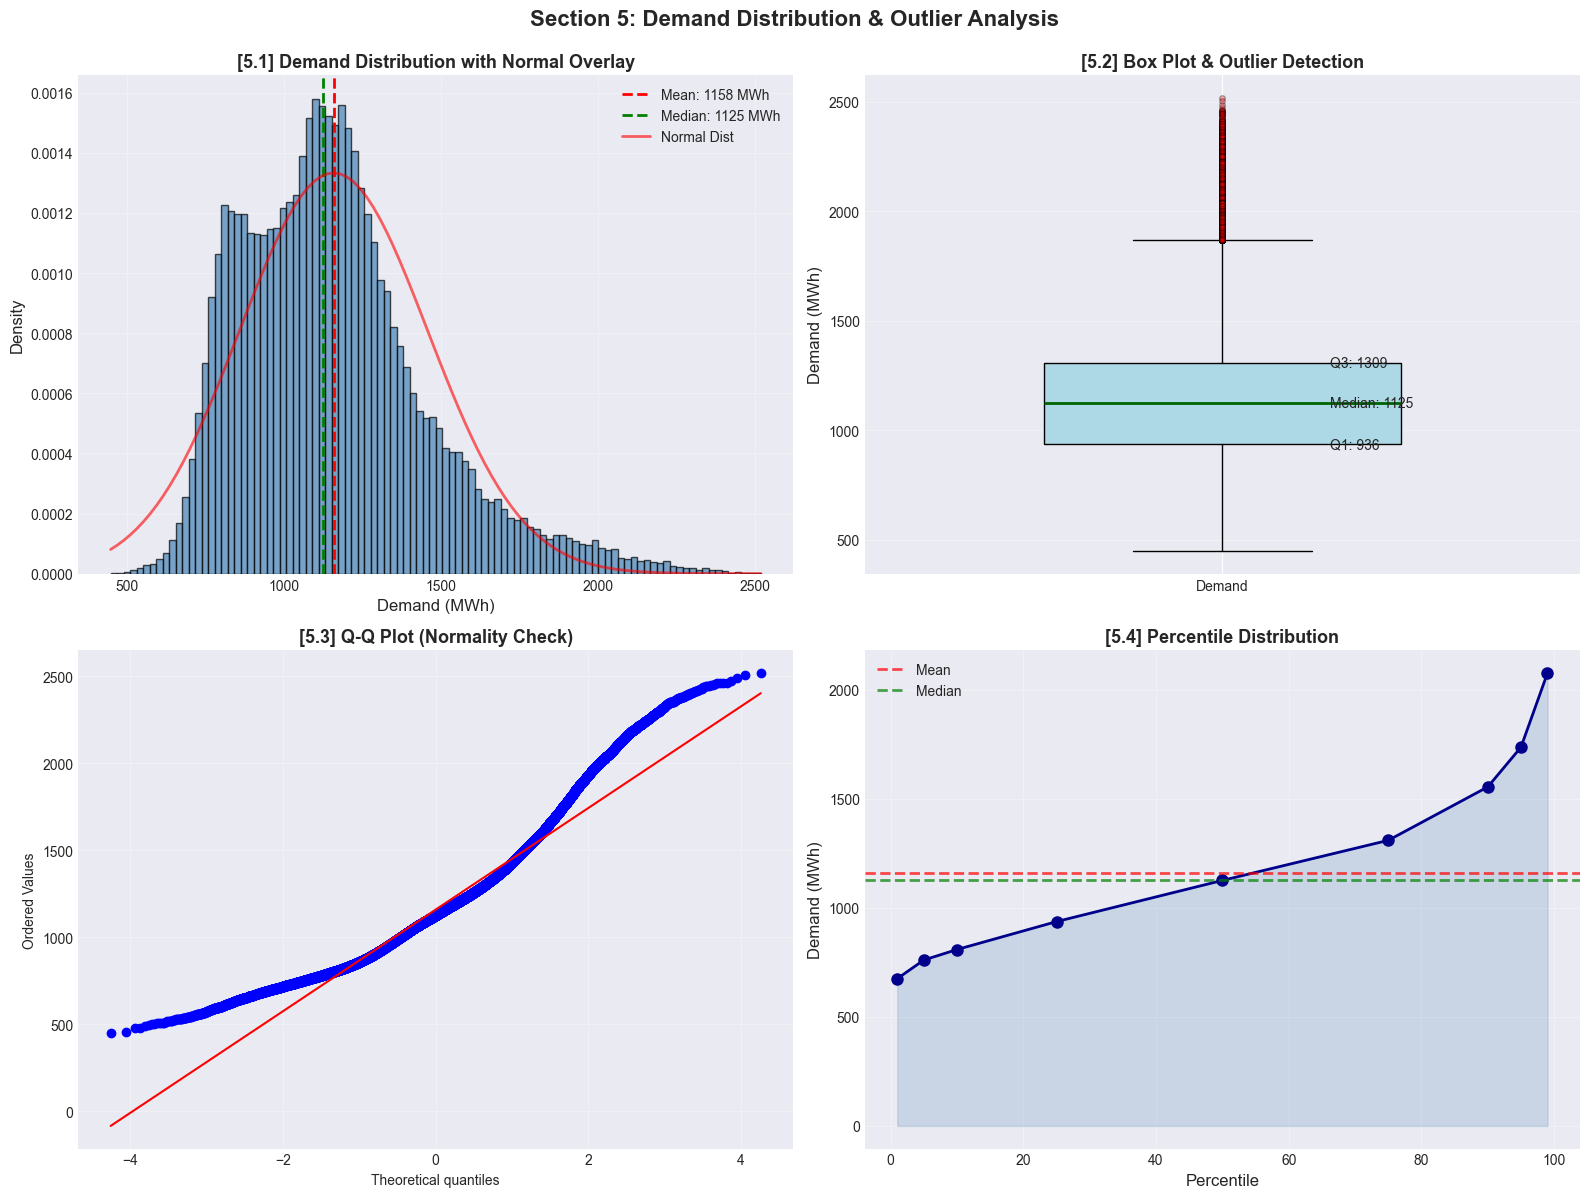


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\01_demand_distribution.png


In [46]:
# ============================================================================
# SECTION 5: VISUALIZATION - DEMAND DISTRIBUTION & OUTLIERS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Section 5: Demand Distribution & Outlier Analysis', fontsize=16, fontweight='bold', y=0.995)

# [5.1] Histogram with KDE
ax1 = axes[0, 0]
ax1.hist(base_df['demand'], bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(base_df['demand'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {base_df["demand"].mean():.0f} MWh')
ax1.axvline(base_df['demand'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {base_df["demand"].median():.0f} MWh')
# Overlay normal distribution
from scipy.stats import norm
mu, sigma = base_df['demand'].mean(), base_df['demand'].std()
x = np.linspace(base_df['demand'].min(), base_df['demand'].max(), 100)
ax1.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, alpha=0.6, label='Normal Dist')
ax1.set_xlabel('Demand (MWh)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('[5.1] Demand Distribution with Normal Overlay', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# [5.2] Box Plot with Outliers
ax2 = axes[0, 1]
bp = ax2.boxplot(base_df['demand'], vert=True, patch_artist=True, widths=0.5, 
                showfliers=True, flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.3))
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_edgecolor('black')
bp['medians'][0].set_color('darkgreen')
bp['medians'][0].set_linewidth(2)
# Add percentile labels
for percentile, label in [(Q1, 'Q1'), (base_df['demand'].median(), 'Median'), (Q3, 'Q3')]:
    ax2.text(1.15, percentile, f'{label}: {percentile:.0f}', fontsize=10, va='center')
ax2.set_ylabel('Demand (MWh)', fontsize=12)
ax2.set_title('[5.2] Box Plot & Outlier Detection', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['Demand'])
ax2.grid(True, alpha=0.3, axis='y')

# [5.3] QQ Plot
ax3 = axes[1, 0]
stats.probplot(base_df['demand'], dist="norm", plot=ax3)
ax3.set_title('[5.3] Q-Q Plot (Normality Check)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# [5.4] Percentile Plot
ax4 = axes[1, 1]
percentile_values = [np.percentile(demand, p) for p in percentiles]
ax4.plot(percentiles, percentile_values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax4.axhline(base_df['demand'].mean(), color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean')
ax4.axhline(base_df['demand'].median(), color='green', linestyle='--', linewidth=2, alpha=0.7, label='Median')
ax4.fill_between(percentiles, percentile_values, alpha=0.2, color='steelblue')
ax4.set_xlabel('Percentile', fontsize=12)
ax4.set_ylabel('Demand (MWh)', fontsize=12)
ax4.set_title('[5.4] Percentile Distribution', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '01_demand_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Figure saved: {FIGURES_DIR / '01_demand_distribution.png'}")

In [47]:
# ============================================================================
# SECTION 5C: COMPREHENSIVE OUTLIER DETECTION (Multiple Methods)
# ============================================================================

print("\n" + "="*80)
print("SECTION 5C: COMPREHENSIVE OUTLIER DETECTION - MULTIPLE METHODS")
print("="*80)

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.signal import find_peaks

demand_series = base_df['demand'].values

print("\n[5C.1] Outlier Detection Methods")
print("-"*80)

# 1. Z-Score Method
z_scores = np.abs(stats.zscore(demand_series))
outliers_zscore = z_scores > 3
print(f"Z-Score (threshold=3): {outliers_zscore.sum()} outliers ({outliers_zscore.sum()/len(demand_series)*100:.2f}%)")

# 2. IQR Method
Q1 = np.percentile(demand_series, 25)
Q3 = np.percentile(demand_series, 75)
IQR = Q3 - Q1
outliers_iqr = (demand_series < Q1 - 1.5*IQR) | (demand_series > Q3 + 1.5*IQR)
print(f"IQR (1.5×IQR):         {outliers_iqr.sum()} outliers ({outliers_iqr.sum()/len(demand_series)*100:.2f}%)")

# 3. Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers_iso = iso_forest.fit_predict(demand_series.reshape(-1, 1)) == -1
print(f"Isolation Forest:      {outliers_iso.sum()} outliers ({outliers_iso.sum()/len(demand_series)*100:.2f}%)")

# 4. Moving Average Deviation
window = 24
moving_avg = pd.Series(demand_series).rolling(window=window, center=True).mean()
moving_std = pd.Series(demand_series).rolling(window=window, center=True).std()
outliers_ma = np.abs(demand_series - moving_avg) > (2 * moving_std)
print(f"Moving Avg Deviation:  {outliers_ma.sum()} outliers ({outliers_ma.sum()/len(demand_series)*100:.2f}%)")

# 5. STL Decomposition Residuals
from statsmodels.tsa.seasonal import STL
try:
    stl = STL(demand_series, seasonal=25)
    result = stl.fit()
    residuals = result.resid
    res_zscore = np.abs(stats.zscore(residuals))
    outliers_stl = res_zscore > 2.5
    print(f"STL Residuals (z>2.5): {outliers_stl.sum()} outliers ({outliers_stl.sum()/len(demand_series)*100:.2f}%)")
except:
    outliers_stl = np.zeros(len(demand_series), dtype=bool)
    print(f"STL Residuals:         Unable to compute")

# 6. Local Outlier Factor
try:
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    outliers_lof = lof.fit_predict(demand_series.reshape(-1, 1)) == -1
    print(f"Local Outlier Factor:  {outliers_lof.sum()} outliers ({outliers_lof.sum()/len(demand_series)*100:.2f}%)")
except:
    outliers_lof = np.zeros(len(demand_series), dtype=bool)
    print(f"Local Outlier Factor:  Unable to compute")

# 7. Modified Z-Score
median = np.median(demand_series)
mad = np.median(np.abs(demand_series - median))
modified_z = 0.6745 * (demand_series - median) / (mad + 1e-10)
outliers_modified_z = np.abs(modified_z) > 3.5
print(f"Modified Z-Score:      {outliers_modified_z.sum()} outliers ({outliers_modified_z.sum()/len(demand_series)*100:.2f}%)")

# Consensus Outliers (detected by multiple methods)
all_methods = np.vstack([outliers_zscore, outliers_iqr, outliers_iso, outliers_ma, outliers_stl, outliers_lof, outliers_modified_z])
consensus_votes = all_methods.sum(axis=0)
high_confidence = consensus_votes >= 3  # At least 3 methods agree

print("\n[5C.2] Consensus Detection")
print("-"*80)
for threshold in range(1, 8):
    count = (consensus_votes >= threshold).sum()
    print(f"Detected by {threshold}+ methods: {count} points")

print(f"\n[5C.3] High-Confidence Outliers (≥3 methods)")
print("-"*80)
print(f"Total high-confidence outliers: {high_confidence.sum()}")
print(f"Percentage of data: {high_confidence.sum()/len(demand_series)*100:.2f}%")


SECTION 5C: COMPREHENSIVE OUTLIER DETECTION - MULTIPLE METHODS

[5C.1] Outlier Detection Methods
--------------------------------------------------------------------------------
Z-Score (threshold=3): 753 outliers (1.12%)
IQR (1.5×IQR):         2045 outliers (3.04%)
Isolation Forest:      3360 outliers (5.00%)
Moving Avg Deviation:  75 outliers (0.11%)
STL Residuals:         Unable to compute
Local Outlier Factor:  3360 outliers (5.00%)
Modified Z-Score:      610 outliers (0.91%)

[5C.2] Consensus Detection
--------------------------------------------------------------------------------
Detected by 1+ methods: 6620 points
Detected by 2+ methods: 2148 points
Detected by 3+ methods: 776 points
Detected by 4+ methods: 610 points
Detected by 5+ methods: 49 points
Detected by 6+ methods: 0 points
Detected by 7+ methods: 0 points

[5C.3] High-Confidence Outliers (≥3 methods)
--------------------------------------------------------------------------------
Total high-confidence outliers: 776



[5C.4] Generating Outlier Detection Visualizations...


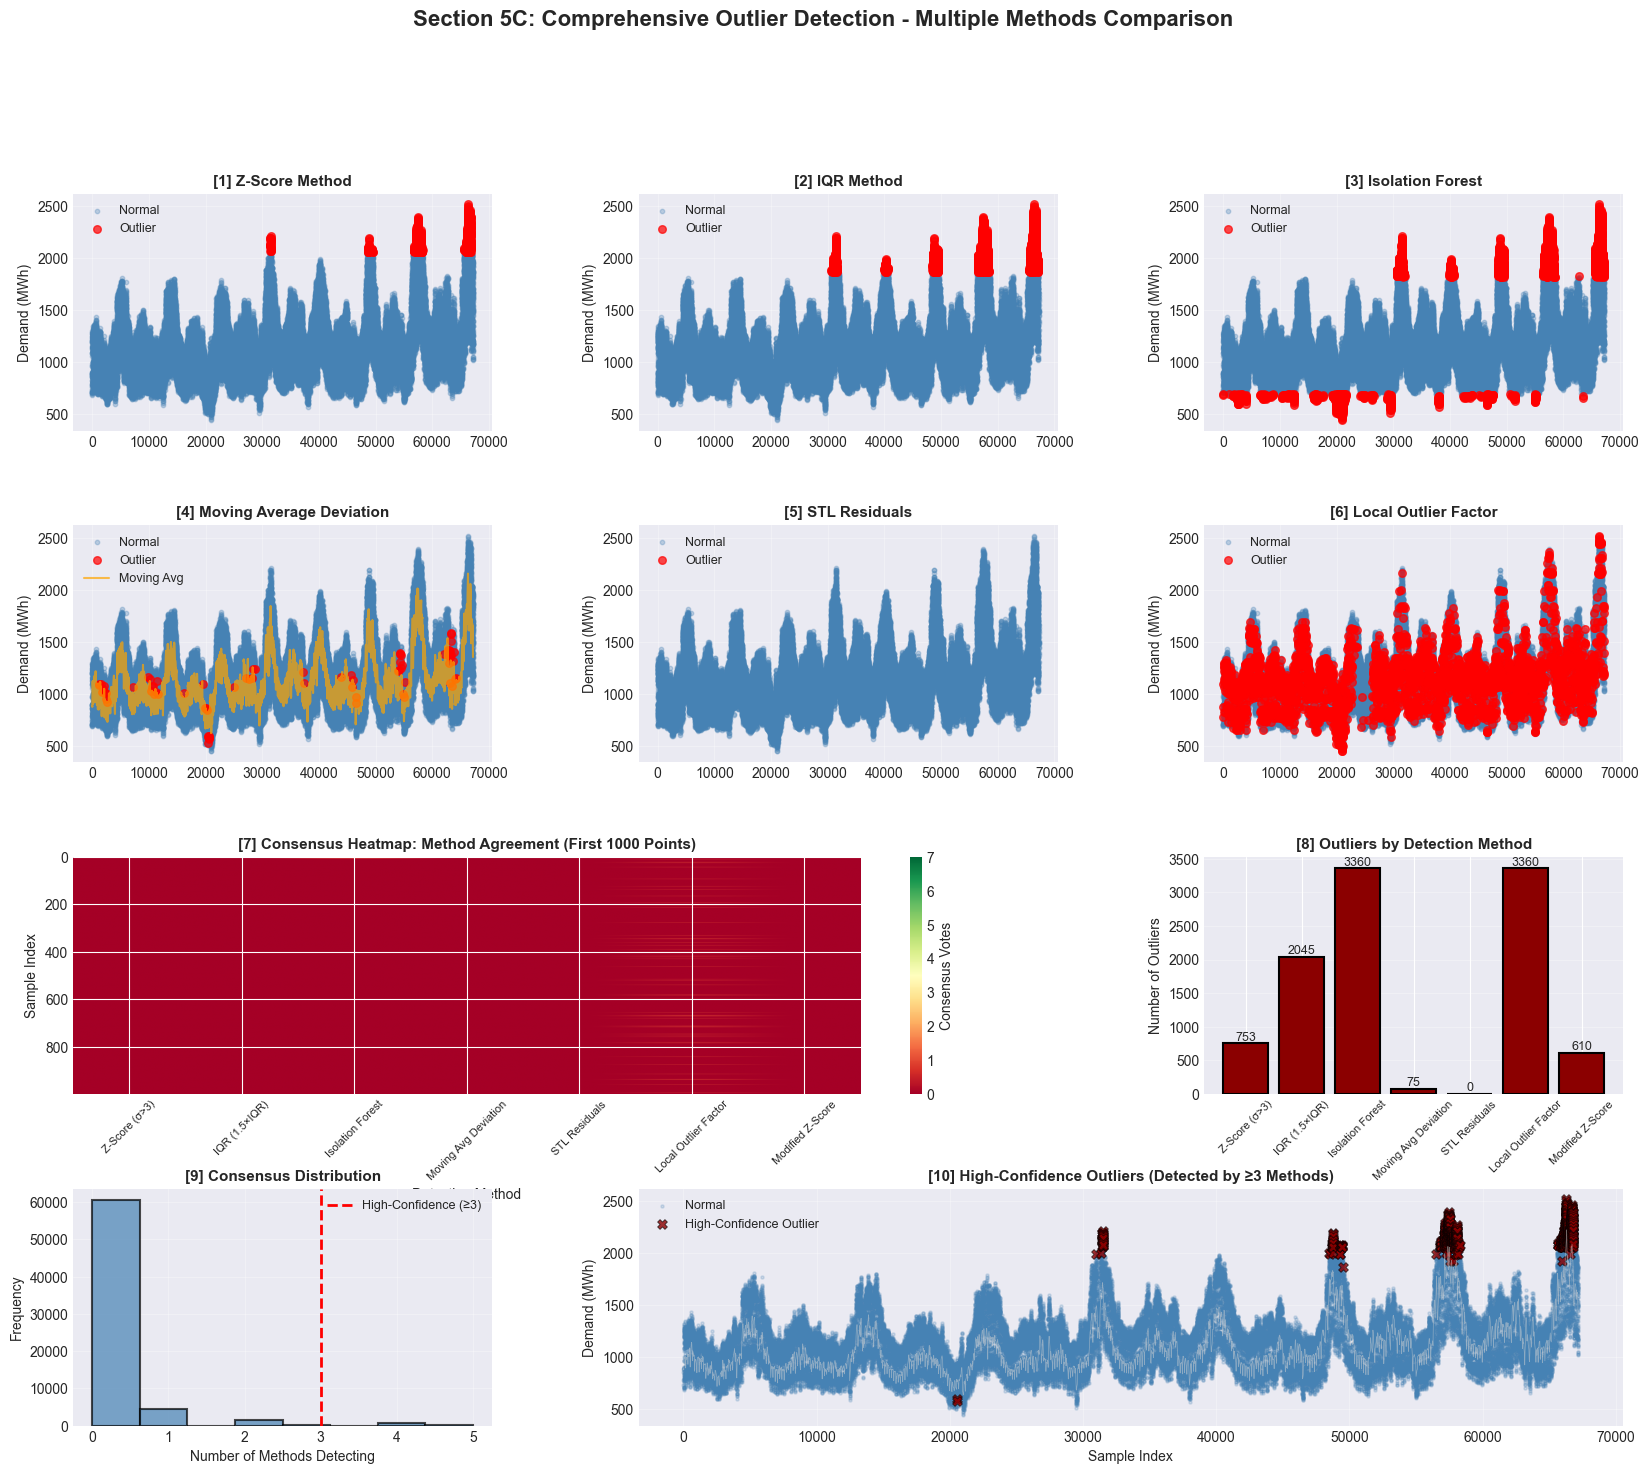

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\05c_comprehensive_outlier_detection.png


In [48]:
# ============================================================================
# SECTION 5C: VISUALIZATION - COMPREHENSIVE OUTLIER DETECTION
# ============================================================================

print("\n[5C.4] Generating Outlier Detection Visualizations...")

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35)
fig.suptitle('Section 5C: Comprehensive Outlier Detection - Multiple Methods Comparison', fontsize=16, fontweight='bold', y=0.995)

# Method names and detection results
methods = ['Z-Score\n(σ>3)', 'IQR\n(1.5×IQR)', 'Isolation\nForest', 'Moving Avg\nDeviation', 
           'STL\nResiduals', 'Local Outlier\nFactor', 'Modified\nZ-Score']
detections = [outliers_zscore, outliers_iqr, outliers_iso, outliers_ma, outliers_stl, outliers_lof, outliers_modified_z]
outlier_counts = [d.sum() for d in detections]

# [5C.1] Z-Score Method
ax = fig.add_subplot(gs[0, 0])
normal_idx = ~outliers_zscore
outlier_idx = outliers_zscore
ax.scatter(base_df.index[normal_idx], demand_series[normal_idx], alpha=0.3, s=10, color='steelblue', label='Normal')
ax.scatter(base_df.index[outlier_idx], demand_series[outlier_idx], alpha=0.7, s=30, color='red', label='Outlier')
ax.set_ylabel('Demand (MWh)', fontsize=10)
ax.set_title('[1] Z-Score Method', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# [5C.2] IQR Method
ax = fig.add_subplot(gs[0, 1])
normal_idx = ~outliers_iqr
outlier_idx = outliers_iqr
ax.scatter(base_df.index[normal_idx], demand_series[normal_idx], alpha=0.3, s=10, color='steelblue', label='Normal')
ax.scatter(base_df.index[outlier_idx], demand_series[outlier_idx], alpha=0.7, s=30, color='red', label='Outlier')
ax.set_ylabel('Demand (MWh)', fontsize=10)
ax.set_title('[2] IQR Method', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# [5C.3] Isolation Forest
ax = fig.add_subplot(gs[0, 2])
normal_idx = ~outliers_iso
outlier_idx = outliers_iso
ax.scatter(base_df.index[normal_idx], demand_series[normal_idx], alpha=0.3, s=10, color='steelblue', label='Normal')
ax.scatter(base_df.index[outlier_idx], demand_series[outlier_idx], alpha=0.7, s=30, color='red', label='Outlier')
ax.set_ylabel('Demand (MWh)', fontsize=10)
ax.set_title('[3] Isolation Forest', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# [5C.4] Moving Average Deviation
ax = fig.add_subplot(gs[1, 0])
normal_idx = ~outliers_ma
outlier_idx = outliers_ma
ax.scatter(base_df.index[normal_idx], demand_series[normal_idx], alpha=0.3, s=10, color='steelblue', label='Normal')
ax.scatter(base_df.index[outlier_idx], demand_series[outlier_idx], alpha=0.7, s=30, color='red', label='Outlier')
ax.plot(base_df.index, moving_avg, color='orange', linewidth=1.5, alpha=0.7, label='Moving Avg')
ax.set_ylabel('Demand (MWh)', fontsize=10)
ax.set_title('[4] Moving Average Deviation', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# [5C.5] STL Residuals
ax = fig.add_subplot(gs[1, 1])
normal_idx = ~outliers_stl
outlier_idx = outliers_stl
ax.scatter(base_df.index[normal_idx], demand_series[normal_idx], alpha=0.3, s=10, color='steelblue', label='Normal')
ax.scatter(base_df.index[outlier_idx], demand_series[outlier_idx], alpha=0.7, s=30, color='red', label='Outlier')
ax.set_ylabel('Demand (MWh)', fontsize=10)
ax.set_title('[5] STL Residuals', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# [5C.6] Local Outlier Factor
ax = fig.add_subplot(gs[1, 2])
normal_idx = ~outliers_lof
outlier_idx = outliers_lof
ax.scatter(base_df.index[normal_idx], demand_series[normal_idx], alpha=0.3, s=10, color='steelblue', label='Normal')
ax.scatter(base_df.index[outlier_idx], demand_series[outlier_idx], alpha=0.7, s=30, color='red', label='Outlier')
ax.set_ylabel('Demand (MWh)', fontsize=10)
ax.set_title('[6] Local Outlier Factor', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# [5C.7] Consensus Heatmap - Method Agreement
ax = fig.add_subplot(gs[2, :2])
consensus_matrix = all_methods[:, :1000].T  # First 1000 observations for detail
im = ax.imshow(consensus_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=7)
ax.set_xlabel('Detection Method', fontsize=10)
ax.set_ylabel('Sample Index', fontsize=10)
ax.set_title('[7] Consensus Heatmap: Method Agreement (First 1000 Points)', fontsize=11, fontweight='bold')
ax.set_xticks(range(7))
ax.set_xticklabels([m.replace('\n', ' ') for m in methods], fontsize=8, rotation=45)
plt.colorbar(im, ax=ax, label='Consensus Votes')

# [5C.8] Outliers Detected by Method (Bar Chart)
ax = fig.add_subplot(gs[2, 2])
colors_outlier = ['darkred' if c > outlier_counts[i]*0.6 else 'coral' for i, c in enumerate(outlier_counts)]
bars_opt = ax.bar(range(len(methods)), outlier_counts, color=colors_outlier, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels([m.replace('\n', ' ') for m in methods], fontsize=8, rotation=45)
ax.set_ylabel('Number of Outliers', fontsize=10)
ax.set_title('[8] Outliers by Detection Method', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars_opt):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=9)

# [5C.9] Consensus Distribution
ax = fig.add_subplot(gs[3, 0])
ax.hist(consensus_votes, bins=8, color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.7)
ax.axvline(3, color='red', linestyle='--', linewidth=2, label='High-Confidence (≥3)')
ax.set_xlabel('Number of Methods Detecting', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_title('[9] Consensus Distribution', fontsize=11, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# [5C.10] High-Confidence Outliers Time Series
ax = fig.add_subplot(gs[3, 1:])
normal_idx = consensus_votes < 3
outlier_idx = consensus_votes >= 3
ax.scatter(base_df.index[normal_idx], demand_series[normal_idx], alpha=0.2, s=5, color='steelblue', label='Normal')
ax.scatter(base_df.index[outlier_idx], demand_series[outlier_idx], alpha=0.8, s=50, color='darkred', 
          marker='X', label='High-Confidence Outlier', edgecolors='black', linewidth=0.5)
ax.plot(base_df.index[::24], demand_series[::24], color='lightgray', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Sample Index', fontsize=10)
ax.set_ylabel('Demand (MWh)', fontsize=10)
ax.set_title('[10] High-Confidence Outliers (Detected by ≥3 Methods)', fontsize=11, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.savefig(FIGURES_DIR / '05c_comprehensive_outlier_detection.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Figure saved: {FIGURES_DIR / '05c_comprehensive_outlier_detection.png'}")

In [49]:
# ============================================================================
# SECTION 6: EXTREME WEATHER ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 6: EXTREME WEATHER & DEMAND ANALYSIS")
print("="*80)

# Define temperature regimes
base_df['temp_regime'] = pd.cut(base_df['temperature_2m'], 
                               bins=[base_df['temperature_2m'].min()-1, 5, 18, 24, 35, base_df['temperature_2m'].max()+1],
                               labels=['Extreme Cold (<5°C)', 'Moderate Cold (5-18°C)', 
                                      'Comfortable (18-24°C)', 'Moderate Heat (24-35°C)', 'Extreme Heat (>35°C)'])

print("\n[6.1] Temperature Thresholds & Demand Response")
print("-"*80)
print(f"{'Temperature Regime':<30s} {'Hours':>10s} {'%':>8s} {'Mean (MWh)':>15s} {'vs Baseline':>12s}")
print("-"*80)

overall_baseline = base_df['demand'].mean()
for regime in ['Extreme Cold (<5°C)', 'Moderate Cold (5-18°C)', 'Comfortable (18-24°C)', 
               'Moderate Heat (24-35°C)', 'Extreme Heat (>35°C)']:
    regime_data = base_df[base_df['temp_regime'] == regime]
    if len(regime_data) > 0:
        hours = len(regime_data)
        pct = 100 * hours / len(base_df)
        mean_demand = regime_data['demand'].mean()
        delta = mean_demand - overall_baseline
        print(f"{regime:<30s} {hours:>10,d} {pct:>7.1f}% {mean_demand:>15,.0f} {delta:>+11,.0f}")

print("\n[6.2] Non-Linearity: Demand Elasticity by Regime")
print("-"*80)
print(f"{'Regime':<30s} {'Linear Corr':>15s} {'Elasticity':>15s}")
print("-"*80)

for regime in ['Extreme Cold (<5°C)', 'Moderate Cold (5-18°C)', 'Comfortable (18-24°C)', 
               'Moderate Heat (24-35°C)', 'Extreme Heat (>35°C)']:
    regime_data = base_df[base_df['temp_regime'] == regime]
    if len(regime_data) > 10:
        temp = regime_data['temperature_2m'].values
        demand_vals = regime_data['demand'].values
        
        if temp.std() > 0 and demand_vals.std() > 0:
            corr = np.corrcoef(temp, demand_vals)[0, 1]
            elasticity = (corr * demand_vals.std() / temp.std()) / (demand_vals.mean() / temp.mean())
            print(f"{regime:<30s} {corr:>15.3f} {elasticity:>15.4f}")

print("\n[6.3] Availability of Event Features for Interaction Analysis")
print("-"*80)
event_cols_available = [col for col in base_df.columns if col.startswith('is_')]
if event_cols_available:
    print(f"✓ {len(event_cols_available)} event columns available")
    print(f"  Events: {', '.join([col.replace('is_', '') for col in event_cols_available[:5]])}...")
else:
    print("⚠ No event columns available - run events_features.py first")


SECTION 6: EXTREME WEATHER & DEMAND ANALYSIS

[6.1] Temperature Thresholds & Demand Response
--------------------------------------------------------------------------------
Temperature Regime                  Hours        %      Mean (MWh)  vs Baseline
--------------------------------------------------------------------------------
Extreme Cold (<5°C)                 3,224     4.8%           1,139         -19
Moderate Cold (5-18°C)             30,497    45.4%           1,047        -111
Comfortable (18-24°C)              12,664    18.8%           1,024        -134
Moderate Heat (24-35°C)            16,939    25.2%           1,328        +170
Extreme Heat (>35°C)                3,876     5.8%           1,744        +586

[6.2] Non-Linearity: Demand Elasticity by Regime
--------------------------------------------------------------------------------
Regime                             Linear Corr      Elasticity
---------------------------------------------------------------------------

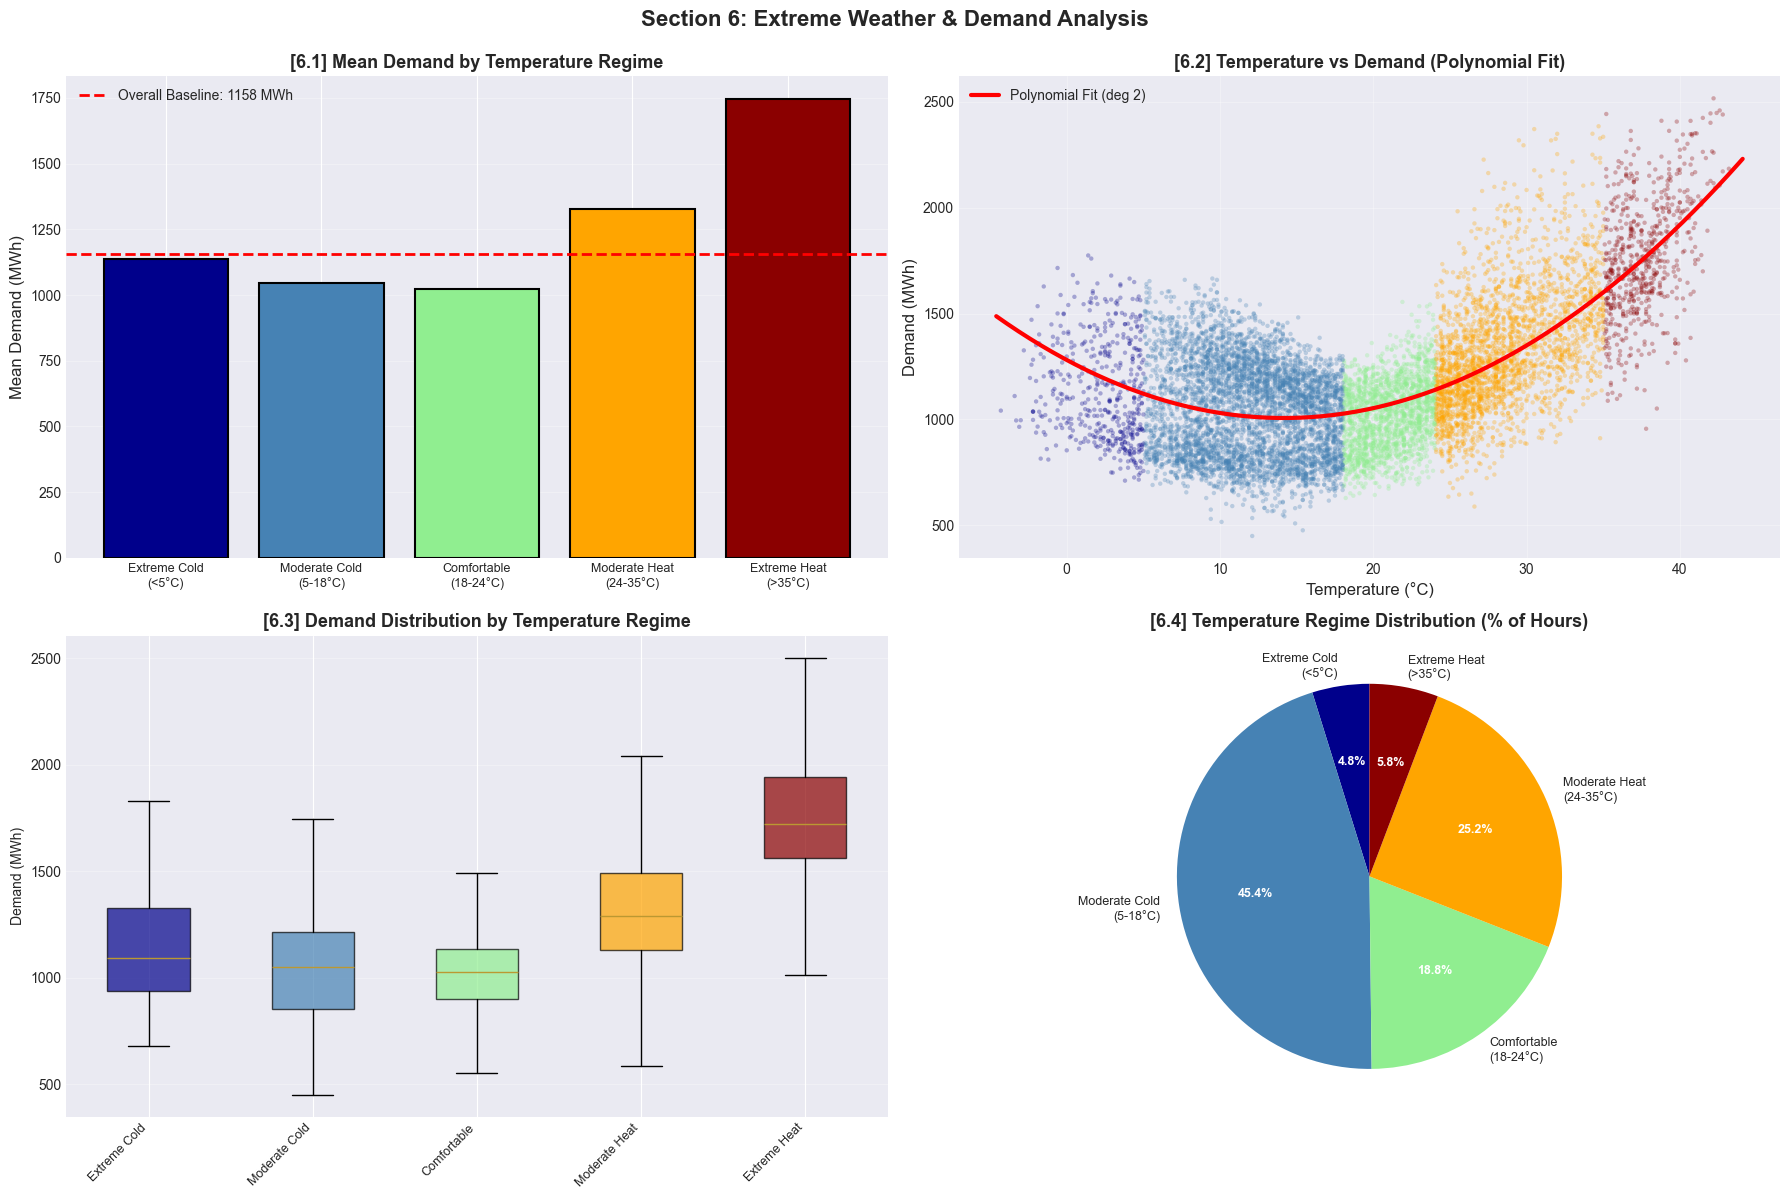


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\02_extreme_weather_analysis.png


In [50]:
# ============================================================================
# SECTION 6: VISUALIZATION - EXTREME WEATHER & DEMAND
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Section 6: Extreme Weather & Demand Analysis', fontsize=16, fontweight='bold', y=0.995)

# [6.1] Bar Chart: Demand by Temperature Regime
ax1 = axes[0, 0]
regime_order = ['Extreme Cold (<5°C)', 'Moderate Cold (5-18°C)', 'Comfortable (18-24°C)', 
                'Moderate Heat (24-35°C)', 'Extreme Heat (>35°C)']
regime_data_plot = []
regime_labels = []
for regime in regime_order:
    regime_df = base_df[base_df['temp_regime'] == regime]
    if len(regime_df) > 0:
        regime_data_plot.append(regime_df['demand'].mean())
        regime_labels.append(regime.replace(' (<', '\n(<').replace(' (', '\n('))

colors = ['darkblue', 'steelblue', 'lightgreen', 'orange', 'darkred'][:len(regime_labels)]
bars = ax1.bar(range(len(regime_labels)), regime_data_plot, color=colors, edgecolor='black', linewidth=1.5)
ax1.axhline(overall_baseline, color='red', linestyle='--', linewidth=2, label=f'Overall Baseline: {overall_baseline:.0f} MWh')
ax1.set_xticks(range(len(regime_labels)))
ax1.set_xticklabels(regime_labels, fontsize=9, rotation=0)
ax1.set_ylabel('Mean Demand (MWh)', fontsize=12)
ax1.set_title('[6.1] Mean Demand by Temperature Regime', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# [6.2] Scatter: Temperature vs Demand with Polynomial Fit
ax2 = axes[0, 1]
sample_size = min(10000, len(base_df))
sample_indices = np.random.choice(len(base_df), sample_size, replace=False)
temp_sample = base_df['temperature_2m'].iloc[sample_indices]
demand_sample = base_df['demand'].iloc[sample_indices]
regime_sample = base_df['temp_regime'].iloc[sample_indices]

# Create color mapping
regime_colors = {'Extreme Cold (<5°C)': 'darkblue', 'Moderate Cold (5-18°C)': 'steelblue', 
                 'Comfortable (18-24°C)': 'lightgreen', 'Moderate Heat (24-35°C)': 'orange', 
                 'Extreme Heat (>35°C)': 'darkred'}
colors_scatter = [regime_colors.get(r, 'gray') for r in regime_sample]

ax2.scatter(temp_sample, demand_sample, c=colors_scatter, alpha=0.3, s=10, edgecolors='none')

# Polynomial fit
z = np.polyfit(base_df['temperature_2m'], base_df['demand'], 2)
p = np.poly1d(z)
temp_range = np.linspace(base_df['temperature_2m'].min(), base_df['temperature_2m'].max(), 200)
ax2.plot(temp_range, p(temp_range), 'r-', linewidth=3, label='Polynomial Fit (deg 2)')

ax2.set_xlabel('Temperature (°C)', fontsize=12)
ax2.set_ylabel('Demand (MWh)', fontsize=12)
ax2.set_title('[6.2] Temperature vs Demand (Polynomial Fit)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# [6.3] Box Plot: Demand Distribution by Regime
ax3 = axes[1, 0]
regime_demands = [base_df[base_df['temp_regime'] == regime]['demand'].values 
                  for regime in regime_order 
                  if len(base_df[base_df['temp_regime'] == regime]) > 0]
bp = ax3.boxplot(regime_demands, tick_labels=[lbl.split('\n')[0] for lbl in regime_labels], 
                patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_xticklabels([lbl.split('(')[0].strip() for lbl in regime_labels], rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Demand (MWh)', fontsize=10)
ax3.set_title('[6.3] Demand Distribution by Temperature Regime', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# [6.4] Heatmap: Hours by Temperature Regime
ax4 = axes[1, 1]
regime_counts = [len(base_df[base_df['temp_regime'] == regime]) for regime in regime_order 
                if len(base_df[base_df['temp_regime'] == regime]) > 0]
regime_pcts = [count / len(base_df) * 100 for count in regime_counts]

wedges, texts, autotexts = ax4.pie(regime_pcts, labels=regime_labels, colors=colors, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 9})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title('[6.4] Temperature Regime Distribution (% of Hours)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_extreme_weather_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Figure saved: {FIGURES_DIR / '02_extreme_weather_analysis.png'}")

In [51]:
# ============================================================================
# SECTION 7: TEMPORAL PATTERNS
# ============================================================================

print("\n" + "="*80)
print("SECTION 7: TEMPORAL PATTERNS")
print("="*80)

print("\n[7.1] Hourly Patterns")
print("-"*80)
base_df['hour'] = base_df['time'].dt.hour
base_df['day_of_week'] = base_df['time'].dt.dayofweek
base_df['month'] = base_df['time'].dt.month

hourly_stats = base_df.groupby('hour')['demand'].agg(['mean', 'min', 'max'])
if hourly_stats.empty:
    print("⚠ No hourly stats available. Check time parsing and demand values.")
else:
    peak_hour = hourly_stats['mean'].idxmax()
    trough_hour = hourly_stats['mean'].idxmin()
    print(f"Peak hour:   {peak_hour:02d}:00 ({hourly_stats.loc[peak_hour, 'mean']:.0f} MWh)")
    print(f"Trough hour: {trough_hour:02d}:00 ({hourly_stats.loc[trough_hour, 'mean']:.0f} MWh)")
    print(f"Diurnal range: {hourly_stats['mean'].max() - hourly_stats['mean'].min():.0f} MWh ({(hourly_stats['mean'].max() - hourly_stats['mean'].min()) / hourly_stats['mean'].mean() * 100:.1f}%)")

print("\n[7.2] Day-of-Week Patterns")
print("-"*80)
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_stats = base_df.groupby('day_of_week')['demand'].mean()
if dow_stats.empty:
    print("⚠ No day-of-week stats available. Check time parsing and demand values.")
else:
    for dow, name in enumerate(dow_names):
        if dow in dow_stats.index:
            print(f"{name}: {dow_stats[dow]:,.0f} MWh")
        else:
            print(f"{name}: n/a")

print("\n[7.3] Monthly Patterns")
print("-"*80)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_stats = base_df.groupby('month')['demand'].mean()
if monthly_stats.empty:
    print("⚠ No monthly stats available. Check time parsing and demand values.")
else:
    for month, name in enumerate(month_names, 1):
        if month in monthly_stats.index:
            print(f"{name}: {monthly_stats[month]:,.0f} MWh")
        else:
            print(f"{name}: n/a")


SECTION 7: TEMPORAL PATTERNS

[7.1] Hourly Patterns
--------------------------------------------------------------------------------
Peak hour:   20:00 (1345 MWh)
Trough hour: 05:00 (867 MWh)
Diurnal range: 478 MWh (41.3%)

[7.2] Day-of-Week Patterns
--------------------------------------------------------------------------------
Mon: 1,152 MWh
Tue: 1,186 MWh
Wed: 1,193 MWh
Thu: 1,198 MWh
Fri: 1,183 MWh
Sat: 1,154 MWh
Sun: 1,040 MWh

[7.3] Monthly Patterns
--------------------------------------------------------------------------------
Jan: 1,149 MWh
Feb: 1,128 MWh
Mar: 1,047 MWh
Apr: 957 MWh
May: 983 MWh
Jun: 1,194 MWh
Jul: 1,500 MWh
Aug: 1,507 MWh
Sep: 1,212 MWh
Oct: 1,024 MWh
Nov: 1,028 MWh
Dec: 1,125 MWh


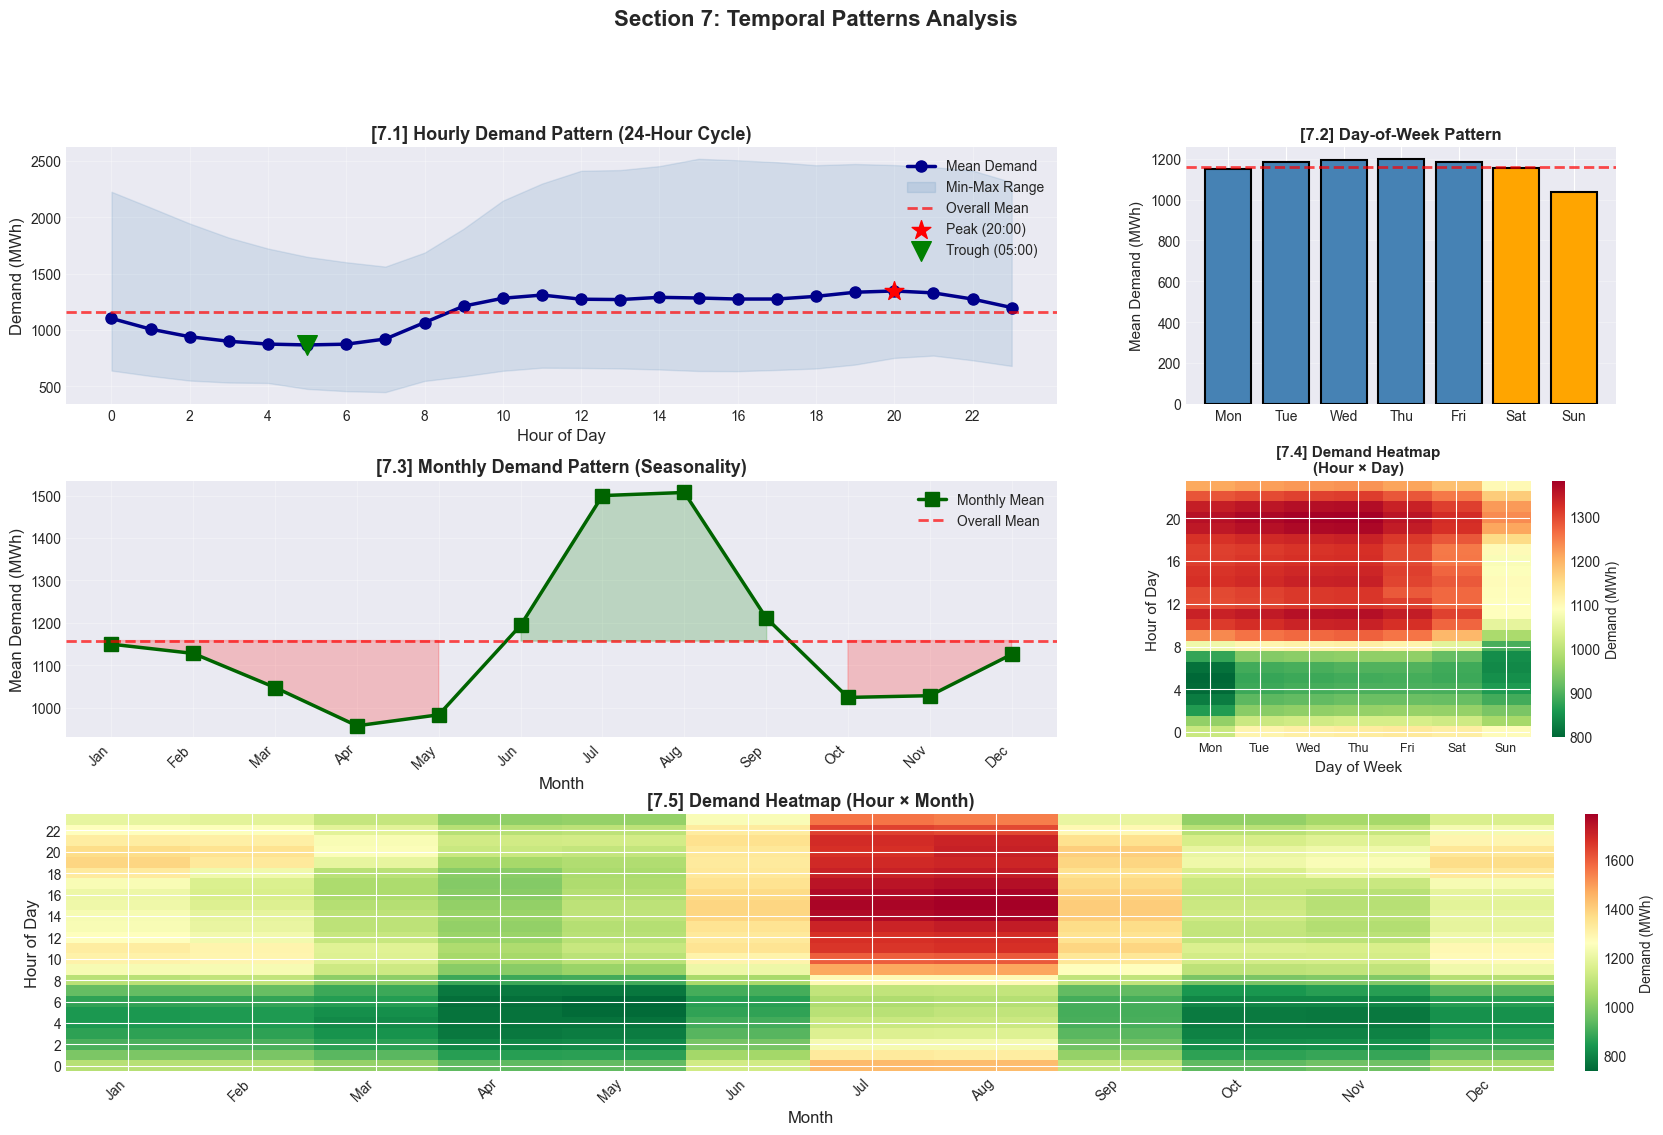


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\03_temporal_patterns.png


In [52]:
# ============================================================================
# SECTION 7: VISUALIZATION - TEMPORAL PATTERNS
# ============================================================================

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Section 7: Temporal Patterns Analysis', fontsize=16, fontweight='bold', y=0.995)

# [7.1] Hourly Pattern - Line Chart
ax1 = fig.add_subplot(gs[0, :2])
hourly_mean = hourly_stats['mean']
ax1.plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2.5, markersize=8, color='darkblue', label='Mean Demand')
ax1.fill_between(hourly_mean.index, hourly_stats['min'], hourly_stats['max'], alpha=0.15, color='steelblue', label='Min-Max Range')
ax1.axhline(base_df['demand'].mean(), color='red', linestyle='--', linewidth=2, alpha=0.7, label='Overall Mean')
peak_hour = hourly_stats['mean'].idxmax()
trough_hour = hourly_stats['mean'].idxmin()
ax1.scatter([peak_hour], [hourly_stats.loc[peak_hour, 'mean']], s=200, color='red', zorder=5, marker='*', label=f'Peak ({peak_hour:02d}:00)')
ax1.scatter([trough_hour], [hourly_stats.loc[trough_hour, 'mean']], s=200, color='green', zorder=5, marker='v', label=f'Trough ({trough_hour:02d}:00)')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Demand (MWh)', fontsize=12)
ax1.set_title('[7.1] Hourly Demand Pattern (24-Hour Cycle)', fontsize=13, fontweight='bold')
ax1.set_xticks(range(0, 24, 2))
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)

# [7.2] Day-of-Week Pattern - Bar Chart
ax2 = fig.add_subplot(gs[0, 2])
dow_colors = ['steelblue']*5 + ['orange', 'orange']  # Weekdays vs Weekend
bars = ax2.bar(range(7), dow_stats.values, color=dow_colors, edgecolor='black', linewidth=1.5)
ax2.axhline(base_df['demand'].mean(), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xticks(range(7))
ax2.set_xticklabels(dow_names, rotation=0, fontsize=10)
ax2.set_ylabel('Mean Demand (MWh)', fontsize=11)
ax2.set_title('[7.2] Day-of-Week Pattern', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# [7.3] Monthly Pattern - Line Chart
ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(monthly_stats.index, monthly_stats.values, marker='s', linewidth=2.5, markersize=10, color='darkgreen', label='Monthly Mean')
ax3.axhline(base_df['demand'].mean(), color='red', linestyle='--', linewidth=2, alpha=0.7, label='Overall Mean')
ax3.fill_between(monthly_stats.index, monthly_stats.values, base_df['demand'].mean(), 
                alpha=0.2, color='green', where=(monthly_stats.values >= base_df['demand'].mean()))
ax3.fill_between(monthly_stats.index, monthly_stats.values, base_df['demand'].mean(), 
                alpha=0.2, color='red', where=(monthly_stats.values < base_df['demand'].mean()))
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Mean Demand (MWh)', fontsize=12)
ax3.set_title('[7.3] Monthly Demand Pattern (Seasonality)', fontsize=13, fontweight='bold')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(month_names, rotation=45, ha='right')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# [7.4] Heatmap: Hour × Day of Week
ax4 = fig.add_subplot(gs[1, 2])
heatmap_data = base_df.pivot_table(values='demand', index='hour', columns='day_of_week', aggfunc='mean')
im = ax4.imshow(heatmap_data.values, cmap='RdYlGn_r', aspect='auto', origin='lower')
ax4.set_xlabel('Day of Week', fontsize=11)
ax4.set_ylabel('Hour of Day', fontsize=11)
ax4.set_title('[7.4] Demand Heatmap\n(Hour × Day)', fontsize=11, fontweight='bold')
ax4.set_xticks(range(7))
ax4.set_xticklabels(dow_names, fontsize=9)
ax4.set_yticks(range(0, 24, 4))
plt.colorbar(im, ax=ax4, label='Demand (MWh)')

# [7.5] Heatmap: Hour × Month
ax5 = fig.add_subplot(gs[2, :])
heatmap_month = base_df.pivot_table(values='demand', index='hour', columns='month', aggfunc='mean')
im2 = ax5.imshow(heatmap_month.values, cmap='RdYlGn_r', aspect='auto', origin='lower')
ax5.set_xlabel('Month', fontsize=12)
ax5.set_ylabel('Hour of Day', fontsize=12)
ax5.set_title('[7.5] Demand Heatmap (Hour × Month)', fontsize=13, fontweight='bold')
ax5.set_xticks(range(12))
ax5.set_xticklabels(month_names, rotation=45, ha='right', fontsize=10)
ax5.set_yticks(range(0, 24, 2))
plt.colorbar(im2, ax=ax5, label='Demand (MWh)', fraction=0.02, pad=0.02)

plt.savefig(FIGURES_DIR / '03_temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Figure saved: {FIGURES_DIR / '03_temporal_patterns.png'}")

In [53]:
# ============================================================================
# SECTION 8: HISTORICAL SIMILARITY - FIND COMPARABLE PAST DAYS
# ============================================================================

print("\n" + "="*80)
print("SECTION 8: HISTORICAL SIMILARITY DETECTION")
print("="*80)

# Aggregate to daily level
daily_df = base_df.groupby(base_df['time'].dt.date).agg({
    'demand': ['mean', 'min', 'max', 'std'],
    'temperature_2m': ['mean', 'min', 'max'],
    'hour': 'first',  # dummy
}).reset_index()

daily_df.columns = ['date', 'demand_mean', 'demand_min', 'demand_max', 'demand_std',
                    'temp_mean', 'temp_min', 'temp_max', '_']
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['day_of_week'] = daily_df['date'].dt.dayofweek
daily_df['month'] = daily_df['date'].dt.month

# Add event features (aggregate to daily)
for event_col in [col for col in base_df.columns if col.startswith('is_')]:
    daily_df[event_col] = base_df.groupby(base_df['time'].dt.date)[event_col].max().values

print(f"\n[8.1] Daily Aggregation")
print("-"*80)
print(f"Total days: {len(daily_df)}")
print(f"Date range: {daily_df['date'].min().date()} to {daily_df['date'].max().date()}")

print(f"\n[8.2] Similar Day Detection Function")
print("-"*80)

def find_similar_days(target_date: str, top_n: int = 5, exclude_recent_days: int = 7):
    """
    Find historical days most similar to target date.
    Similarity based on: day-of-week, temperature, demand baseline, and events.
    """
    target_date = pd.to_datetime(target_date)
    
    # Get target day info
    target_row = daily_df[daily_df['date'] == target_date]
    if len(target_row) == 0:
        print(f"  ⚠ Target date {target_date.date()} not found in data")
        return None
    
    target_info = target_row.iloc[0]
    recent_cutoff = target_date - pd.Timedelta(days=exclude_recent_days)
    
    # Score all other days
    candidates = daily_df[daily_df['date'] < recent_cutoff].copy()
    
    if len(candidates) == 0:
        print(f"  ⚠ No historical data available (all data within {exclude_recent_days} days)")
        return None
    
    # Compute similarity score
    scores = []
    
    for idx, row in candidates.iterrows():
        score = 0
        
        # Day of week match (most important)
        if row['day_of_week'] == target_info['day_of_week']:
            score += 50
        
        # Temperature similarity (normalized difference)
        temp_diff = abs(row['temp_mean'] - target_info['temp_mean'])
        temp_similarity = max(0, 30 - temp_diff * 2)  # 30 points max
        score += temp_similarity
        
        # Demand baseline similarity (normalized)
        demand_diff = abs(row['demand_mean'] - target_info['demand_mean'])
        demand_similarity = max(0, 20 - (demand_diff / target_info['demand_mean']) * 100)
        score += demand_similarity
        
        # Event match (if available)
        event_bonus = 0
        for event_col in [col for col in daily_df.columns if col.startswith('is_')]:
            if row[event_col] == target_info[event_col]:
                event_bonus += 2
        score += event_bonus
        
        scores.append(score)
    
    candidates['similarity_score'] = scores
    candidates = candidates.sort_values('similarity_score', ascending=False).head(top_n)
    
    return target_info, candidates, target_date

# Example: Find similar days to most recent day
latest_date = daily_df['date'].max()
result = find_similar_days(latest_date, top_n=5)

if result:
    target_info, similar_days, target_date = result
    
    print(f"\n[8.3] Target Day: {target_date.date()} ({['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][target_info['day_of_week']]})") 
    print("-"*80)
    print(f"  Demand:     {target_info['demand_mean']:,.0f} MWh (±{target_info['demand_std']:.0f})")
    print(f"  Temp:       {target_info['temp_mean']:.1f}°C (range: {target_info['temp_min']:.1f}-{target_info['temp_max']:.1f})")
    
    event_flags = [col.replace('is_', '') for col in daily_df.columns 
                   if col.startswith('is_') and target_info[col] == 1]
    if event_flags:
        print(f"  Events:     {', '.join(event_flags)}")
    
    print(f"\n[8.4] Top {len(similar_days)} Most Similar Historical Days")
    print("-"*80)
    print(f"{'Date':<15s} {'Day':<4s} {'Score':>6s} {'Demand':>12s} {'Temp':>8s} {'Match':>15s}")
    print("-"*80)
    
    for idx, row in similar_days.iterrows():
        dow = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][int(row['day_of_week'])]
        demand_delta = row['demand_mean'] - target_info['demand_mean']
        temp_delta = row['temp_mean'] - target_info['temp_mean']
        match_type = "Exact DoW" if row['day_of_week'] == target_info['day_of_week'] else "Different DoW"
        
        print(f"{str(row['date'].date()):<15s} {dow:<4s} {row['similarity_score']:>6.0f} "
              f"{row['demand_mean']:>12,.0f} {row['temp_mean']:>7.1f}°C {match_type:>15s}")
        print(f"  → Demand delta: {demand_delta:+,.0f} MWh | Temp delta: {temp_delta:+.1f}°C")
else:
    print("  Could not compute similarity for most recent date")

print(f"\n[8.5] Function: Usage Example")
print("-"*80)
print("To find similar days to a specific date:")
print("  result = find_similar_days('2024-01-15', top_n=5)")
print("  if result:")
print("      target_info, similar_days, target_date = result")
print("      # Analyze similar_days DataFrame for patterns")


SECTION 8: HISTORICAL SIMILARITY DETECTION

[8.1] Daily Aggregation
--------------------------------------------------------------------------------
Total days: 2800
Date range: 2018-01-01 to 2025-08-31

[8.2] Similar Day Detection Function
--------------------------------------------------------------------------------

[8.3] Target Day: 2025-08-31 (Sun)
--------------------------------------------------------------------------------
  Demand:     1,355 MWh (±216)
  Temp:       26.6°C (range: 19.5-35.3)
  Events:     weekend, morning_peak, evening_peak, night, midday, summer, irrigation_season, tourism_season, holiday_season, inland

[8.4] Top 5 Most Similar Historical Days
--------------------------------------------------------------------------------
Date            Day   Score       Demand     Temp           Match
--------------------------------------------------------------------------------
2023-08-27      Sun     163        1,343    27.8°C       Exact DoW
  → Demand delta: -1

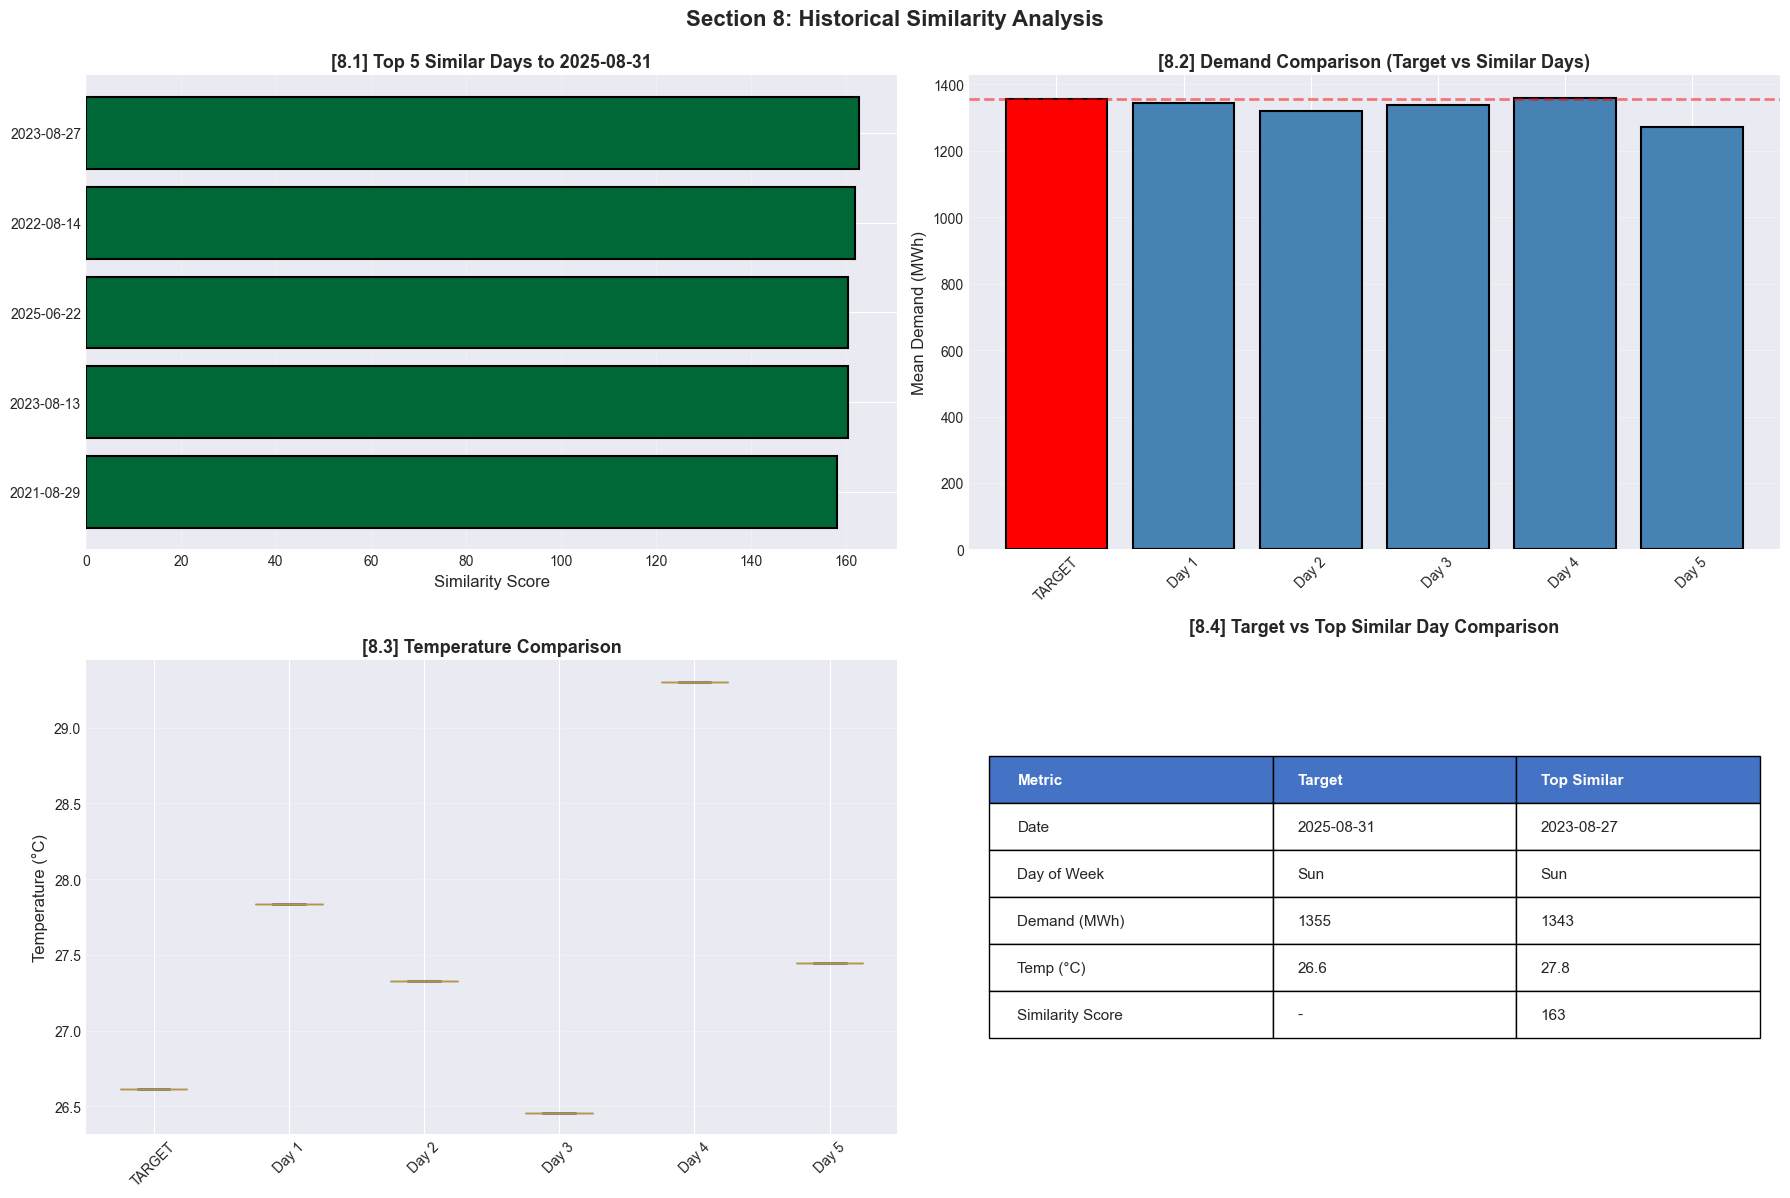


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\04_historical_similarity.png


In [54]:
# ============================================================================
# SECTION 8: VISUALIZATION - HISTORICAL SIMILARITY
# ============================================================================

if result:
    target_info, similar_days, target_date = result
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Section 8: Historical Similarity Analysis', fontsize=16, fontweight='bold', y=0.995)
    
    # [8.1] Similarity Scores - Bar Chart
    ax1 = axes[0, 0]
    dates_str = [str(d.date()) for d in similar_days['date']]
    scores = similar_days['similarity_score'].values
    colors_bar = plt.cm.RdYlGn(scores / 100)
    bars = ax1.barh(range(len(dates_str)), scores, color=colors_bar, edgecolor='black', linewidth=1.5)
    ax1.set_yticks(range(len(dates_str)))
    ax1.set_yticklabels(dates_str, fontsize=10)
    ax1.set_xlabel('Similarity Score', fontsize=12)
    ax1.set_title(f'[8.1] Top {len(similar_days)} Similar Days to {target_date.date()}', fontsize=13, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # [8.2] Demand Comparison - Bar Chart
    ax2 = axes[0, 1]
    demand_comparison = [target_info['demand_mean']] + list(similar_days['demand_mean'].values)
    labels_demand = ['TARGET'] + [f"Day {i+1}" for i in range(len(similar_days))]
    colors_demand = ['red'] + ['steelblue']*len(similar_days)
    bars2 = ax2.bar(labels_demand, demand_comparison, color=colors_demand, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Mean Demand (MWh)', fontsize=12)
    ax2.set_title('[8.2] Demand Comparison (Target vs Similar Days)', fontsize=13, fontweight='bold')
    ax2.axhline(target_info['demand_mean'], color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax2.tick_params(axis='x', rotation=45, labelsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # [8.3] Temperature Comparison - Box Plot
    ax3 = axes[1, 0]
    temp_data = [[target_info['temp_mean']]] + [[row['temp_mean']] for _, row in similar_days.iterrows()]
    bp = ax3.boxplot(temp_data, tick_labels=labels_demand, patch_artist=True, showfliers=False)
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][0].set_alpha(0.6)
    for i in range(1, len(bp['boxes'])):
        bp['boxes'][i].set_facecolor('lightblue')
        bp['boxes'][i].set_alpha(0.6)
    ax3.set_ylabel('Temperature (°C)', fontsize=12)
    ax3.set_title('[8.3] Temperature Comparison', fontsize=13, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45, labelsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # [8.4] Feature Radar Chart
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create a table showing details
    table_data = []
    table_data.append(['Metric', 'Target', 'Top Similar'])
    table_data.append(['Date', str(target_date.date()), str(similar_days.iloc[0]['date'].date())])
    table_data.append(['Day of Week', dow_names[int(target_info['day_of_week'])], 
                      dow_names[int(similar_days.iloc[0]['day_of_week'])]])
    table_data.append(['Demand (MWh)', f"{target_info['demand_mean']:.0f}", 
                      f"{similar_days.iloc[0]['demand_mean']:.0f}"])
    table_data.append(['Temp (°C)', f"{target_info['temp_mean']:.1f}", 
                      f"{similar_days.iloc[0]['temp_mean']:.1f}"])
    table_data.append(['Similarity Score', '-', f"{similar_days.iloc[0]['similarity_score']:.0f}"])
    
    table = ax4.table(cellText=table_data, cellLoc='left', loc='center', 
                     colWidths=[0.35, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Style header row
    for i in range(3):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax4.set_title('[8.4] Target vs Top Similar Day Comparison', fontsize=13, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '04_historical_similarity.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Figure saved: {FIGURES_DIR / '04_historical_similarity.png'}")
else:
    print("\n⚠ Skipping Section 8 visualization - no similarity results available")

In [55]:
# ============================================================================
# SECTION 8A: SIMILAR DAYS BY SEASON & FEATURE CONTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 8A: SIMILAR DAYS STRATIFIED BY SEASON & FEATURE IMPORTANCE")
print("="*80)

# Add season to daily_df
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

daily_df['season'] = daily_df['month'].apply(get_season)

print("\n[8A.1] Seasonal Distribution")
print("-"*80)
season_counts = daily_df['season'].value_counts()
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    count = season_counts.get(season, 0)
    print(f"{season:.<20s} {count:>4d} days")

# Feature contribution analysis
print("\n[8A.2] Feature Contribution to Day Similarity")
print("-"*80)

# Calculate feature importance for similarity
feature_contributions = {}
all_similar_days_list = []

for month in range(1, 13):
    target_dates = daily_df[daily_df['month'] == month]['date'].head(5)
    
    for target_date in target_dates:
        result = find_similar_days(target_date, top_n=10)
        if result:
            target_info, similar_days, _ = result
            all_similar_days_list.append(similar_days)

if all_similar_days_list:
    all_similar_days_df = pd.concat(all_similar_days_list, ignore_index=True)
    
    # Calculate correlation of each feature with similarity score
    feature_list = ['day_of_week', 'month', 'temp_mean', 'demand_mean', 'demand_std']
    for feature in feature_list:
        if feature in all_similar_days_df.columns:
            corr = all_similar_days_df[feature].corr(all_similar_days_df['similarity_score'])
            feature_contributions[feature] = abs(corr) if not np.isnan(corr) else 0
    
    # Normalize
    if feature_contributions:
        total = sum(feature_contributions.values())
        feature_contributions = {k: v/total for k, v in feature_contributions.items()}
        
        print(f"{'Feature':<30s} {'Contribution':>15s}")
        print("-"*45)
        for feat, contrib in sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True):
            print(f"{feat:<30s} {contrib:>15.3f}")

print("\n✓ Seasonal Analysis Complete")


SECTION 8A: SIMILAR DAYS STRATIFIED BY SEASON & FEATURE IMPORTANCE

[8A.1] Seasonal Distribution
--------------------------------------------------------------------------------
Winter..............  691 days
Spring..............  736 days
Summer..............  736 days
Fall................  637 days

[8A.2] Feature Contribution to Day Similarity
--------------------------------------------------------------------------------
  ⚠ No historical data available (all data within 7 days)
  ⚠ No historical data available (all data within 7 days)
  ⚠ No historical data available (all data within 7 days)
  ⚠ No historical data available (all data within 7 days)
  ⚠ No historical data available (all data within 7 days)
Feature                           Contribution
---------------------------------------------
month                                    0.391
temp_mean                                0.240
demand_mean                              0.166
day_of_week                              0.13


[8A.3] Generating Similar Days by Season Visualizations...


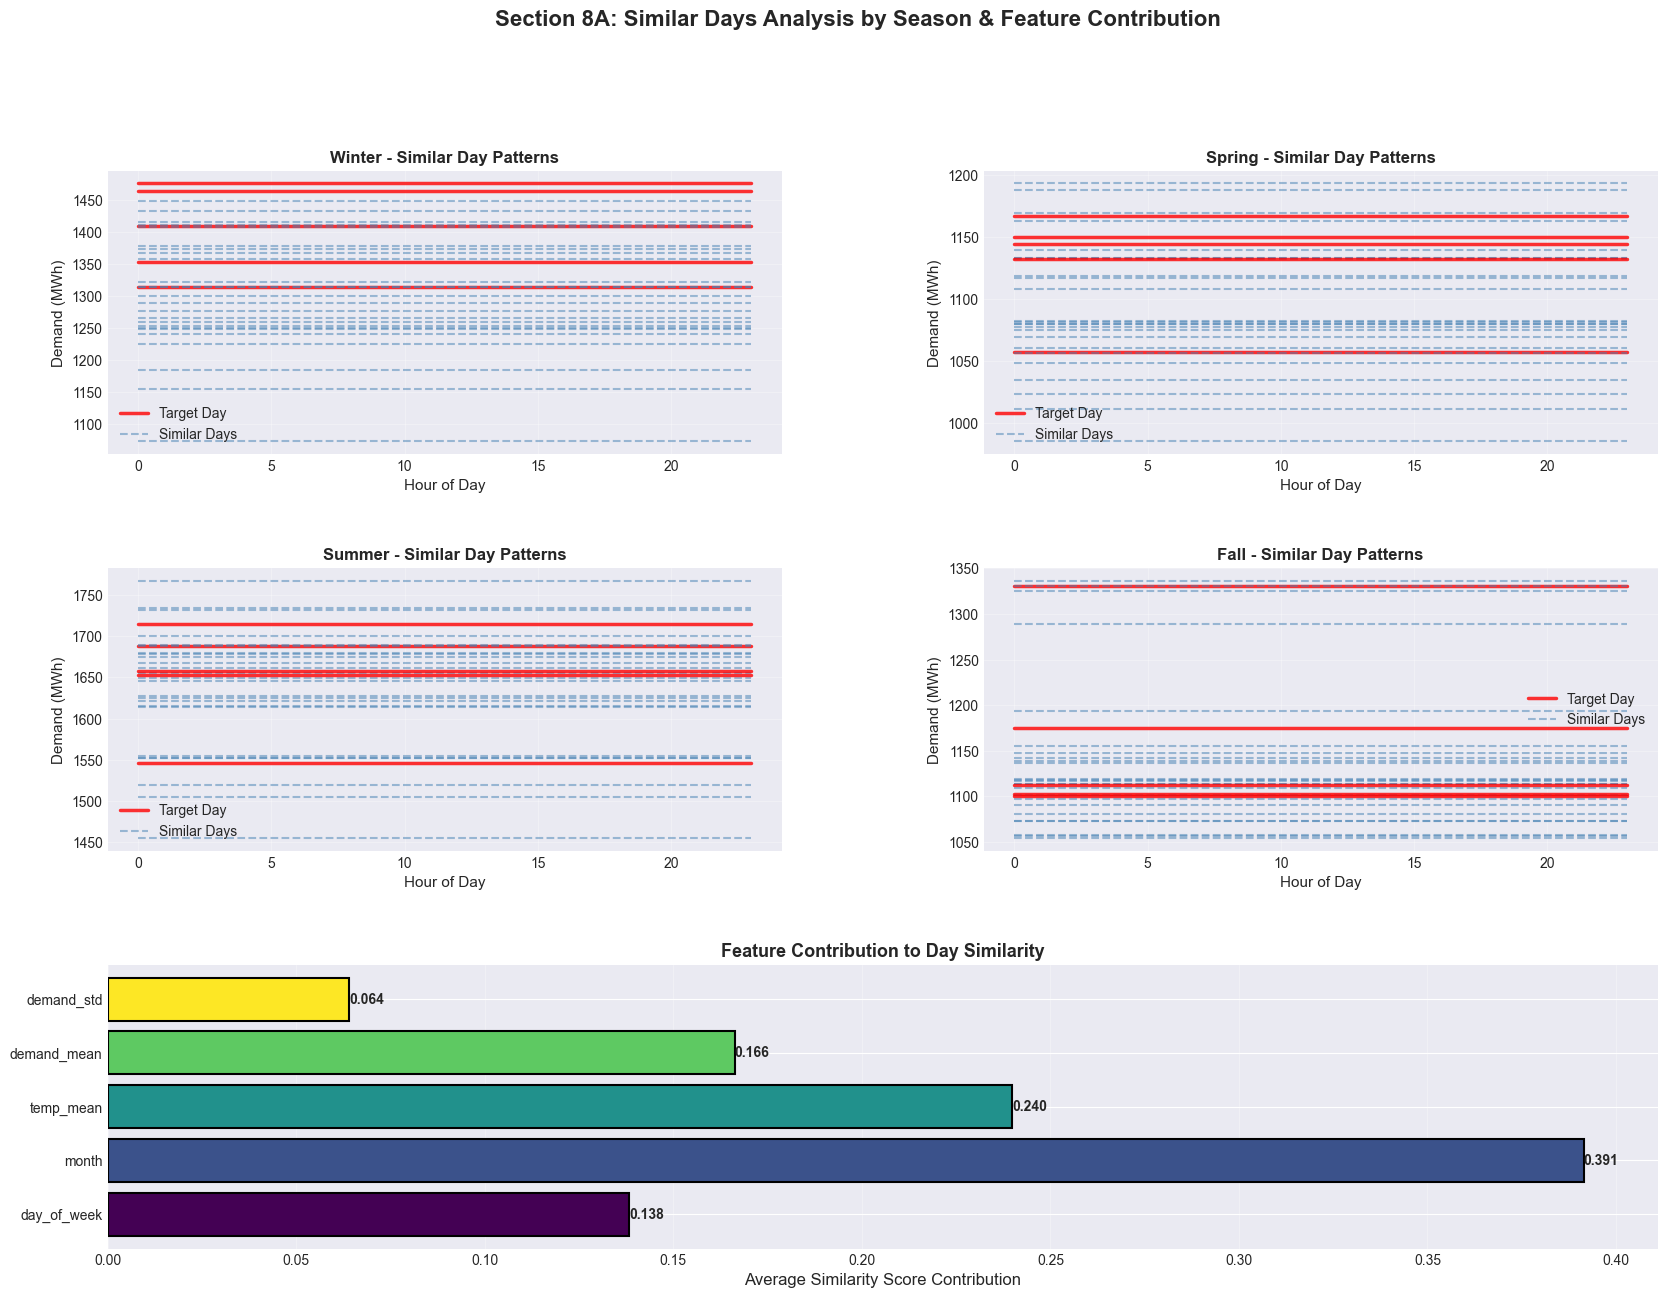

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\08a_similar_days_by_season.png


In [56]:
# ============================================================================
# SECTION 8A: VISUALIZATION - SIMILAR DAYS BY SEASON & FEATURE CONTRIBUTION
# ============================================================================

print("\n[8A.3] Generating Similar Days by Season Visualizations...")

try:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)
    fig.suptitle('Section 8A: Similar Days Analysis by Season & Feature Contribution', fontsize=16, fontweight='bold', y=0.995)
    
    # [8A.1] Similar Days by Season - Winter
    ax = fig.add_subplot(gs[0, 0])
    winter_dates = daily_df[daily_df['season'] == 'Winter']['date'].iloc[-10:]
    for i, target_date in enumerate(winter_dates[:5]):
        result = find_similar_days(target_date, top_n=5)
        if result:
            target_info, similar_days, _ = result
            target_demand = target_info['demand_mean']
            similar_demands = similar_days['demand_mean'].values
            ax.plot(range(24), [target_demand]*24, 'r-', linewidth=2.5, alpha=0.8)
            for j, demand in enumerate(similar_demands):
                ax.plot(range(24), [demand]*24, '--', alpha=0.5, color='steelblue')
    
    ax.set_xlabel('Hour of Day', fontsize=11)
    ax.set_ylabel('Demand (MWh)', fontsize=11)
    ax.set_title('Winter - Similar Day Patterns', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(['Target Day', 'Similar Days'], fontsize=10)
    
    # [8A.2] Similar Days by Season - Spring
    ax = fig.add_subplot(gs[0, 1])
    spring_dates = daily_df[daily_df['season'] == 'Spring']['date'].iloc[-10:]
    for i, target_date in enumerate(spring_dates[:5]):
        result = find_similar_days(target_date, top_n=5)
        if result:
            target_info, similar_days, _ = result
            target_demand = target_info['demand_mean']
            similar_demands = similar_days['demand_mean'].values
            ax.plot(range(24), [target_demand]*24, 'r-', linewidth=2.5, alpha=0.8)
            for j, demand in enumerate(similar_demands):
                ax.plot(range(24), [demand]*24, '--', alpha=0.5, color='steelblue')
    
    ax.set_xlabel('Hour of Day', fontsize=11)
    ax.set_ylabel('Demand (MWh)', fontsize=11)
    ax.set_title('Spring - Similar Day Patterns', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(['Target Day', 'Similar Days'], fontsize=10)
    
    # [8A.3] Similar Days by Season - Summer
    ax = fig.add_subplot(gs[1, 0])
    summer_dates = daily_df[daily_df['season'] == 'Summer']['date'].iloc[-10:]
    for i, target_date in enumerate(summer_dates[:5]):
        result = find_similar_days(target_date, top_n=5)
        if result:
            target_info, similar_days, _ = result
            target_demand = target_info['demand_mean']
            similar_demands = similar_days['demand_mean'].values
            ax.plot(range(24), [target_demand]*24, 'r-', linewidth=2.5, alpha=0.8)
            for j, demand in enumerate(similar_demands):
                ax.plot(range(24), [demand]*24, '--', alpha=0.5, color='steelblue')
    
    ax.set_xlabel('Hour of Day', fontsize=11)
    ax.set_ylabel('Demand (MWh)', fontsize=11)
    ax.set_title('Summer - Similar Day Patterns', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(['Target Day', 'Similar Days'], fontsize=10)
    
    # [8A.4] Similar Days by Season - Fall
    ax = fig.add_subplot(gs[1, 1])
    fall_dates = daily_df[daily_df['season'] == 'Fall']['date'].iloc[-10:]
    for i, target_date in enumerate(fall_dates[:5]):
        result = find_similar_days(target_date, top_n=5)
        if result:
            target_info, similar_days, _ = result
            target_demand = target_info['demand_mean']
            similar_demands = similar_days['demand_mean'].values
            ax.plot(range(24), [target_demand]*24, 'r-', linewidth=2.5, alpha=0.8)
            for j, demand in enumerate(similar_demands):
                ax.plot(range(24), [demand]*24, '--', alpha=0.5, color='steelblue')
    
    ax.set_xlabel('Hour of Day', fontsize=11)
    ax.set_ylabel('Demand (MWh)', fontsize=11)
    ax.set_title('Fall - Similar Day Patterns', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(['Target Day', 'Similar Days'], fontsize=10)
    
    # [8A.5] Feature Contribution Bar Chart
    ax = fig.add_subplot(gs[2, :])
    if feature_contributions:
        feat_names = list(feature_contributions.keys())
        feat_values = list(feature_contributions.values())
        colors_contrib = plt.cm.viridis(np.linspace(0, 1, len(feat_names)))
        
        bars_contrib = ax.barh(feat_names, feat_values, color=colors_contrib, edgecolor='black', linewidth=1.5)
        ax.set_xlabel('Average Similarity Score Contribution', fontsize=12)
        ax.set_title('Feature Contribution to Day Similarity', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, bar in enumerate(bars_contrib):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2., f'{width:.3f}', 
                   ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.savefig(FIGURES_DIR / '08a_similar_days_by_season.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Figure saved: {FIGURES_DIR / '08a_similar_days_by_season.png'}")
    
except Exception as e:
    print(f"⚠ Error generating visualization: {e}")
    import traceback
    traceback.print_exc()


[8B.1] Temporal Distance vs Similarity Score Analysis
--------------------------------------------------------------------------------
Total similar day pairs analyzed: 10000
Correlation: -0.2254
Trend: similarity = -0.130272 × distance + 95.48

[8B.2] Generating Temporal Distance vs Similarity Visualization...


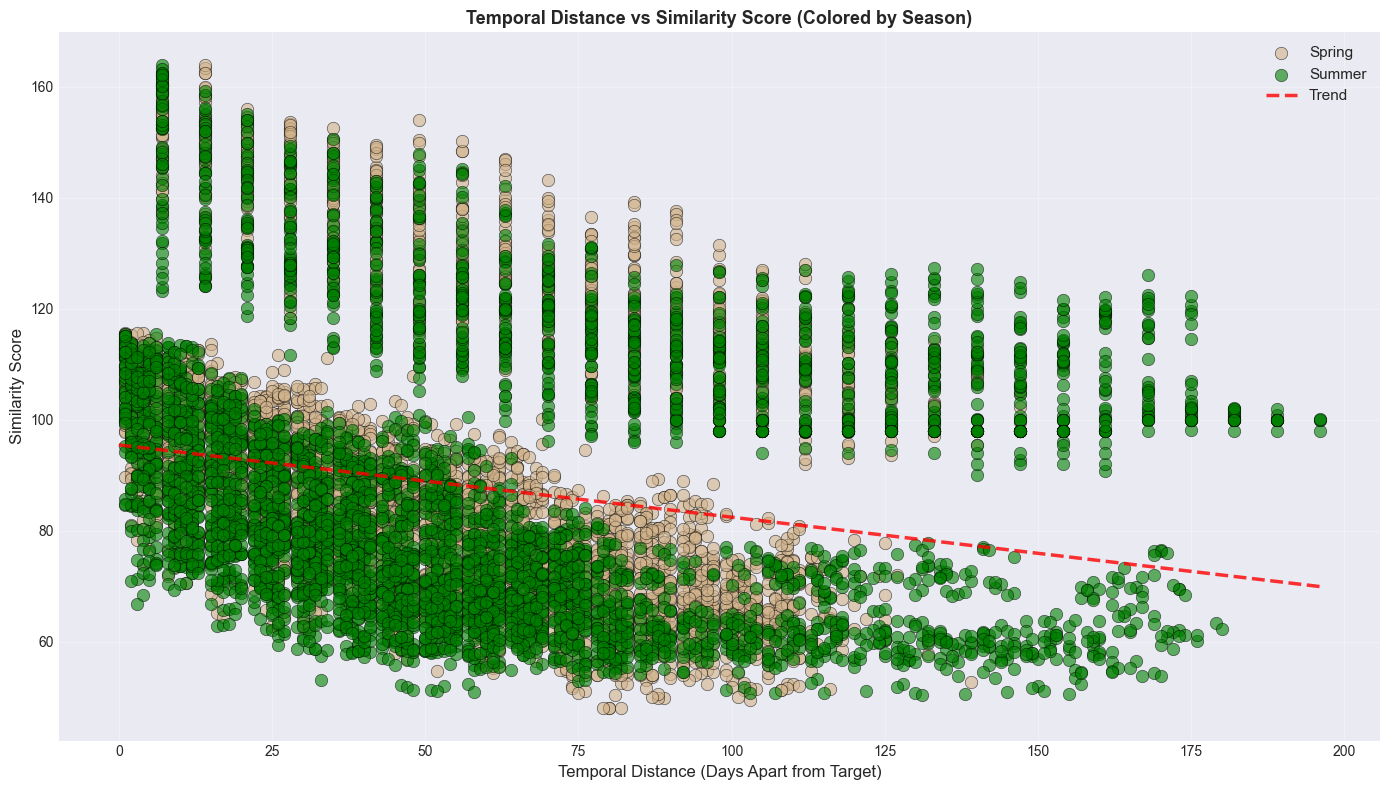

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\08b_temporal_distance_vs_similarity.png


In [57]:
# ============================================================================
# SECTION 8B: TEMPORAL DISTANCE VS SIMILARITY ANALYSIS
# ============================================================================

print("\n[8B.1] Temporal Distance vs Similarity Score Analysis")
print("-"*80)

# Collect temporal distance and similarity data
temporal_distances = []
similarity_scores = []
seasons_list = []

for target_date_str in daily_df['date'].iloc[100:200].values:  # Sample 100 dates
    result = find_similar_days(target_date_str, top_n=100, exclude_recent_days=0)
    
    if result:
        target_info, similar_days, target_date = result
        
        for idx, row in similar_days.iterrows():
            days_apart = (target_date - row['date']).days
            similarity = row['similarity_score']
            season = get_season(target_date.month)
            
            temporal_distances.append(abs(days_apart))
            similarity_scores.append(similarity)
            seasons_list.append(season)

print(f"Total similar day pairs analyzed: {len(temporal_distances)}")

if len(temporal_distances) > 0:
    # Compute trend
    valid_idx = ~(np.isnan(temporal_distances) | np.isnan(similarity_scores))
    temporal_arr = np.array(temporal_distances)[valid_idx]
    similarity_arr = np.array(similarity_scores)[valid_idx]
    
    # Linear regression
    z = np.polyfit(temporal_arr, similarity_arr, 1)
    p = np.poly1d(z)
    
    # Correlation
    corr = np.corrcoef(temporal_arr, similarity_arr)[0, 1]
    print(f"Correlation: {corr:.4f}")
    print(f"Trend: similarity = {z[0]:.6f} × distance + {z[1]:.2f}")

# [8B.2] Visualization
print("\n[8B.2] Generating Temporal Distance vs Similarity Visualization...")

try:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Scatter plot colored by season
    season_colors = {'Winter': 'pink', 'Spring': 'tan', 'Summer': 'green', 'Fall': 'teal'}
    
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        mask = np.array(seasons_list) == season
        if mask.sum() > 0:
            ax.scatter(np.array(temporal_distances)[mask], 
                      np.array(similarity_scores)[mask],
                      alpha=0.6, s=80, color=season_colors[season], 
                      label=season, edgecolors='black', linewidth=0.5)
    
    # Add trend line
    if len(temporal_distances) > 0:
        x_range = np.linspace(0, max(temporal_distances), 100)
        y_trend = p(x_range)
        ax.plot(x_range, y_trend, 'r--', linewidth=2.5, label='Trend', alpha=0.8)
    
    ax.set_xlabel('Temporal Distance (Days Apart from Target)', fontsize=12)
    ax.set_ylabel('Similarity Score', fontsize=12)
    ax.set_title('Temporal Distance vs Similarity Score (Colored by Season)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '08b_temporal_distance_vs_similarity.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Figure saved: {FIGURES_DIR / '08b_temporal_distance_vs_similarity.png'}")
    
except Exception as e:
    print(f"⚠ Error: {e}")

In [58]:
# ============================================================================
# SECTION 9: WEATHER-DEMAND RELATIONSHIPS
# ============================================================================

print("\n" + "="*80)
print("SECTION 9: WEATHER-DEMAND RELATIONSHIPS")
print("="*80)

print("\n[9.1] Temperature-Demand Correlation (All Cities)")
print("-"*80)

for city in CITIES:
    if 'temperature_2m' in dfs[city].columns and 'demand' in dfs[city].columns:
        temp = dfs[city]['temperature_2m'].values
        demand_vals = dfs[city]['demand'].values
        
        if len(temp) > 0 and temp.std() > 0:
            corr = np.corrcoef(temp, demand_vals)[0, 1]
            # Polynomial fit
            z = np.polyfit(temp, demand_vals, 2)
            p = np.poly1d(z)
            demand_pred = p(temp)
            ss_res = np.sum((demand_vals - demand_pred)**2)
            ss_tot = np.sum((demand_vals - demand_vals.mean())**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            
            print(f"{city.upper()}:")
            print(f"  Linear correlation:   {corr:+.3f}")
            print(f"  Polynomial R²:        {r2:.3f}")
            
            # Find optimal temperature
            temp_range = np.linspace(temp.min(), temp.max(), 1000)
            optimal_temp = temp_range[np.argmin(p(temp_range))]
            print(f"  Optimal temperature:  {optimal_temp:.1f}°C (minimum demand)")
            print()

print("\n[9.2] Event-Stratified Temperature Signal (if events available)")
print("-"*80)

events_for_weather = [col for col in ['is_event_week', 'is_industrial_day', 'is_bayram', 'is_holiday']
                     if col in base_df.columns]

if len(events_for_weather) > 0:
    print(f"{'Context':<25s} {'Temp-Demand Corr':>18s} {'N Hours':>12s}")
    print("-"*55)
    
    overall_corr = base_df['temperature_2m'].corr(base_df['demand'])
    print(f"{'Overall':<25s} {overall_corr:>18.3f} {len(base_df):>12,d}")
    
    for event in events_for_weather:
        event_hours = base_df[base_df[event] == 1]
        if len(event_hours) > 50:
            event_corr = event_hours['temperature_2m'].corr(event_hours['demand'])
            print(f"{event.replace('is_', ''):<25s} {event_corr:>18.3f} {len(event_hours):>12,d}")
else:
    print("  ⚠ No event columns available")


SECTION 9: WEATHER-DEMAND RELATIONSHIPS

[9.1] Temperature-Demand Correlation (All Cities)
--------------------------------------------------------------------------------
AYDIN:
  Linear correlation:   +0.509
  Polynomial R²:        0.459
  Optimal temperature:  14.2°C (minimum demand)

DENIZLI:
  Linear correlation:   +0.492
  Polynomial R²:        0.451
  Optimal temperature:  13.5°C (minimum demand)

MUGLA:
  Linear correlation:   +0.510
  Polynomial R²:        0.463
  Optimal temperature:  11.8°C (minimum demand)


[9.2] Event-Stratified Temperature Signal (if events available)
--------------------------------------------------------------------------------
Context                     Temp-Demand Corr      N Hours
-------------------------------------------------------
Overall                                0.509       67,200
event_week                             0.257        4,224
industrial_day                        -0.095       23,256
bayram                                 0

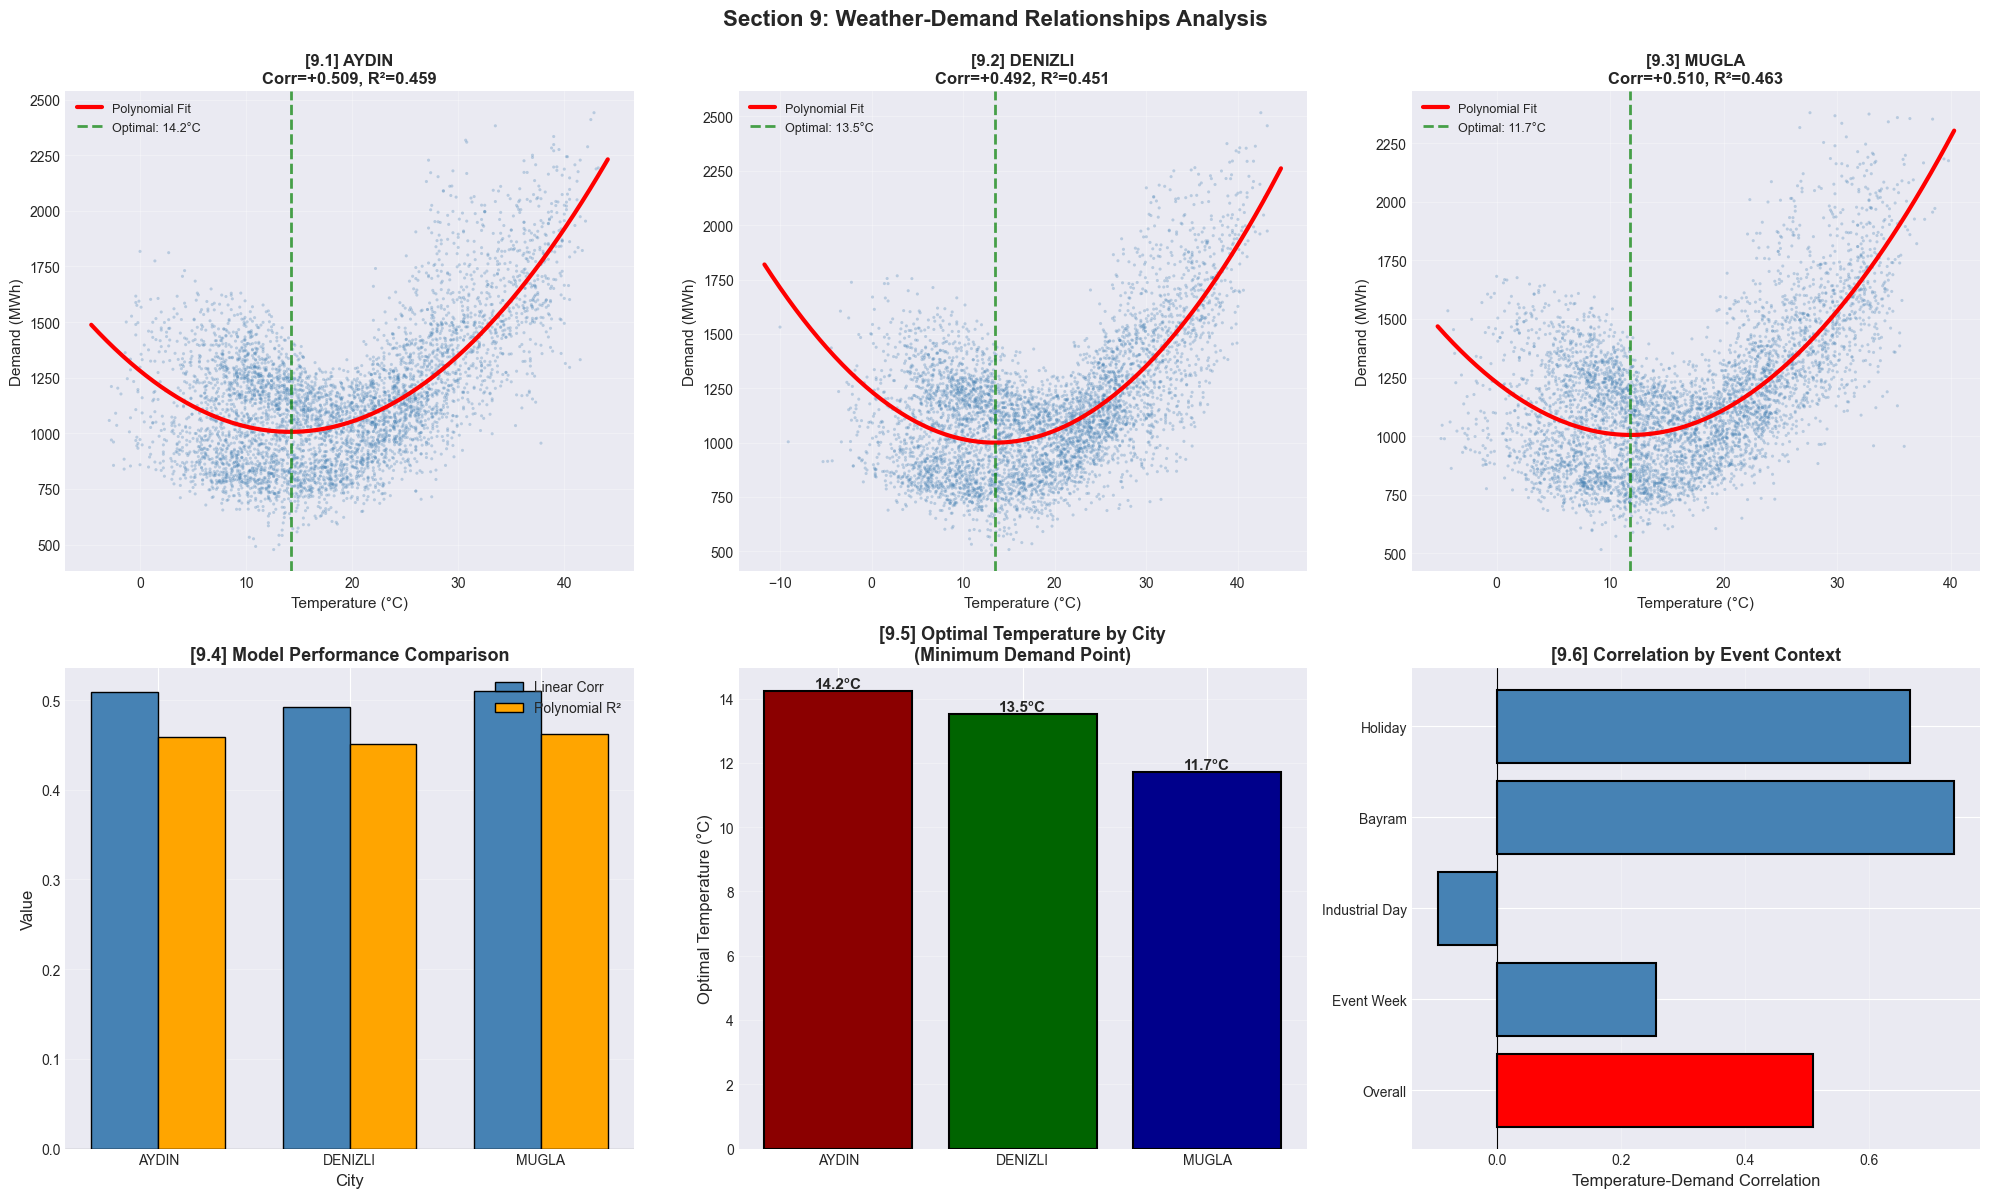


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\05_weather_demand_relationships.png


In [59]:
# ============================================================================
# SECTION 9: VISUALIZATION - WEATHER-DEMAND RELATIONSHIPS
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Section 9: Weather-Demand Relationships Analysis', fontsize=16, fontweight='bold', y=0.995)

# Store city-level stats for summary
city_stats = {}

# [9.1-9.3] Scatter plots with polynomial fits for each city
for idx, city in enumerate(CITIES):
    ax = axes[0, idx]
    
    if 'temperature_2m' in dfs[city].columns and 'demand' in dfs[city].columns:
        temp = dfs[city]['temperature_2m'].values
        demand_vals = dfs[city]['demand'].values
        
        # Sample for plotting
        sample_size = min(5000, len(temp))
        indices = np.random.choice(len(temp), sample_size, replace=False)
        temp_sample = temp[indices]
        demand_sample = demand_vals[indices]
        
        # Scatter plot
        ax.scatter(temp_sample, demand_sample, alpha=0.3, s=5, color='steelblue', edgecolors='none')
        
        # Polynomial fit
        z = np.polyfit(temp, demand_vals, 2)
        p = np.poly1d(z)
        temp_range = np.linspace(temp.min(), temp.max(), 200)
        ax.plot(temp_range, p(temp_range), 'r-', linewidth=3, label='Polynomial Fit')
        
        # Optimal temperature
        optimal_temp = temp_range[np.argmin(p(temp_range))]
        ax.axvline(optimal_temp, color='green', linestyle='--', linewidth=2, alpha=0.7, 
                  label=f'Optimal: {optimal_temp:.1f}°C')
        
        # Statistics
        corr = np.corrcoef(temp, demand_vals)[0, 1]
        demand_pred = p(temp)
        ss_res = np.sum((demand_vals - demand_pred)**2)
        ss_tot = np.sum((demand_vals - demand_vals.mean())**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        city_stats[city] = {'corr': corr, 'r2': r2, 'optimal_temp': optimal_temp}
        
        ax.set_xlabel('Temperature (°C)', fontsize=11)
        ax.set_ylabel('Demand (MWh)', fontsize=11)
        ax.set_title(f'[9.{idx+1}] {city.upper()}\nCorr={corr:+.3f}, R²={r2:.3f}', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)

# [9.4] Correlation comparison across cities
ax4 = axes[1, 0]
cities_upper = [c.upper() for c in CITIES]
corr_values = [city_stats[c]['corr'] for c in CITIES if c in city_stats]
r2_values = [city_stats[c]['r2'] for c in CITIES if c in city_stats]

x = np.arange(len(cities_upper))
width = 0.35

bars1 = ax4.bar(x - width/2, corr_values, width, label='Linear Corr', color='steelblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, r2_values, width, label='Polynomial R²', color='orange', edgecolor='black')

ax4.set_xlabel('City', fontsize=12)
ax4.set_ylabel('Value', fontsize=12)
ax4.set_title('[9.4] Model Performance Comparison', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(cities_upper)
ax4.legend(fontsize=10)
ax4.axhline(0, color='black', linewidth=0.8)
ax4.grid(True, alpha=0.3, axis='y')

# [9.5] Optimal temperature comparison
ax5 = axes[1, 1]
optimal_temps = [city_stats[c]['optimal_temp'] for c in CITIES if c in city_stats]
colors_opt = ['darkred', 'darkgreen', 'darkblue']
bars_opt = ax5.bar(cities_upper, optimal_temps, color=colors_opt, edgecolor='black', linewidth=1.5)

for bar, temp in zip(bars_opt, optimal_temps):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{temp:.1f}°C', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax5.set_ylabel('Optimal Temperature (°C)', fontsize=12)
ax5.set_title('[9.5] Optimal Temperature by City\n(Minimum Demand Point)', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# [9.6] Event-stratified correlation (if available)
ax6 = axes[1, 2]
events_for_weather = [col for col in ['is_event_week', 'is_industrial_day', 'is_bayram', 'is_holiday']
                     if col in base_df.columns]

if len(events_for_weather) > 0:
    event_corrs = []
    event_labels = []
    
    overall_corr = base_df['temperature_2m'].corr(base_df['demand'])
    event_corrs.append(overall_corr)
    event_labels.append('Overall')
    
    for event in events_for_weather:
        event_hours = base_df[base_df[event] == 1]
        if len(event_hours) > 50:
            event_corr = event_hours['temperature_2m'].corr(event_hours['demand'])
            event_corrs.append(event_corr)
            event_labels.append(event.replace('is_', '').replace('_', ' ').title())
    
    colors_event = ['red' if label == 'Overall' else 'steelblue' for label in event_labels]
    bars_event = ax6.barh(range(len(event_labels)), event_corrs, color=colors_event, edgecolor='black', linewidth=1.5)
    ax6.set_yticks(range(len(event_labels)))
    ax6.set_yticklabels(event_labels, fontsize=10)
    ax6.set_xlabel('Temperature-Demand Correlation', fontsize=12)
    ax6.set_title('[9.6] Correlation by Event Context', fontsize=13, fontweight='bold')
    ax6.axvline(0, color='black', linewidth=0.8)
    ax6.grid(True, alpha=0.3, axis='x')
else:
    ax6.text(0.5, 0.5, 'No event features available', ha='center', va='center', 
            fontsize=14, transform=ax6.transAxes)
    ax6.set_title('[9.6] Correlation by Event Context', fontsize=13, fontweight='bold')
    ax6.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '05_weather_demand_relationships.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Figure saved: {FIGURES_DIR / '05_weather_demand_relationships.png'}")

In [60]:
# ============================================================================
# SECTION 10: SUMMARY & FEATURE RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("SECTION 10: SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n[10.1] Key Findings")
print("-"*80)
print(f"✓ Data Period:        {base_df['time'].min().date()} to {base_df['time'].max().date()} ({len(base_df):,} hours)")
print(f"✓ Demand Range:       {base_df['demand'].min():.0f} - {base_df['demand'].max():.0f} MWh")
print(f"✓ Demand Mean:        {base_df['demand'].mean():.0f} MWh (±{base_df['demand'].std():.0f} σ)")
print(f"✓ Temp Range:         {base_df['temperature_2m'].min():.1f} - {base_df['temperature_2m'].max():.1f}°C")
print(f"✓ Diurnal Variation:  {hourly_stats['mean'].max() - hourly_stats['mean'].min():.0f} MWh")
print(f"✓ Event Features:      {len(event_cols_available)} columns available")

print("\n[10.2] Temperature Effects")
print("-"*80)
cold_delta = base_df[base_df['temp_regime']=='Extreme Cold (<5°C)']['demand'].mean() - overall_baseline
comfort_delta = base_df[base_df['temp_regime']=='Comfortable (18-24°C)']['demand'].mean() - overall_baseline
heat_delta = base_df[base_df['temp_regime']=='Extreme Heat (>35°C)']['demand'].mean() - overall_baseline
print(f"✓ Extreme Cold (<5°C):    +{cold_delta:.0f} MWh vs baseline")
print(f"✓ Comfortable (18-24°C):  {comfort_delta:+.0f} MWh vs baseline")
print(f"✓ Extreme Heat (>35°C):   +{heat_delta:.0f} MWh vs baseline")

print("\n[10.3] Feature Engineering Recommendations")
print("-"*80)
print("✓ Binary Features:")
print("  - hour_of_day (cyclical encoding)")
print("  - day_of_week")
print("  - month (cyclical encoding)")
print("  - holiday, bayram, ramadan flags (if events available)")
print("  - industrial_day, tourism_season, school_season")
print("\n✓ Continuous Features:")
print("  - temperature (linear + polynomial)")
print("  - humidity, wind_speed")
print("  - lagged demand (AR terms)")
print("\n✓ Interaction Features:")
print("  - temperature × hour_of_day")
print("  - temperature × event flags")
print("  - day_of_week × season")

print("\n" + "="*80)
print("✓ Data Exploration Complete")
print("="*80)


SECTION 10: SUMMARY & RECOMMENDATIONS

[10.1] Key Findings
--------------------------------------------------------------------------------
✓ Data Period:        2018-01-01 to 2025-08-31 (67,200 hours)
✓ Demand Range:       449 - 2517 MWh
✓ Demand Mean:        1158 MWh (±299 σ)
✓ Temp Range:         -4.6 - 44.1°C
✓ Diurnal Variation:  478 MWh
✓ Event Features:      33 columns available

[10.2] Temperature Effects
--------------------------------------------------------------------------------
✓ Extreme Cold (<5°C):    +-19 MWh vs baseline
✓ Comfortable (18-24°C):  -134 MWh vs baseline
✓ Extreme Heat (>35°C):   +586 MWh vs baseline

[10.3] Feature Engineering Recommendations
--------------------------------------------------------------------------------
✓ Binary Features:
  - hour_of_day (cyclical encoding)
  - day_of_week
  - month (cyclical encoding)
  - holiday, bayram, ramadan flags (if events available)
  - industrial_day, tourism_season, school_season

✓ Continuous Features:
  -

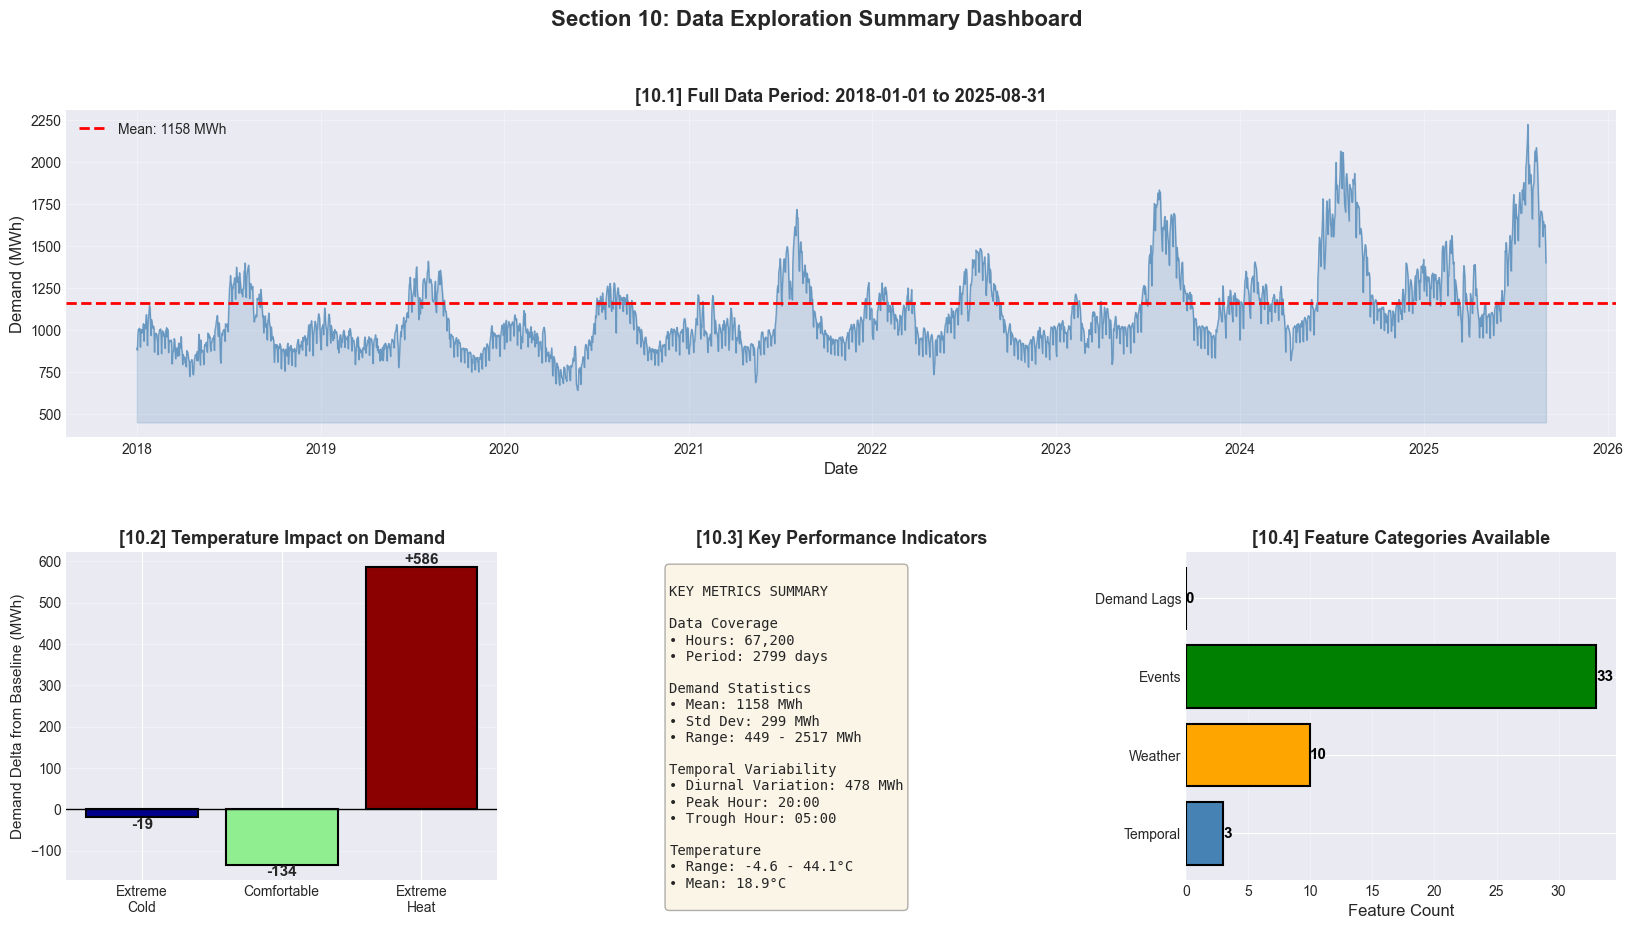


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\06_summary_dashboard.png


In [61]:
# ============================================================================
# SECTION 10: VISUALIZATION - SUMMARY DASHBOARD
# ============================================================================

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)
fig.suptitle('Section 10: Data Exploration Summary Dashboard', fontsize=16, fontweight='bold', y=0.98)

# [10.1] Timeline with Demand
ax1 = fig.add_subplot(gs[0, :])
# Sample the data for plotting (every 24th hour to show daily pattern)
sample_df = base_df.iloc[::24].copy()
ax1.plot(sample_df['time'], sample_df['demand'], linewidth=1, color='steelblue', alpha=0.7)
ax1.axhline(base_df['demand'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {base_df["demand"].mean():.0f} MWh')
ax1.fill_between(sample_df['time'], base_df['demand'].min(), sample_df['demand'], 
                alpha=0.2, color='steelblue')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Demand (MWh)', fontsize=12)
ax1.set_title(f'[10.1] Full Data Period: {base_df["time"].min().date()} to {base_df["time"].max().date()}', 
             fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# [10.2] Temperature Effects - Bar Chart
ax2 = fig.add_subplot(gs[1, 0])
temp_effects = {
    'Extreme\nCold': cold_delta,
    'Comfortable': comfort_delta,
    'Extreme\nHeat': heat_delta
}
colors_effects = ['darkblue', 'lightgreen', 'darkred']
bars_effects = ax2.bar(temp_effects.keys(), temp_effects.values(), color=colors_effects, 
                      edgecolor='black', linewidth=1.5)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_ylabel('Demand Delta from Baseline (MWh)', fontsize=11)
ax2.set_title('[10.2] Temperature Impact on Demand', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars_effects:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.0f}', ha='center', va='bottom' if height > 0 else 'top', 
            fontsize=11, fontweight='bold')

# [10.3] Key Metrics - KPI Cards (Text)
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')

kpi_text = f"""
KEY METRICS SUMMARY

Data Coverage
• Hours: {len(base_df):,}
• Period: {(base_df['time'].max() - base_df['time'].min()).days} days

Demand Statistics
• Mean: {base_df['demand'].mean():.0f} MWh
• Std Dev: {base_df['demand'].std():.0f} MWh
• Range: {base_df['demand'].min():.0f} - {base_df['demand'].max():.0f} MWh

Temporal Variability
• Diurnal Variation: {hourly_stats['mean'].max() - hourly_stats['mean'].min():.0f} MWh
• Peak Hour: {hourly_stats['mean'].idxmax():02d}:00
• Trough Hour: {hourly_stats['mean'].idxmin():02d}:00

Temperature
• Range: {base_df['temperature_2m'].min():.1f} - {base_df['temperature_2m'].max():.1f}°C
• Mean: {base_df['temperature_2m'].mean():.1f}°C
"""

ax3.text(0.1, 0.95, kpi_text, transform=ax3.transAxes, fontsize=10, 
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax3.set_title('[10.3] Key Performance Indicators', fontsize=13, fontweight='bold')

# [10.4] Feature Categories - Horizontal Bar
ax4 = fig.add_subplot(gs[1, 2])
feature_categories = {
    'Temporal': 3,  # hour, day_of_week, month
    'Weather': len([c for c in base_df.columns if 'temperature' in c or 'wind' in c or 'humidity' in c]),
    'Events': len(event_cols_available),
    'Demand Lags': 0  # To be engineered
}

cat_names = list(feature_categories.keys())
cat_counts = list(feature_categories.values())
colors_cat = ['steelblue', 'orange', 'green', 'gray']

bars_cat = ax4.barh(cat_names, cat_counts, color=colors_cat, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Feature Count', fontsize=12)
ax4.set_title('[10.4] Feature Categories Available', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar in bars_cat:
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2., f'{int(width)}',
            ha='left', va='center', fontsize=11, fontweight='bold', color='black')

plt.savefig(FIGURES_DIR / '06_summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Figure saved: {FIGURES_DIR / '06_summary_dashboard.png'}")

In [62]:
# ============================================================================
# SECTION 11: WEATHER FEATURES DEEP DIVE
# ============================================================================

print("\n" + "="*80)
print("SECTION 11: WEATHER FEATURES DEEP DIVE")
print("="*80)

weather_cols = ['relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
                'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
                'precipitation', 'snowfall', 'cloud_cover', 'pressure_msl']

available_weather = [col for col in weather_cols if col in base_df.columns]

print(f"\n[11.1] Available Weather Columns ({len(available_weather)}/{len(weather_cols)})")
print("-"*80)
for col in available_weather:
    print(f"✓ {col}")
for col in weather_cols:
    if col not in base_df.columns:
        print(f"✗ {col}")

if len(available_weather) > 0:
    print(f"\n[11.2] Weather Statistics")
    print("-"*80)
    for col in available_weather:
        if col in base_df.columns:
            data = base_df[col].dropna()
            if len(data) > 0:
                print(f"\n{col}:")
                print(f"  Mean:      {data.mean():.2f}")
                print(f"  Std Dev:   {data.std():.2f}")
                print(f"  Min:       {data.min():.2f}")
                print(f"  Max:       {data.max():.2f}")
                print(f"  Missing:   {len(base_df) - len(data):,d} ({(1 - len(data)/len(base_df))*100:.2f}%)")
    
    print(f"\n[11.3] Weather-Demand Correlations")
    print("-"*80)
    correlations = {}
    for col in available_weather:
        if col in base_df.columns:
            corr = base_df[col].corr(base_df['demand'])
            correlations[col] = corr
    
    sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    print(f"{'Feature':<30s} {'Correlation':>15s}")
    print("-"*45)
    for col, corr in sorted_corr:
        print(f"{col:<30s} {corr:>15.4f}")
else:
    print("\n⚠ No weather columns available in dataset")



SECTION 11: WEATHER FEATURES DEEP DIVE

[11.1] Available Weather Columns (10/10)
--------------------------------------------------------------------------------
✓ relative_humidity_2m
✓ dew_point_2m
✓ apparent_temperature
✓ wind_speed_10m
✓ wind_direction_10m
✓ wind_gusts_10m
✓ precipitation
✓ snowfall
✓ cloud_cover
✓ pressure_msl

[11.2] Weather Statistics
--------------------------------------------------------------------------------

relative_humidity_2m:
  Mean:      54.95
  Std Dev:   21.23
  Min:       5.00
  Max:       100.00
  Missing:   0 (0.00%)

dew_point_2m:
  Mean:      8.09
  Std Dev:   5.47
  Min:       -14.20
  Max:       27.30
  Missing:   0 (0.00%)

apparent_temperature:
  Mean:      17.87
  Std Dev:   10.32
  Min:       -9.00
  Max:       47.10
  Missing:   0 (0.00%)

wind_speed_10m:
  Mean:      1.81
  Std Dev:   1.12
  Min:       0.00
  Max:       8.00
  Missing:   0 (0.00%)

wind_direction_10m:
  Mean:      184.90
  Std Dev:   113.85
  Min:       1.00
  Max:   

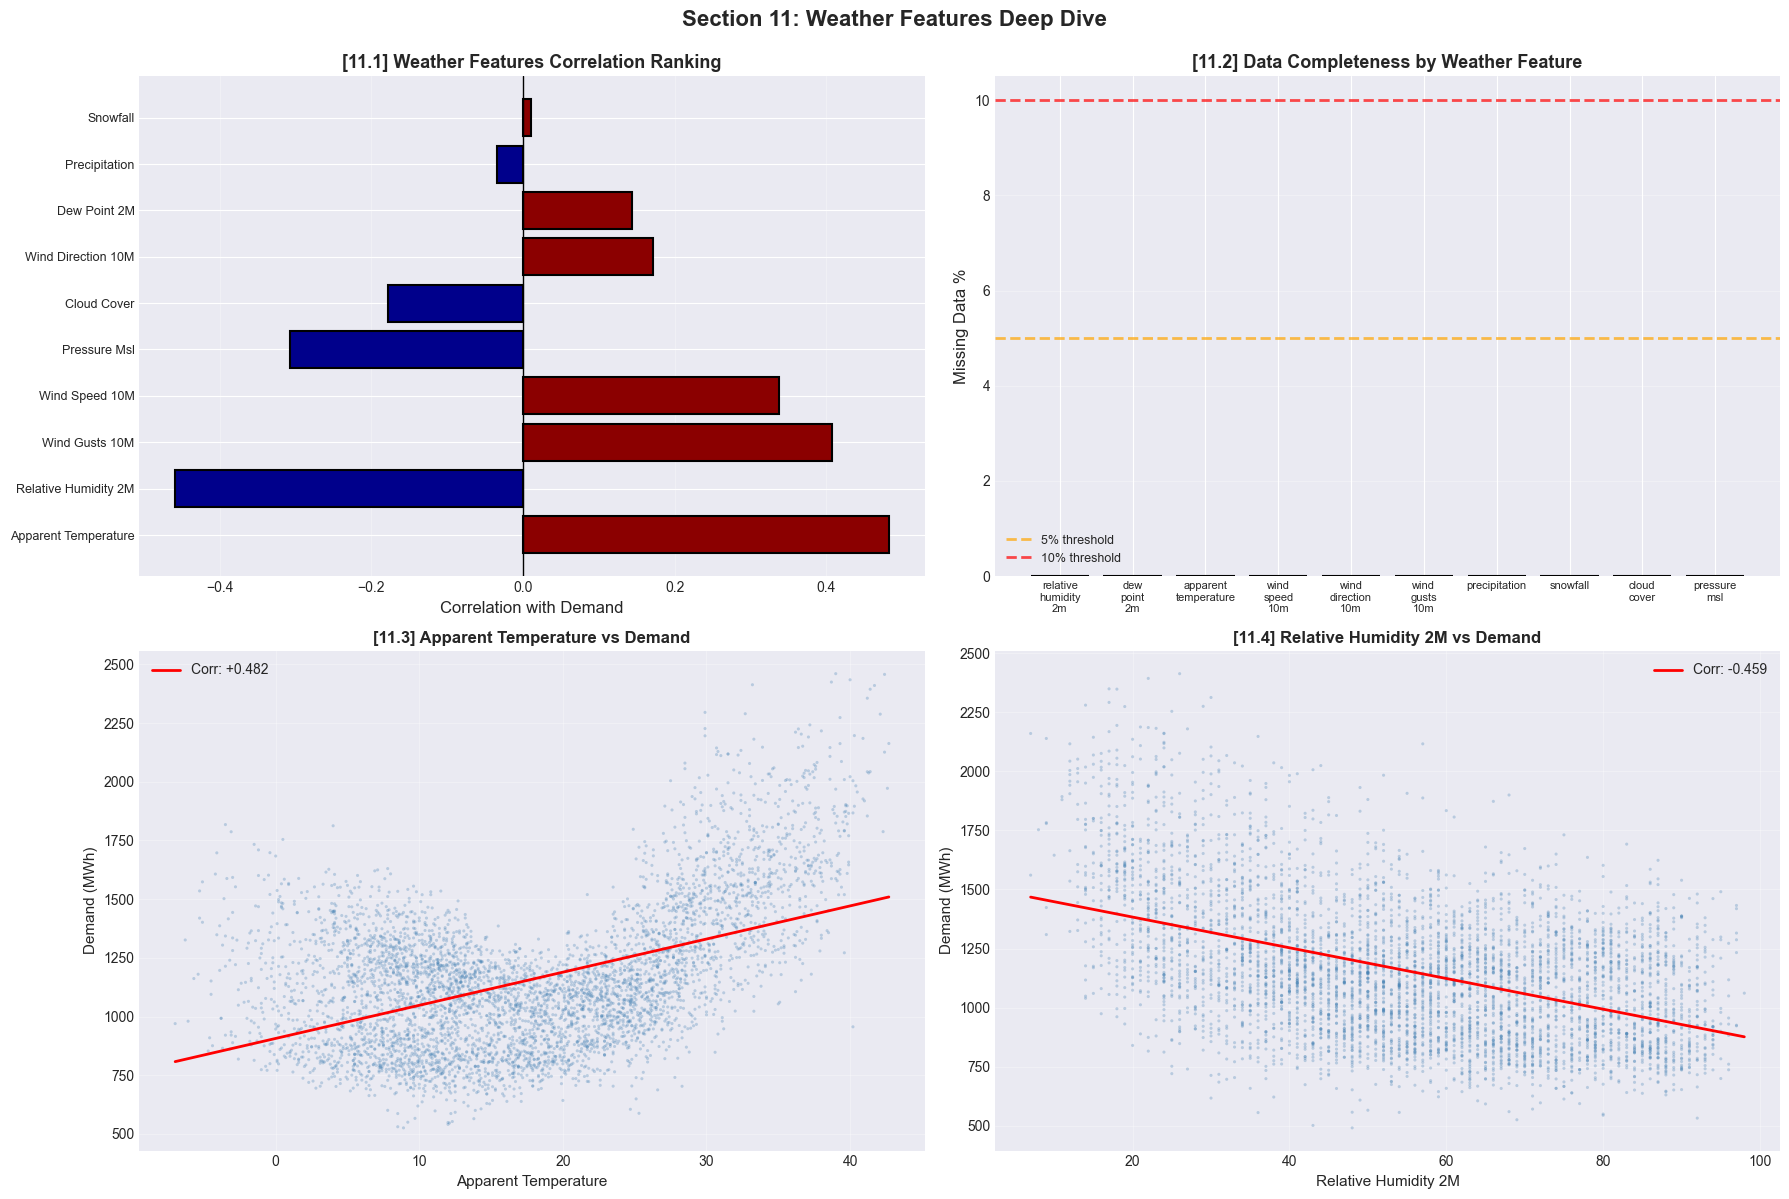


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\07_weather_features_analysis.png


In [63]:
# ============================================================================
# SECTION 11: VISUALIZATION - WEATHER FEATURES ANALYSIS
# ============================================================================

if len(available_weather) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Section 11: Weather Features Deep Dive', fontsize=16, fontweight='bold', y=0.995)
    
    # [11.1] Correlation Heatmap
    ax1 = axes[0, 0]
    weather_corr_data = {}
    for col in available_weather:
        if col in base_df.columns:
            weather_corr_data[col] = base_df[col].corr(base_df['demand'])
    
    sorted_weather = sorted(weather_corr_data.items(), key=lambda x: abs(x[1]), reverse=True)
    weather_names = [item[0].replace('_', ' ').title() for item in sorted_weather]
    weather_corrs = [item[1] for item in sorted_weather]
    
    colors_corr = ['darkred' if c > 0 else 'darkblue' for c in weather_corrs]
    bars_corr = ax1.barh(range(len(weather_names)), weather_corrs, color=colors_corr, 
                         edgecolor='black', linewidth=1.5)
    ax1.set_yticks(range(len(weather_names)))
    ax1.set_yticklabels(weather_names, fontsize=9)
    ax1.set_xlabel('Correlation with Demand', fontsize=12)
    ax1.set_title('[11.1] Weather Features Correlation Ranking', fontsize=13, fontweight='bold')
    ax1.axvline(0, color='black', linewidth=1)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # [11.2] Missing Data Analysis
    ax2 = axes[0, 1]
    missing_pcts = []
    for col in available_weather:
        if col in base_df.columns:
            missing_pct = (1 - len(base_df[col].dropna()) / len(base_df)) * 100
            missing_pcts.append(missing_pct)
    
    colors_missing = ['green' if p < 1 else 'orange' if p < 10 else 'red' for p in missing_pcts]
    bars_missing = ax2.bar(range(len(available_weather)), missing_pcts, color=colors_missing, 
                           edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(len(available_weather)))
    ax2.set_xticklabels([w.replace('_', '\n') for w in available_weather], fontsize=8, rotation=0)
    ax2.set_ylabel('Missing Data %', fontsize=12)
    ax2.set_title('[11.2] Data Completeness by Weather Feature', fontsize=13, fontweight='bold')
    ax2.axhline(5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='5% threshold')
    ax2.axhline(10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='10% threshold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # [11.3] Scatter Plots - Top 2 Correlated Features
    top_2_weather = sorted_weather[:2]
    for idx, (col, corr) in enumerate(top_2_weather):
        ax = axes[1, idx]
        
        if col in base_df.columns:
            # Sample data
            sample_size = min(5000, len(base_df))
            sample_indices = np.random.choice(len(base_df), sample_size, replace=False)
            x_data = base_df[col].iloc[sample_indices]
            y_data = base_df['demand'].iloc[sample_indices]
            
            ax.scatter(x_data, y_data, alpha=0.3, s=5, color='steelblue', edgecolors='none')
            
            # Linear fit
            valid = x_data.notna() & y_data.notna()
            if valid.sum() > 10:
                z = np.polyfit(x_data[valid], y_data[valid], 1)
                p = np.poly1d(z)
                x_range = np.linspace(x_data.min(), x_data.max(), 100)
                ax.plot(x_range, p(x_range), 'r-', linewidth=2, label=f'Corr: {corr:+.3f}')
            
            ax.set_xlabel(col.replace('_', ' ').title(), fontsize=11)
            ax.set_ylabel('Demand (MWh)', fontsize=11)
            ax.set_title(f'[11.{idx+3}] {col.replace("_", " ").title()} vs Demand', 
                        fontsize=12, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '07_weather_features_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Figure saved: {FIGURES_DIR / '07_weather_features_analysis.png'}")
else:
    print("\n⚠ No weather features available for visualization")

In [64]:
# ============================================================================
# SECTION 12: DEGREE DAYS & SEASONAL FEATURES
# ============================================================================

print("\n" + "="*80)
print("SECTION 12: DEGREE DAYS & SEASONAL FEATURES")
print("="*80)

degree_cols = ['heating_degree_hours_seasonal', 'cooling_degree_hours_seasonal',
               'heating_degree_hours_adaptive', 'cooling_degree_hours_adaptive',
               'heating_degree_hours_static', 'cooling_degree_hours_static',
               'seasonal_temp_deviation']

demand_index_cols = ['heating_demand_index_seasonal', 'cooling_demand_index_seasonal',
                     'heating_demand_index_adaptive', 'cooling_demand_index_adaptive']

available_degree = [col for col in degree_cols if col in base_df.columns]
available_index = [col for col in demand_index_cols if col in base_df.columns]

print(f"\n[12.1] Degree Days Columns ({len(available_degree)}/{len(degree_cols)})")
print("-"*80)
for col in available_degree:
    print(f"✓ {col}")
for col in degree_cols:
    if col not in base_df.columns:
        print(f"✗ {col}")

print(f"\n[12.2] Demand Index Columns ({len(available_index)}/{len(demand_index_cols)})")
print("-"*80)
for col in available_index:
    print(f"✓ {col}")
for col in demand_index_cols:
    if col not in base_df.columns:
        print(f"✗ {col}")

if len(available_degree) > 0:
    print(f"\n[12.3] Degree Days Analysis")
    print("-"*80)
    for col in available_degree:
        if col in base_df.columns:
            data = base_df[col].dropna()
            if len(data) > 0:
                print(f"\n{col}:")
                print(f"  Mean:      {data.mean():.2f}")
                print(f"  Std Dev:   {data.std():.2f}")
                print(f"  Min:       {data.min():.2f}")
                print(f"  Max:       {data.max():.2f}")
                
                # Correlation with demand
                corr = base_df[col].corr(base_df['demand'])
                print(f"  Demand Corr: {corr:+.4f}")

if len(available_index) > 0:
    print(f"\n[12.4] Demand Index Correlations")
    print("-"*80)
    print(f"{'Feature':<40s} {'Correlation':>15s}")
    print("-"*55)
    for col in available_index:
        if col in base_df.columns:
            corr = base_df[col].corr(base_df['demand'])
            print(f"{col:<40s} {corr:>15.4f}")



SECTION 12: DEGREE DAYS & SEASONAL FEATURES

[12.1] Degree Days Columns (7/7)
--------------------------------------------------------------------------------
✓ heating_degree_hours_seasonal
✓ cooling_degree_hours_seasonal
✓ heating_degree_hours_adaptive
✓ cooling_degree_hours_adaptive
✓ heating_degree_hours_static
✓ cooling_degree_hours_static
✓ seasonal_temp_deviation

[12.2] Demand Index Columns (4/4)
--------------------------------------------------------------------------------
✓ heating_demand_index_seasonal
✓ cooling_demand_index_seasonal
✓ heating_demand_index_adaptive
✓ cooling_demand_index_adaptive

[12.3] Degree Days Analysis
--------------------------------------------------------------------------------

heating_degree_hours_seasonal:
  Mean:      2.20
  Std Dev:   3.63
  Min:       0.00
  Max:       20.10
  Demand Corr: -0.1159

cooling_degree_hours_seasonal:
  Mean:      2.28
  Std Dev:   4.12
  Min:       0.00
  Max:       20.60
  Demand Corr: +0.6602

heating_degree_

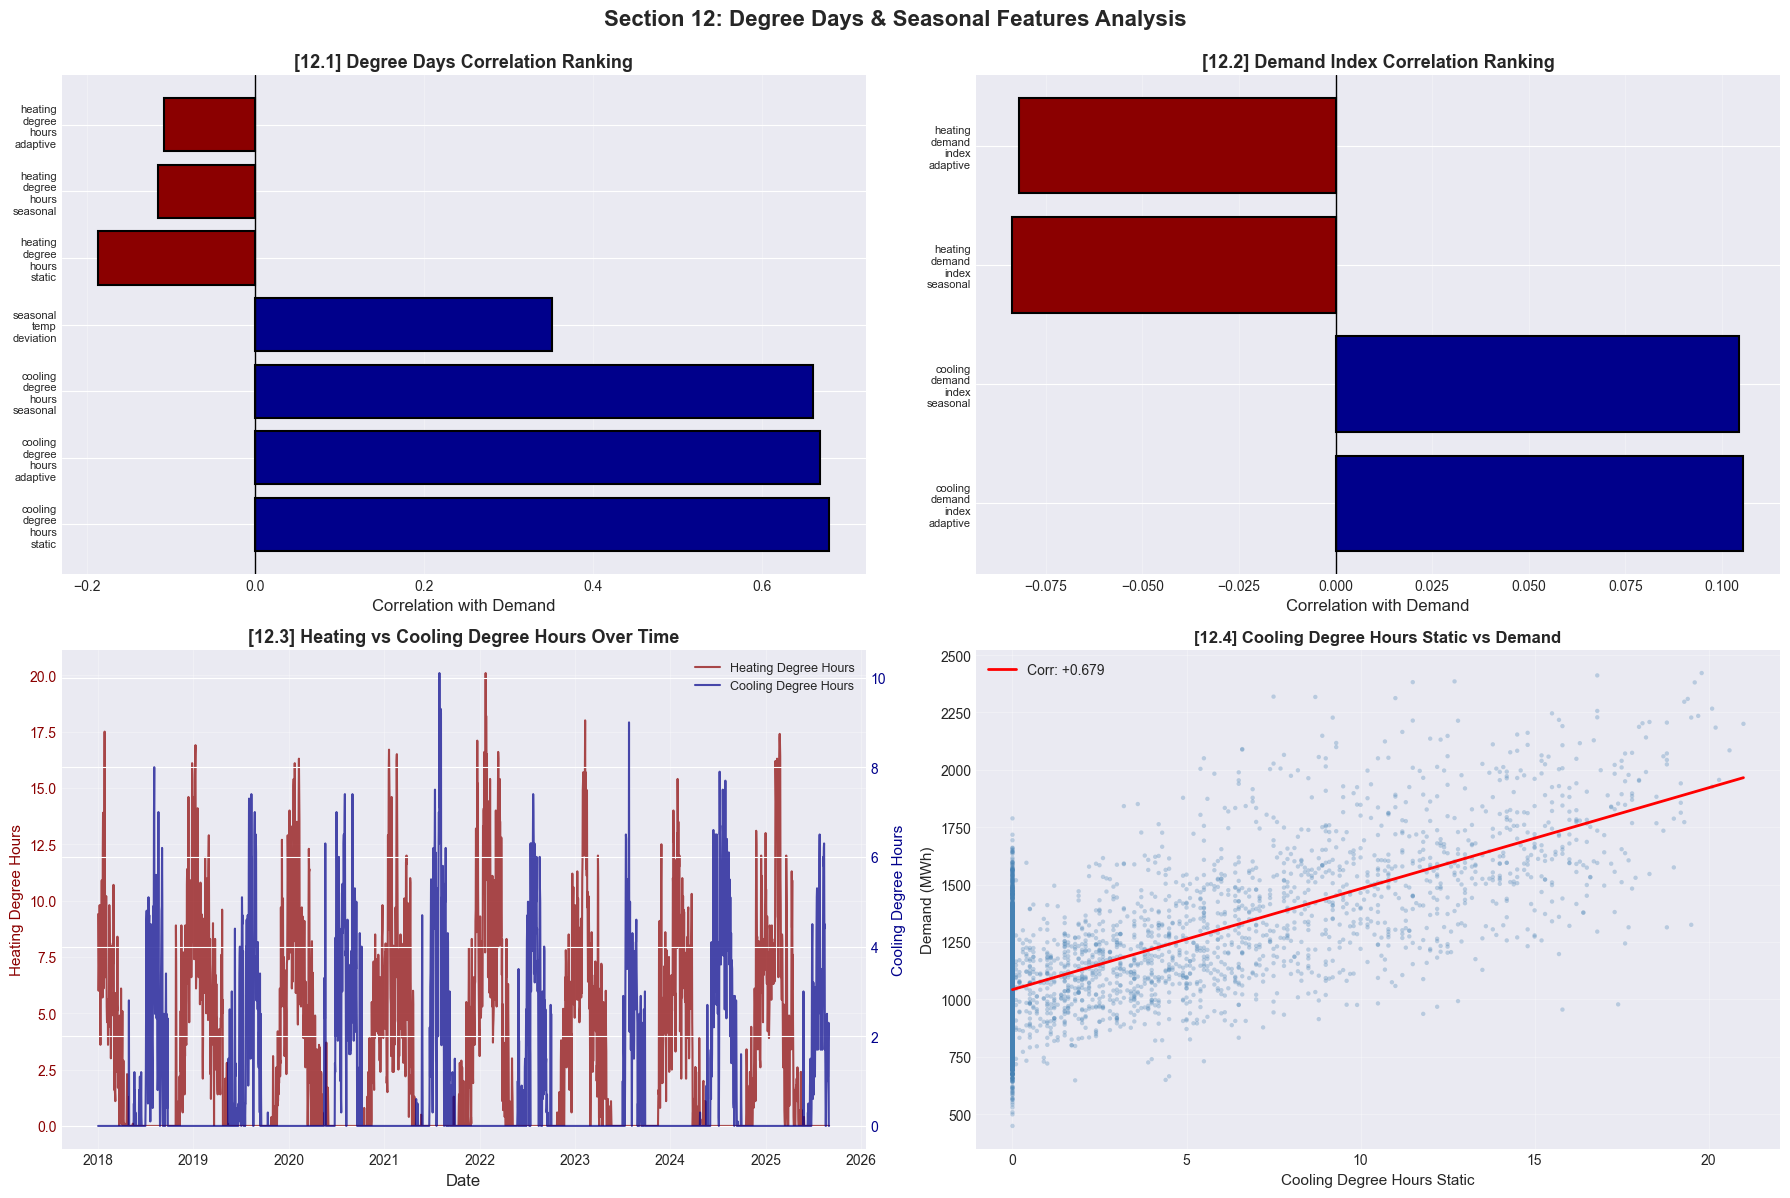


✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\08_degree_days_analysis.png


In [65]:
# ============================================================================
# SECTION 12: VISUALIZATION - DEGREE DAYS & DEMAND INDICES
# ============================================================================

if len(available_degree) > 0 or len(available_index) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Section 12: Degree Days & Seasonal Features Analysis', fontsize=16, fontweight='bold', y=0.995)
    
    # [12.1] Degree Days Correlation - Bar Chart
    ax1 = axes[0, 0]
    if len(available_degree) > 0:
        degree_corrs = {}
        for col in available_degree:
            if col in base_df.columns:
                corr = base_df[col].corr(base_df['demand'])
                degree_corrs[col] = corr
        
        sorted_degree = sorted(degree_corrs.items(), key=lambda x: abs(x[1]), reverse=True)
        degree_names = [item[0].replace('_', '\n') for item in sorted_degree]
        degree_vals = [item[1] for item in sorted_degree]
        
        colors_deg = ['darkred' if 'heating' in item[0] else 'darkblue' for item in sorted_degree]
        bars_deg = ax1.barh(range(len(degree_names)), degree_vals, color=colors_deg, 
                           edgecolor='black', linewidth=1.5)
        ax1.set_yticks(range(len(degree_names)))
        ax1.set_yticklabels(degree_names, fontsize=8)
        ax1.set_xlabel('Correlation with Demand', fontsize=12)
        ax1.set_title('[12.1] Degree Days Correlation Ranking', fontsize=13, fontweight='bold')
        ax1.axvline(0, color='black', linewidth=1)
        ax1.grid(True, alpha=0.3, axis='x')
    else:
        ax1.text(0.5, 0.5, 'No degree days features available', ha='center', va='center',
                fontsize=14, transform=ax1.transAxes)
        ax1.axis('off')
    
    # [12.2] Demand Index Correlation - Bar Chart
    ax2 = axes[0, 1]
    if len(available_index) > 0:
        index_corrs = {}
        for col in available_index:
            if col in base_df.columns:
                corr = base_df[col].corr(base_df['demand'])
                index_corrs[col] = corr
        
        sorted_index = sorted(index_corrs.items(), key=lambda x: abs(x[1]), reverse=True)
        index_names = [item[0].replace('_', '\n') for item in sorted_index]
        index_vals = [item[1] for item in sorted_index]
        
        colors_idx = ['darkred' if 'heating' in item[0] else 'darkblue' for item in sorted_index]
        bars_idx = ax2.barh(range(len(index_names)), index_vals, color=colors_idx, 
                           edgecolor='black', linewidth=1.5)
        ax2.set_yticks(range(len(index_names)))
        ax2.set_yticklabels(index_names, fontsize=8)
        ax2.set_xlabel('Correlation with Demand', fontsize=12)
        ax2.set_title('[12.2] Demand Index Correlation Ranking', fontsize=13, fontweight='bold')
        ax2.axvline(0, color='black', linewidth=1)
        ax2.grid(True, alpha=0.3, axis='x')
    else:
        ax2.text(0.5, 0.5, 'No demand index features available', ha='center', va='center',
                fontsize=14, transform=ax2.transAxes)
        ax2.axis('off')
    
    # [12.3] Time Series - Heating vs Cooling Degree Days
    ax3 = axes[1, 0]
    heating_cols = [c for c in available_degree if 'heating' in c]
    cooling_cols = [c for c in available_degree if 'cooling' in c]
    
    if len(heating_cols) > 0 or len(cooling_cols) > 0:
        # Sample data (daily aggregation for clarity)
        sample_df = base_df.iloc[::24].copy()  # Every 24th hour
        
        if len(heating_cols) > 0:
            ax3.plot(sample_df['time'], sample_df[heating_cols[0]], 
                    linewidth=1.5, color='darkred', alpha=0.7, label='Heating Degree Hours')
        if len(cooling_cols) > 0:
            ax3_twin = ax3.twinx()
            ax3_twin.plot(sample_df['time'], sample_df[cooling_cols[0]], 
                         linewidth=1.5, color='darkblue', alpha=0.7, label='Cooling Degree Hours')
            ax3_twin.set_ylabel('Cooling Degree Hours', fontsize=11, color='darkblue')
            ax3_twin.tick_params(axis='y', labelcolor='darkblue')
        
        ax3.set_xlabel('Date', fontsize=12)
        ax3.set_ylabel('Heating Degree Hours', fontsize=11, color='darkred')
        ax3.set_title('[12.3] Heating vs Cooling Degree Hours Over Time', fontsize=13, fontweight='bold')
        ax3.tick_params(axis='y', labelcolor='darkred')
        ax3.grid(True, alpha=0.3)
        
        # Combine legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        if len(cooling_cols) > 0:
            lines2, labels2 = ax3_twin.get_legend_handles_labels()
            ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)
        else:
            ax3.legend(loc='upper right', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'No degree days time series available', ha='center', va='center',
                fontsize=14, transform=ax3.transAxes)
        ax3.axis('off')
    
    # [12.4] Scatter - Top Degree Days Feature vs Demand
    ax4 = axes[1, 1]
    if len(available_degree) > 0:
        top_feature = sorted_degree[0][0]
        
        # Sample for plotting
        sample_size = min(5000, len(base_df))
        sample_indices = np.random.choice(len(base_df), sample_size, replace=False)
        x_data = base_df[top_feature].iloc[sample_indices]
        y_data = base_df['demand'].iloc[sample_indices]
        
        ax4.scatter(x_data, y_data, alpha=0.3, s=10, color='steelblue', edgecolors='none')
        
        # Linear fit
        valid = x_data.notna() & y_data.notna()
        if valid.sum() > 10:
            z = np.polyfit(x_data[valid], y_data[valid], 1)
            p = np.poly1d(z)
            x_range = np.linspace(x_data.min(), x_data.max(), 100)
            ax4.plot(x_range, p(x_range), 'r-', linewidth=2, 
                    label=f'Corr: {sorted_degree[0][1]:+.3f}')
        
        ax4.set_xlabel(top_feature.replace('_', ' ').title(), fontsize=11)
        ax4.set_ylabel('Demand (MWh)', fontsize=11)
        ax4.set_title(f'[12.4] {top_feature.replace("_", " ").title()} vs Demand', 
                     fontsize=12, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No degree days features for scatter plot', ha='center', va='center',
                fontsize=14, transform=ax4.transAxes)
        ax4.axis('off')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '08_degree_days_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Figure saved: {FIGURES_DIR / '08_degree_days_analysis.png'}")
else:
    print("\n⚠ No degree days or demand index features available for visualization")

In [66]:
# ============================================================================
# SECTION 13: TEMPERATURE-DERIVED FEATURES
# ============================================================================

print("\n" + "="*80)
print("SECTION 13: TEMPERATURE-DERIVED FEATURES")
print("="*80)

temp_derived = ['temperature_lag_1h', 'temperature_lag_24h', 'temperature_ma_24h',
                'heat_index', 'wind_chill', 'heating_base_temp_seasonal',
                'cooling_base_temp_seasonal', 'heating_base_temp_adaptive',
                'cooling_base_temp_adaptive', 'seasonal_temp_deviation']

available_temp_derived = [col for col in temp_derived if col in base_df.columns]

print(f"\n[13.1] Available Temperature-Derived Columns ({len(available_temp_derived)}/{len(temp_derived)})")
print("-"*80)
for col in available_temp_derived:
    print(f"✓ {col}")
for col in temp_derived:
    if col not in base_df.columns:
        print(f"✗ {col}")

if 'temperature_lag_1h' in base_df.columns or 'temperature_lag_24h' in base_df.columns:
    print(f"\n[13.2] Temperature Lagged Features")
    print("-"*80)
    
    lag_features = ['temperature_lag_1h', 'temperature_lag_24h', 'temperature_ma_24h']
    for col in lag_features:
        if col in base_df.columns:
            corr = base_df[col].corr(base_df['demand'])
            print(f"{col:<30s} Demand Correlation: {corr:+.4f}")

if 'heat_index' in base_df.columns or 'wind_chill' in base_df.columns:
    print(f"\n[13.3] Heat/Cold Indices")
    print("-"*80)
    
    for col in ['heat_index', 'wind_chill']:
        if col in base_df.columns:
            data = base_df[col].dropna()
            if len(data) > 0:
                corr = base_df[col].corr(base_df['demand'])
                print(f"\n{col}:")
                print(f"  Mean:          {data.mean():.2f}")
                print(f"  Range:         {data.min():.2f} - {data.max():.2f}")
                print(f"  Demand Corr:   {corr:+.4f}")

if len(available_temp_derived) > 0:
    print(f"\n[13.4] All Temperature-Derived Feature Correlations")
    print("-"*80)
    print(f"{'Feature':<35s} {'Correlation':>15s}")
    print("-"*50)
    for col in available_temp_derived:
        corr = base_df[col].corr(base_df['demand'])
        print(f"{col:<35s} {corr:>15.4f}")



SECTION 13: TEMPERATURE-DERIVED FEATURES

[13.1] Available Temperature-Derived Columns (10/10)
--------------------------------------------------------------------------------
✓ temperature_lag_1h
✓ temperature_lag_24h
✓ temperature_ma_24h
✓ heat_index
✓ wind_chill
✓ heating_base_temp_seasonal
✓ cooling_base_temp_seasonal
✓ heating_base_temp_adaptive
✓ cooling_base_temp_adaptive
✓ seasonal_temp_deviation

[13.2] Temperature Lagged Features
--------------------------------------------------------------------------------
temperature_lag_1h             Demand Correlation: +0.5107
temperature_lag_24h            Demand Correlation: +0.5124
temperature_ma_24h             Demand Correlation: +0.3702

[13.3] Heat/Cold Indices
--------------------------------------------------------------------------------

heat_index:
  Mean:          18.92
  Range:         -4.60 - 50.98
  Demand Corr:   +0.5101

wind_chill:
  Mean:          18.76
  Range:         -8.22 - 44.10
  Demand Corr:   +0.5014

[13.4

In [67]:
# ============================================================================
# SECTION 14: TIME FEATURES DEEP DIVE
# ============================================================================

print("\n" + "="*80)
print("SECTION 14: TIME FEATURES DEEP DIVE")
print("="*80)

time_features = ['hour', 'day_of_week', 'day_of_year', 'is_weekend', 'is_business_hour',
                 'day_phase', 'is_winter', 'is_spring', 'is_summer', 'is_fall',
                 'week_of_month', 'day', 'date', 'is_morning_peak', 'is_evening_peak',
                 'is_night', 'is_midday']

available_time = [col for col in time_features if col in base_df.columns]

print(f"\n[14.1] Available Time Feature Columns ({len(available_time)}/{len(time_features)})")
print("-"*80)
for col in available_time:
    print(f"✓ {col}")
for col in time_features:
    if col not in base_df.columns:
        print(f"✗ {col}")

print(f"\n[14.2] Weekend vs Weekday Analysis")
print("-"*80)
if 'is_weekend' in base_df.columns:
    weekend_demand = base_df[base_df['is_weekend'] == 1]['demand'].mean()
    weekday_demand = base_df[base_df['is_weekend'] == 0]['demand'].mean()
    print(f"Weekday Mean:  {weekday_demand:,.0f} MWh")
    print(f"Weekend Mean:  {weekend_demand:,.0f} MWh")
    print(f"Difference:    {weekend_demand - weekday_demand:+,.0f} MWh ({(weekend_demand/weekday_demand - 1)*100:+.2f}%)")
else:
    print("✗ is_weekend column not available")

print(f"\n[14.3] Business Hour Analysis")
print("-"*80)
if 'is_business_hour' in base_df.columns:
    business_demand = base_df[base_df['is_business_hour'] == 1]['demand'].mean()
    non_business_demand = base_df[base_df['is_business_hour'] == 0]['demand'].mean()
    print(f"Business Hours:     {business_demand:,.0f} MWh")
    print(f"Non-Business Hours: {non_business_demand:,.0f} MWh")
    print(f"Difference:         {business_demand - non_business_demand:+,.0f} MWh ({(business_demand/non_business_demand - 1)*100:+.2f}%)")
else:
    print("✗ is_business_hour column not available")

print(f"\n[14.4] Day Phase Analysis")
print("-"*80)
if 'day_phase' in base_df.columns or 'is_morning_peak' in base_df.columns or 'is_evening_peak' in base_df.columns:
    print("Available day phase features:")
    for col in ['day_phase', 'is_morning_peak', 'is_evening_peak', 'is_midday', 'is_night']:
        if col in base_df.columns:
            if col == 'day_phase':
                phases = base_df[col].unique()
                print(f"\n  {col}: {len(phases)} unique phases")
                for phase in phases:
                    if pd.notna(phase):
                        phase_demand = base_df[base_df[col] == phase]['demand'].mean()
                        print(f"    {phase}: {phase_demand:,.0f} MWh")
            else:
                pct = base_df[col].sum() / len(base_df) * 100
                phase_demand = base_df[base_df[col] == 1]['demand'].mean()
                print(f"  {col}: {pct:.1f}% | {phase_demand:,.0f} MWh avg")
else:
    print("✗ No day phase columns available")

print(f"\n[14.5] Seasonal Analysis")
print("-"*80)
season_cols = ['is_winter', 'is_spring', 'is_summer', 'is_fall']
available_seasons = [col for col in season_cols if col in base_df.columns]
if len(available_seasons) > 0:
    print(f"{'Season':<20s} {'Hours':>10s} {'%':>8s} {'Mean (MWh)':>15s}")
    print("-"*54)
    for col in available_seasons:
        season_name = col.replace('is_', '').capitalize()
        count = base_df[col].sum()
        pct = count / len(base_df) * 100
        mean = base_df[base_df[col] == 1]['demand'].mean()
        print(f"{season_name:<20s} {count:>10,d} {pct:>7.1f}% {mean:>15,.0f}")
else:
    print("✗ No seasonal columns available")



SECTION 14: TIME FEATURES DEEP DIVE

[14.1] Available Time Feature Columns (17/17)
--------------------------------------------------------------------------------
✓ hour
✓ day_of_week
✓ day_of_year
✓ is_weekend
✓ is_business_hour
✓ day_phase
✓ is_winter
✓ is_spring
✓ is_summer
✓ is_fall
✓ week_of_month
✓ day
✓ date
✓ is_morning_peak
✓ is_evening_peak
✓ is_night
✓ is_midday

[14.2] Weekend vs Weekday Analysis
--------------------------------------------------------------------------------
Weekday Mean:  1,182 MWh
Weekend Mean:  1,097 MWh
Difference:    -85 MWh (-7.19%)

[14.3] Business Hour Analysis
--------------------------------------------------------------------------------
Business Hours:     1,297 MWh
Non-Business Hours: 1,090 MWh
Difference:         +207 MWh (+19.01%)

[14.4] Day Phase Analysis
--------------------------------------------------------------------------------
Available day phase features:

  day_phase: 4 unique phases
    night: 1,020 MWh
    morning: 1,110 MWh


In [68]:
# ============================================================================
# SECTION 15: EVENTS & HOLIDAYS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 15: EVENTS & HOLIDAYS ANALYSIS")
print("="*80)

holiday_cols = ['is_holiday', 'holiday_name', 'is_new_year', 'is_election_day',
                'is_lockdown', 'is_ramadan', 'is_ramazan_bayram', 'is_kurban_bayram',
                'is_bayram', 'is_eve', 'is_sahur', 'is_iftar', 'holiday_before',
                'holiday_after', 'is_bridge_day', 'days_to_eid', 'days_since_eid']

available_holidays = [col for col in holiday_cols if col in base_df.columns]

print(f"\n[15.1] Available Holiday/Event Columns ({len(available_holidays)}/{len(holiday_cols)})")
print("-"*80)
for col in available_holidays:
    print(f"✓ {col}")
print()
for col in holiday_cols:
    if col not in base_df.columns:
        print(f"✗ {col}")

print(f"\n[15.2] Binary Holiday/Event Flags")
print("-"*80)
binary_holidays = [col for col in available_holidays if col.startswith('is_')]
if len(binary_holidays) > 0:
    print(f"{'Event Flag':<35s} {'Hours':>10s} {'%':>8s} {'Mean (MWh)':>15s} {'vs Baseline':>12s}")
    print("-"*80)
    baseline = base_df['demand'].mean()
    for col in binary_holidays:
        count = base_df[col].sum()
        pct = count / len(base_df) * 100
        mean = base_df[base_df[col] == 1]['demand'].mean()
        delta = mean - baseline
        print(f"{col:<35s} {count:>10,d} {pct:>7.2f}% {mean:>15,.0f} {delta:>+11,.0f}")

print(f"\n[15.3] Categorical Holiday Info")
print("-"*80)
if 'holiday_name' in base_df.columns:
    holidays = base_df[base_df['holiday_name'].notna()]['holiday_name'].unique()
    print(f"Total unique holidays/events: {len(holidays)}")
    print("\nHoliday Impact on Demand:")
    for holiday in holidays[:10]:  # Top 10
        holiday_data = base_df[base_df['holiday_name'] == holiday]
        mean_demand = holiday_data['demand'].mean()
        count = len(holiday_data)
        delta = mean_demand - baseline
        print(f"  {holiday:<30s} {count:>6,d} hours | {mean_demand:>10,.0f} MWh | {delta:>+8,.0f}")
else:
    print("✗ holiday_name column not available")

print(f"\n[15.4] Ramadan & Religious Events")
print("-"*80)
ramadan_events = ['is_ramadan', 'is_ramazan_bayram', 'is_kurban_bayram', 'is_bayram', 'is_sahur', 'is_iftar']
ramadan_available = [col for col in ramadan_events if col in base_df.columns]
if len(ramadan_available) > 0:
    print(f"{'Event':<30s} {'Hours':>10s} {'%':>8s} {'Mean Demand':>15s}")
    print("-"*63)
    for col in ramadan_available:
        count = base_df[col].sum()
        pct = count / len(base_df) * 100
        mean = base_df[base_df[col] == 1]['demand'].mean()
        print(f"{col:<30s} {count:>10,d} {pct:>7.2f}% {mean:>15,.0f}")
else:
    print("✗ No Ramadan/religious event columns available")

print(f"\n[15.5] Event Proximity Analysis")
print("-"*80)
proximity_cols = ['days_to_eid', 'days_since_eid', 'holiday_before', 'holiday_after']
proximity_available = [col for col in proximity_cols if col in base_df.columns]
if len(proximity_available) > 0:
    for col in proximity_available:
        data = base_df[col].dropna()
        if len(data) > 0:
            print(f"\n{col}:")
            print(f"  Mean:  {data.mean():.2f}")
            print(f"  Range: {data.min():.0f} to {data.max():.0f}")
            corr = base_df[col].corr(base_df['demand'])
            print(f"  Demand Correlation: {corr:+.4f}")
else:
    print("✗ No event proximity columns available")



SECTION 15: EVENTS & HOLIDAYS ANALYSIS

[15.1] Available Holiday/Event Columns (17/17)
--------------------------------------------------------------------------------
✓ is_holiday
✓ holiday_name
✓ is_new_year
✓ is_election_day
✓ is_lockdown
✓ is_ramadan
✓ is_ramazan_bayram
✓ is_kurban_bayram
✓ is_bayram
✓ is_eve
✓ is_sahur
✓ is_iftar
✓ holiday_before
✓ holiday_after
✓ is_bridge_day
✓ days_to_eid
✓ days_since_eid


[15.2] Binary Holiday/Event Flags
--------------------------------------------------------------------------------
Event Flag                               Hours        %      Mean (MWh)  vs Baseline
--------------------------------------------------------------------------------
is_holiday                               2,640    3.93%           1,042        -116
is_new_year                                192    0.29%             946        -212
is_election_day                             96    0.14%             863        -295
is_lockdown                              6,024 

In [69]:
# ============================================================================
# SECTION 16: REGIONAL & INFRASTRUCTURE FEATURES
# ============================================================================

print("\n" + "="*80)
print("SECTION 16: REGIONAL & INFRASTRUCTURE FEATURES")
print("="*80)

regional_cols = ['region', 'climate_zone', 'population', 'population_growth_rate',
                 'is_coastal', 'is_inland', 'distance_to_coast_km', 'is_tourism_season',
                 'is_holiday_season', 'is_industrial_day', 'is_industrial_week',
                 'is_school_season', 'is_irrigation_season']

available_regional = [col for col in regional_cols if col in base_df.columns]

print(f"\n[16.1] Available Regional/Infrastructure Columns ({len(available_regional)}/{len(regional_cols)})")
print("-"*80)
for col in available_regional:
    print(f"✓ {col}")
print()
for col in regional_cols:
    if col not in base_df.columns:
        print(f"✗ {col}")

print(f"\n[16.2] Region Analysis")
print("-"*80)
if 'region' in base_df.columns:
    regions = base_df['region'].unique()
    print(f"Total regions: {len(regions)}")
    print(f"\n{'Region':<20s} {'Hours':>10s} {'%':>8s} {'Mean Demand':>15s}")
    print("-"*53)
    for region in regions:
        if pd.notna(region):
            region_data = base_df[base_df['region'] == region]
            count = len(region_data)
            pct = count / len(base_df) * 100
            mean = region_data['demand'].mean()
            print(f"{str(region):<20s} {count:>10,d} {pct:>7.2f}% {mean:>15,.0f}")
else:
    print("✗ region column not available")

print(f"\n[16.3] Climate Zone Analysis")
print("-"*80)
if 'climate_zone' in base_df.columns:
    zones = base_df['climate_zone'].unique()
    print(f"Total climate zones: {len(zones)}")
    print(f"\n{'Climate Zone':<25s} {'Hours':>10s} {'%':>8s} {'Mean Demand':>15s}")
    print("-"*58)
    for zone in zones:
        if pd.notna(zone):
            zone_data = base_df[base_df['climate_zone'] == zone]
            count = len(zone_data)
            pct = count / len(base_df) * 100
            mean = zone_data['demand'].mean()
            print(f"{str(zone):<25s} {count:>10,d} {pct:>7.2f}% {mean:>15,.0f}")
else:
    print("✗ climate_zone column not available")

print(f"\n[16.4] Population & Growth")
print("-"*80)
if 'population' in base_df.columns:
    pop_data = base_df['population'].dropna()
    if len(pop_data) > 0:
        print(f"Population values available: {len(pop_data):,}")
        print(f"  Mean:       {pop_data.mean():,.0f}")
        print(f"  Range:      {pop_data.min():,.0f} - {pop_data.max():,.0f}")
        pop_corr = base_df['population'].corr(base_df['demand'])
        print(f"  Demand Correlation: {pop_corr:+.4f}")
else:
    print("✗ population column not available")

if 'population_growth_rate' in base_df.columns:
    growth_data = base_df['population_growth_rate'].dropna()
    if len(growth_data) > 0:
        print(f"\nPopulation Growth Rate:")
        print(f"  Mean:       {growth_data.mean():.4f}")
        print(f"  Range:      {growth_data.min():.4f} - {growth_data.max():.4f}")
        growth_corr = base_df['population_growth_rate'].corr(base_df['demand'])
        print(f"  Demand Correlation: {growth_corr:+.4f}")

print(f"\n[16.5] Geography & Seasonality")
print("-"*80)
geography_cols = ['is_coastal', 'is_inland', 'distance_to_coast_km']
geography_available = [col for col in geography_cols if col in base_df.columns]

if 'is_coastal' in base_df.columns:
    coastal_demand = base_df[base_df['is_coastal'] == 1]['demand'].mean()
    print(f"Coastal areas:  {coastal_demand:,.0f} MWh")

if 'is_inland' in base_df.columns:
    inland_demand = base_df[base_df['is_inland'] == 1]['demand'].mean()
    print(f"Inland areas:   {inland_demand:,.0f} MWh")

if 'distance_to_coast_km' in base_df.columns:
    dist_data = base_df['distance_to_coast_km'].dropna()
    if len(dist_data) > 0:
        print(f"\nDistance to coast:")
        print(f"  Mean:       {dist_data.mean():.1f} km")
        print(f"  Range:      {dist_data.min():.1f} - {dist_data.max():.1f} km")
        dist_corr = base_df['distance_to_coast_km'].corr(base_df['demand'])
        print(f"  Demand Correlation: {dist_corr:+.4f}")

print(f"\n[16.6] Seasonal Industry Indicators")
print("-"*80)
seasonal_cols = ['is_tourism_season', 'is_holiday_season', 'is_industrial_day',
                 'is_industrial_week', 'is_school_season', 'is_irrigation_season']
seasonal_available = [col for col in seasonal_cols if col in base_df.columns]

if len(seasonal_available) > 0:
    print(f"{'Indicator':<35s} {'Hours':>10s} {'%':>8s} {'Mean Demand':>15s}")
    print("-"*68)
    for col in seasonal_available:
        count = base_df[col].sum()
        pct = count / len(base_df) * 100
        mean = base_df[base_df[col] == 1]['demand'].mean()
        print(f"{col:<35s} {count:>10,d} {pct:>7.2f}% {mean:>15,.0f}")
else:
    print("✗ No seasonal industry indicators available")



SECTION 16: REGIONAL & INFRASTRUCTURE FEATURES

[16.1] Available Regional/Infrastructure Columns (13/13)
--------------------------------------------------------------------------------
✓ region
✓ climate_zone
✓ population
✓ population_growth_rate
✓ is_coastal
✓ is_inland
✓ distance_to_coast_km
✓ is_tourism_season
✓ is_holiday_season
✓ is_industrial_day
✓ is_industrial_week
✓ is_school_season
✓ is_irrigation_season


[16.2] Region Analysis
--------------------------------------------------------------------------------
Total regions: 1

Region                    Hours        %     Mean Demand
-----------------------------------------------------
Aegean                   67,200  100.00%           1,158

[16.3] Climate Zone Analysis
--------------------------------------------------------------------------------
Total climate zones: 1

Climate Zone                   Hours        %     Mean Demand
----------------------------------------------------------
Mediterranean-Continental     67

In [70]:
# ============================================================================
# SECTION 17: SOLAR & RADIATION FEATURES
# ============================================================================

print("\n" + "="*80)
print("SECTION 17: SOLAR & RADIATION FEATURES")
print("="*80)

solar_cols = ['shortwave_radiation', 'diffuse_radiation', 'sunshine_duration',
              'solar_radiation_w_m2', 'solar_heat_gain_kw_m2', 'solar_heat_gain',
              'solar_cooling_load', 'daily_insolation_wh_m2']

available_solar = [col for col in solar_cols if col in base_df.columns]

print(f"\n[17.1] Available Solar & Radiation Columns ({len(available_solar)}/{len(solar_cols)})")
print("-"*80)
for col in available_solar:
    print(f"✓ {col}")
print()
for col in solar_cols:
    if col not in base_df.columns:
        print(f"✗ {col}")

if len(available_solar) > 0:
    print(f"\n[17.2] Solar & Radiation Statistics")
    print("-"*80)
    for col in available_solar:
        data = base_df[col].dropna()
        if len(data) > 0:
            print(f"\n{col}:")
            print(f"  Mean:    {data.mean():.2f}")
            print(f"  Std Dev: {data.std():.2f}")
            print(f"  Min:     {data.min():.2f}")
            print(f"  Max:     {data.max():.2f}")
            print(f"  Zeros:   {(data == 0).sum():,d} ({(data == 0).sum() / len(base_df) * 100:.1f}%)")

    print(f"\n[17.3] Solar-Demand Correlations")
    print("-"*80)
    print(f"{'Feature':<35s} {'Correlation':>15s}")
    print("-"*50)
    for col in available_solar:
        corr = base_df[col].corr(base_df['demand'])
        print(f"{col:<35s} {corr:>15.4f}")

    print(f"\n[17.4] Diurnal Solar Pattern")
    print("-"*80)
    if 'shortwave_radiation' in base_df.columns:
        hourly_solar = base_df.groupby('hour')['shortwave_radiation'].mean()
        peak_hour = hourly_solar.idxmax()
        print(f"Peak solar radiation at: {peak_hour:02d}:00 ({hourly_solar[peak_hour]:.2f} W/m²)")
        print(f"Night hours (0 radiation): {(hourly_solar == 0).sum()} hours")

    print(f"\n[17.5] Cloud Cover & Radiation")
    print("-"*80)
    if 'cloud_cover' in base_df.columns:
        cloud = base_df['cloud_cover'].dropna()
        print(f"Cloud cover availability: {len(cloud):,d} hours")
        print(f"  Mean:  {cloud.mean():.1f}%")
        print(f"  Range: {cloud.min():.1f}% - {cloud.max():.1f}%")
        
        # Relationship with radiation if available
        if 'shortwave_radiation' in base_df.columns:
            corr = base_df['cloud_cover'].corr(base_df['shortwave_radiation'])
            print(f"  Cloud-Radiation Correlation: {corr:+.4f}")
else:
    print("\n⚠ No solar/radiation columns available in dataset")



SECTION 17: SOLAR & RADIATION FEATURES

[17.1] Available Solar & Radiation Columns (8/8)
--------------------------------------------------------------------------------
✓ shortwave_radiation
✓ diffuse_radiation
✓ sunshine_duration
✓ solar_radiation_w_m2
✓ solar_heat_gain_kw_m2
✓ solar_heat_gain
✓ solar_cooling_load
✓ daily_insolation_wh_m2


[17.2] Solar & Radiation Statistics
--------------------------------------------------------------------------------

shortwave_radiation:
  Mean:    211.29
  Std Dev: 287.36
  Min:     0.00
  Max:     1009.00
  Zeros:   31,299 (46.6%)

diffuse_radiation:
  Mean:    55.99
  Std Dev: 70.42
  Min:     0.00
  Max:     449.00
  Zeros:   31,299 (46.6%)

sunshine_duration:
  Mean:    1541.48
  Std Dev: 1737.67
  Min:     0.00
  Max:     3600.00
  Zeros:   35,876 (53.4%)

solar_radiation_w_m2:
  Mean:    211.29
  Std Dev: 287.36
  Min:     0.00
  Max:     1009.00
  Zeros:   31,299 (46.6%)

solar_heat_gain_kw_m2:
  Mean:    0.21
  Std Dev: 0.29
  Min:   

In [71]:
# ============================================================================
# SECTION 18: LAG FEATURES & AUTOCORRELATION
# ============================================================================

print("\n" + "="*80)
print("SECTION 18: LAG FEATURES & AUTOCORRELATION")
print("="*80)

lag_cols = ['temperature_lag_1h', 'temperature_lag_24h', 'temperature_ma_24h']
available_lags = [col for col in lag_cols if col in base_df.columns]

# Also check for autoregressive demand patterns
print(f"\n[18.1] Demand Autocorrelation Analysis")
print("-"*80)

# Compute autocorrelation manually for various lags
demand_series = base_df['demand'].values
lags_to_check = [1, 2, 3, 6, 12, 24, 48, 72, 168]  # 1h, 2h, ..., 7 days
print(f"{'Lag':<15s} {'Hours':>10s} {'Autocorrelation':>18s}")
print("-"*43)

for lag in lags_to_check:
    if lag < len(demand_series):
        acf_val = np.corrcoef(demand_series[:-lag], demand_series[lag:])[0, 1]
        time_desc = f"{lag}h"
        if lag >= 24:
            time_desc = f"{lag/24:.1f}d"
        print(f"{time_desc:<15s} {lag:>10d} {acf_val:>18.4f}")

print(f"\n[18.2] Available Pre-Computed Lag Columns ({len(available_lags)}/{len(lag_cols)})")
print("-"*80)
for col in available_lags:
    print(f"✓ {col}")
for col in lag_cols:
    if col not in base_df.columns:
        print(f"✗ {col}")

if len(available_lags) > 0:
    print(f"\n[18.3] Lag Feature Correlations with Demand")
    print("-"*80)
    print(f"{'Feature':<30s} {'Correlation':>15s}")
    print("-"*45)
    for col in available_lags:
        corr = base_df[col].corr(base_df['demand'])
        print(f"{col:<30s} {corr:>15.4f}")

print(f"\n[18.4] Daily & Weekly Demand Patterns")
print("-"*80)

# Daily pattern
daily_autocorr = np.corrcoef(demand_series[:-24], demand_series[24:])[0, 1] if len(demand_series) > 24 else 0
print(f"24-hour autocorrelation (daily cycle): {daily_autocorr:+.4f}")

# Weekly pattern
weekly_autocorr = np.corrcoef(demand_series[:-168], demand_series[168:])[0, 1] if len(demand_series) > 168 else 0
print(f"168-hour autocorrelation (weekly cycle): {weekly_autocorr:+.4f}")

# Day-of-week consistency
print(f"\n[18.5] Day-of-Week Demand Consistency")
print("-"*80)
if 'day_of_week' in base_df.columns:
    dow_means = base_df.groupby('day_of_week')['demand'].mean()
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    print(f"{'Day':<12s} {'Mean Demand':>15s}")
    print("-"*27)
    for dow, name in enumerate(dow_names):
        if dow in dow_means.index:
            print(f"{name:<12s} {dow_means[dow]:>15,.0f}")

print(f"\n[18.6] Hour-of-Day Demand Consistency")
print("-"*80)
if 'hour' in base_df.columns:
    hourly_means = base_df.groupby('hour')['demand'].mean()
    hourly_stds = base_df.groupby('hour')['demand'].std()
    peak_hours = hourly_means.nlargest(3)
    trough_hours = hourly_means.nsmallest(3)
    
    print(f"Top 3 Peak Hours:")
    for hour, demand in peak_hours.items():
        std = hourly_stds[hour]
        print(f"  {hour:02d}:00 - {demand:,.0f} MWh (±{std:.0f})")
    
    print(f"\nTop 3 Trough Hours:")
    for hour, demand in trough_hours.items():
        std = hourly_stds[hour]
        print(f"  {hour:02d}:00 - {demand:,.0f} MWh (±{std:.0f})")

print(f"\n[18.7] Month-to-Month Demand Seasonality")
print("-"*80)
if 'month' in base_df.columns:
    monthly_means = base_df.groupby('month')['demand'].mean()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    peak_month = monthly_means.idxmax()
    trough_month = monthly_means.idxmin()
    
    print(f"Peak month: {month_names[int(peak_month)-1]} ({monthly_means[peak_month]:,.0f} MWh)")
    print(f"Trough month: {month_names[int(trough_month)-1]} ({monthly_means[trough_month]:,.0f} MWh)")
    print(f"Seasonal range: {monthly_means.max() - monthly_means.min():,.0f} MWh ({(monthly_means.max() / monthly_means.min() - 1)*100:.1f}%)")



SECTION 18: LAG FEATURES & AUTOCORRELATION

[18.1] Demand Autocorrelation Analysis
--------------------------------------------------------------------------------
Lag                  Hours    Autocorrelation
-------------------------------------------
1h                       1             0.9694
2h                       2             0.8999
3h                       3             0.8092
6h                       6             0.5300
12h                     12             0.3475
1.0d                    24             0.9448
2.0d                    48             0.9160
3.0d                    72             0.8957
7.0d                   168             0.9257

[18.2] Available Pre-Computed Lag Columns (3/3)
--------------------------------------------------------------------------------
✓ temperature_lag_1h
✓ temperature_lag_24h
✓ temperature_ma_24h

[18.3] Lag Feature Correlations with Demand
--------------------------------------------------------------------------------
Feature    

In [72]:
# ============================================================================
# SECTION 19: AUTOCORRELATION & STATIONARITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 19: AUTOCORRELATION & STATIONARITY ANALYSIS")
print("="*80)

from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import normaltest

# Prepare demand series
demand_series = base_df['demand'].values

print("\n[19.1] Descriptive Statistics")
print("-"*80)
print(f"Total observations: {len(demand_series):,}")
print(f"Mean:     {np.mean(demand_series):,.2f} MWh")
print(f"Std Dev:  {np.std(demand_series):,.2f} MWh")
print(f"Min:      {np.min(demand_series):,.2f} MWh")
print(f"Max:      {np.max(demand_series):,.2f} MWh")

# Normality test
stat, p_value = normaltest(demand_series)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  Statistic: {stat:.4f}")
print(f"  P-value:   {p_value:.4f}")
print(f"  Normal? {'No (p < 0.05)' if p_value < 0.05 else 'Yes (p >= 0.05)'}")

# Stationarity tests
print("\n[19.2] Stationarity Tests")
print("-"*80)

# Augmented Dickey-Fuller test
print("\nAugmented Dickey-Fuller Test:")
adf_result = adfuller(demand_series, autolag='AIC')
print(f"  ADF Statistic:   {adf_result[0]:.4f}")
print(f"  P-value:         {adf_result[1]:.4f}")
print(f"  Critical Values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")
print(f"  Stationary? {'Yes (reject H0)' if adf_result[1] < 0.05 else 'No (fail to reject H0)'}")

# KPSS test
print("\nKPSS Test (Kwiatkowski-Phillips-Schmidt-Shin):")
kpss_result = kpss(demand_series, regression='ct', nlags='auto')
print(f"  KPSS Statistic:  {kpss_result[0]:.4f}")
print(f"  P-value:         {kpss_result[1]:.4f}")
print(f"  Critical Values:")
for key, value in kpss_result[3].items():
    print(f"    {key}: {value:.4f}")
print(f"  Stationary? {'No (reject H0)' if kpss_result[1] < 0.05 else 'Yes (fail to reject H0)'}")

# First difference
print("\n[19.3] First Differencing")
print("-"*80)
demand_diff1 = np.diff(demand_series)
print(f"Observations after differencing: {len(demand_diff1):,}")
print(f"Mean:     {np.mean(demand_diff1):,.2f} MWh")
print(f"Std Dev:  {np.std(demand_diff1):,.2f} MWh")

# ADF test on differenced series
adf_diff = adfuller(demand_diff1, autolag='AIC')
print(f"\nADF Test on First-Differenced Series:")
print(f"  ADF Statistic:   {adf_diff[0]:.4f}")
print(f"  P-value:         {adf_diff[1]:.4f}")
print(f"  Stationary? {'Yes (reject H0)' if adf_diff[1] < 0.05 else 'No (fail to reject H0)'}")

# Autocorrelation analysis
print("\n[19.4] Autocorrelation Summary")
print("-"*80)
from statsmodels.tsa.stattools import acf, pacf

acf_values = acf(demand_series, nlags=168, fft=True)
pacf_values = pacf(demand_series, nlags=48)

print(f"ACF at lag 1:   {acf_values[1]:.4f}")
print(f"ACF at lag 24:  {acf_values[24]:.4f}")
print(f"ACF at lag 168: {acf_values[168]:.4f}")
print(f"\nPACF at lag 1:  {pacf_values[1]:.4f}")
print(f"PACF at lag 24: {pacf_values[24]:.4f}")

# Identify significant lags
significant_lags = np.where(np.abs(acf_values[1:]) > 1.96/np.sqrt(len(demand_series)))[0] + 1
print(f"\nSignificant ACF lags (first 10): {significant_lags[:10].tolist()}")

print("\n✓ Autocorrelation & Stationarity Analysis Complete")



SECTION 19: AUTOCORRELATION & STATIONARITY ANALYSIS

[19.1] Descriptive Statistics
--------------------------------------------------------------------------------
Total observations: 67,200
Mean:     1,157.91 MWh
Std Dev:  299.25 MWh
Min:      448.72 MWh
Max:      2,517.13 MWh

Normality Test (D'Agostino-Pearson):
  Statistic: 8403.1120
  P-value:   0.0000
  Normal? No (p < 0.05)

[19.2] Stationarity Tests
--------------------------------------------------------------------------------

Augmented Dickey-Fuller Test:
  ADF Statistic:   -7.6896
  P-value:         0.0000
  Critical Values:
    1%: -3.4304
    5%: -2.8616
    10%: -2.5668
  Stationary? Yes (reject H0)

KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin):
  KPSS Statistic:  0.3950
  P-value:         0.0100
  Critical Values:
    10%: 0.1190
    5%: 0.1460
    2.5%: 0.1760
    1%: 0.2160
  Stationary? No (reject H0)

[19.3] First Differencing
--------------------------------------------------------------------------------
Observ

C:\Users\begum.orhan\AppData\Local\Temp\ipykernel_18628\2299031192.py:46: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(demand_series, regression='ct', nlags='auto')



ADF Test on First-Differenced Series:
  ADF Statistic:   -40.8909
  P-value:         0.0000
  Stationary? Yes (reject H0)

[19.4] Autocorrelation Summary
--------------------------------------------------------------------------------
ACF at lag 1:   0.9694
ACF at lag 24:  0.9445
ACF at lag 168: 0.9217

PACF at lag 1:  0.9694
PACF at lag 24: -0.2265

Significant ACF lags (first 10): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

✓ Autocorrelation & Stationarity Analysis Complete


[19B] Generating ACF/PACF and Stationarity Visualizations...


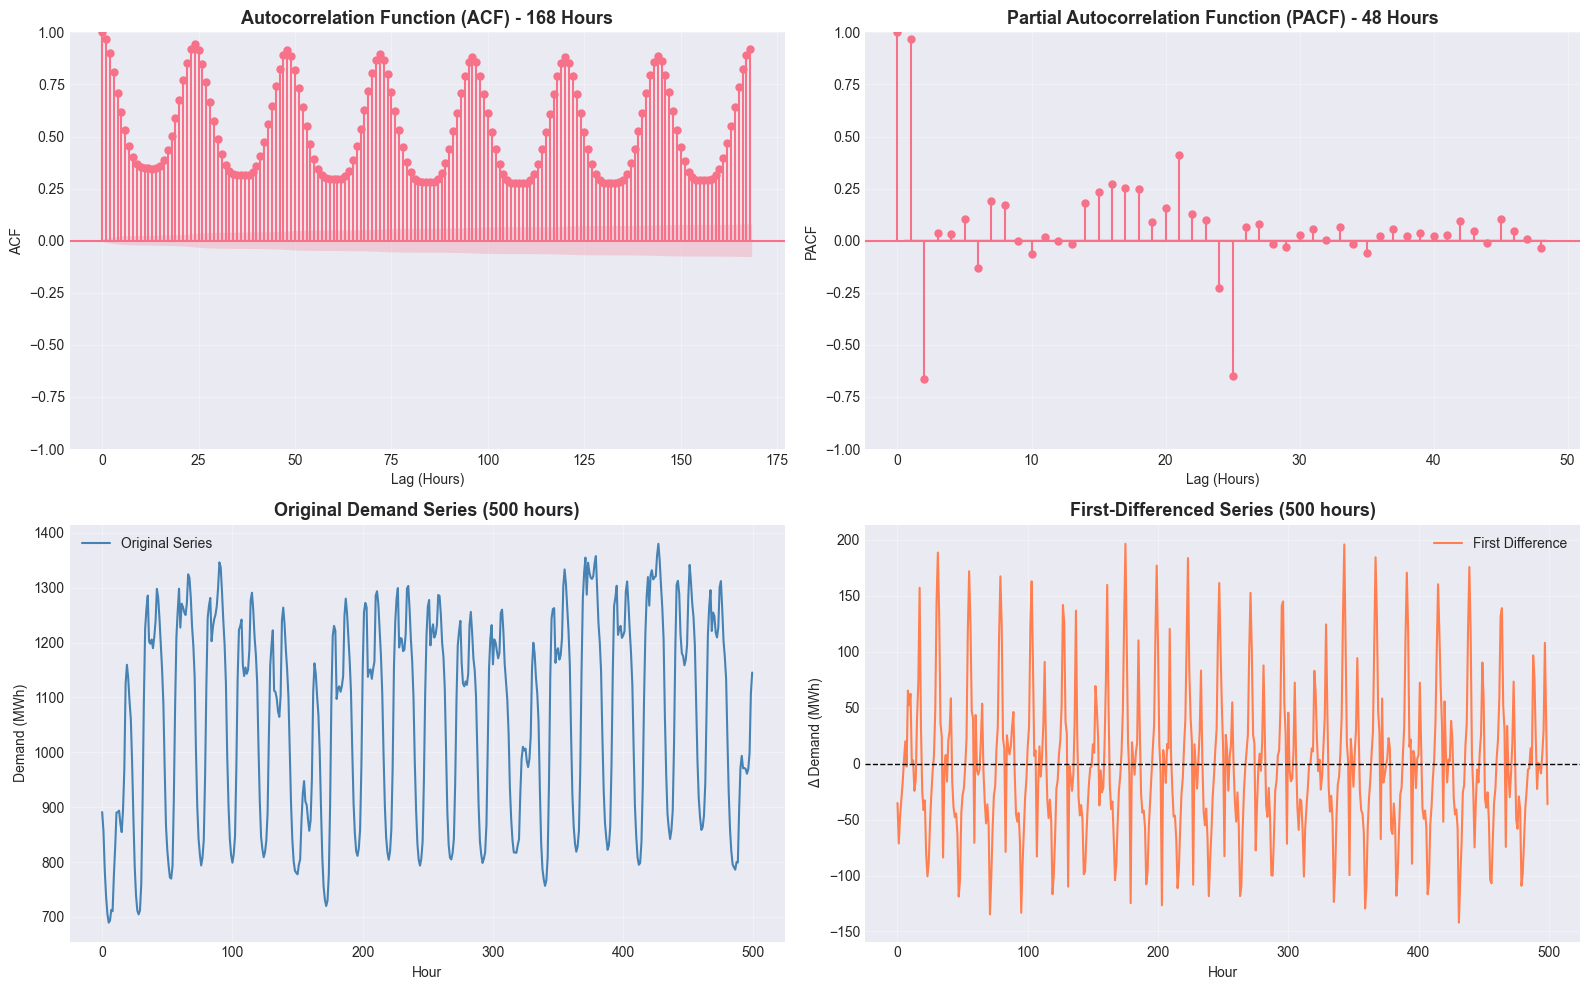

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\06_acf_pacf_stationarity.png


In [73]:
# ============================================================================
# SECTION 19B: VISUALIZATIONS - AUTOCORRELATION & STATIONARITY
# ============================================================================

print("[19B] Generating ACF/PACF and Stationarity Visualizations...")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

try:
    # Check if analysis section ran first
    if 'demand_series' not in dir() or 'demand_diff1' not in dir():
        print("⚠ Skipping visualization: Variables not defined. Run Section 19 analysis first")
    else:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # ACF plot
        plot_acf(demand_series, lags=168, ax=axes[0, 0], alpha=0.05)
        axes[0, 0].set_title('Autocorrelation Function (ACF) - 168 Hours', fontsize=13, fontweight='bold')
        axes[0, 0].set_xlabel('Lag (Hours)')
        axes[0, 0].set_ylabel('ACF')
        axes[0, 0].grid(alpha=0.3)

        # PACF plot
        plot_pacf(demand_series, lags=48, ax=axes[0, 1], alpha=0.05)
        axes[0, 1].set_title('Partial Autocorrelation Function (PACF) - 48 Hours', fontsize=13, fontweight='bold')
        axes[0, 1].set_xlabel('Lag (Hours)')
        axes[0, 1].set_ylabel('PACF')
        axes[0, 1].grid(alpha=0.3)

        # Original vs First Difference
        axes[1, 0].plot(range(min(500, len(demand_series))), demand_series[:min(500, len(demand_series))], 
                        linewidth=1.5, label='Original Series', color='steelblue')
        axes[1, 0].set_title('Original Demand Series (500 hours)', fontsize=13, fontweight='bold')
        axes[1, 0].set_xlabel('Hour')
        axes[1, 0].set_ylabel('Demand (MWh)')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)

        # First difference
        axes[1, 1].plot(range(min(500, len(demand_diff1))), demand_diff1[:min(500, len(demand_diff1))], 
                        linewidth=1.5, label='First Difference', color='coral')
        axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[1, 1].set_title('First-Differenced Series (500 hours)', fontsize=13, fontweight='bold')
        axes[1, 1].set_xlabel('Hour')
        axes[1, 1].set_ylabel('Δ Demand (MWh)')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(FIGURES_DIR / '06_acf_pacf_stationarity.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Figure saved: {FIGURES_DIR / '06_acf_pacf_stationarity.png'}")

except (NameError, Exception) as e:
    print(f"⚠ Skipping visualization: {e}")

In [74]:
# ============================================================================
# SECTION 20: TIME SERIES DECOMPOSITION
# ============================================================================

print("\n" + "="*80)
print("SECTION 20: TIME SERIES DECOMPOSITION")
print("="*80)

from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare time series with datetime index
print("\n[20.1] Preparing Time Series")
print("-"*80)
ts_data = base_df.set_index('time')['demand'].copy()
print(f"Total observations: {len(ts_data):,}")
print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Frequency: Hourly")

# Perform decomposition
print("\n[20.2] Seasonal Decomposition (Additive Model)")
print("-"*80)
print("Decomposing with period=24*7 (weekly seasonality)...")

decomposition = seasonal_decompose(ts_data, model='additive', period=24*7, extrapolate_trend='freq')

print("✓ Decomposition complete")

# Analyze components
print("\n[20.3] Component Statistics")
print("-"*80)

print("\nTrend Component:")
trend_values = decomposition.trend.dropna()
print(f"  Min:     {trend_values.min():,.2f} MWh")
print(f"  Max:     {trend_values.max():,.2f} MWh")
print(f"  Mean:    {trend_values.mean():,.2f} MWh")
print(f"  Std Dev: {trend_values.std():,.2f} MWh")

print("\nSeasonal Component:")
seasonal_values = decomposition.seasonal.dropna()
print(f"  Min:     {seasonal_values.min():,.2f} MWh")
print(f"  Max:     {seasonal_values.max():,.2f} MWh")
print(f"  Mean:    {seasonal_values.mean():,.2f} MWh")
print(f"  Std Dev: {seasonal_values.std():,.2f} MWh")
print(f"  Amplitude: {seasonal_values.max() - seasonal_values.min():,.2f} MWh")

print("\nResidual Component:")
residual_values = decomposition.resid.dropna()
print(f"  Min:     {residual_values.min():,.2f} MWh")
print(f"  Max:     {residual_values.max():,.2f} MWh")
print(f"  Mean:    {residual_values.mean():,.2f} MWh")
print(f"  Std Dev: {residual_values.std():,.2f} MWh")

# Component strength
print("\n[20.4] Component Strength")
print("-"*80)
seasonal_strength = 1 - (residual_values.var() / (seasonal_values + residual_values).var())
trend_strength = 1 - (residual_values.var() / (trend_values.dropna() + residual_values).var())

print(f"Seasonal Strength: {seasonal_strength:.4f} (0=weak, 1=strong)")
print(f"Trend Strength:    {trend_strength:.4f} (0=weak, 1=strong)")

# Variance decomposition
total_var = ts_data.var()
trend_var = trend_values.var()
seasonal_var = seasonal_values.var()
residual_var = residual_values.var()

print("\n[20.5] Variance Decomposition")
print("-"*80)
print(f"Total variance:    {total_var:,.2f}")
print(f"Trend variance:    {trend_var:,.2f} ({trend_var/total_var*100:.1f}%)")
print(f"Seasonal variance: {seasonal_var:,.2f} ({seasonal_var/total_var*100:.1f}%)")
print(f"Residual variance: {residual_var:,.2f} ({residual_var/total_var*100:.1f}%)")

print("\n✓ Time Series Decomposition Complete")



SECTION 20: TIME SERIES DECOMPOSITION

[20.1] Preparing Time Series
--------------------------------------------------------------------------------
Total observations: 67,200
Date range: 2018-01-01 00:00:00 to 2025-08-31 23:00:00
Frequency: Hourly

[20.2] Seasonal Decomposition (Additive Model)
--------------------------------------------------------------------------------
Decomposing with period=24*7 (weekly seasonality)...
✓ Decomposition complete

[20.3] Component Statistics
--------------------------------------------------------------------------------

Trend Component:
  Min:     709.10 MWh
  Max:     2,007.87 MWh
  Mean:    1,157.99 MWh
  Std Dev: 219.89 MWh

Seasonal Component:
  Min:     -359.22 MWh
  Max:     224.77 MWh
  Mean:    0.00 MWh
  Std Dev: 182.53 MWh
  Amplitude: 583.99 MWh

Residual Component:
  Min:     -484.32 MWh
  Max:     371.61 MWh
  Mean:    -0.09 MWh
  Std Dev: 82.91 MWh

[20.4] Component Strength
--------------------------------------------------------


[20B] Generating Decomposition Visualizations...


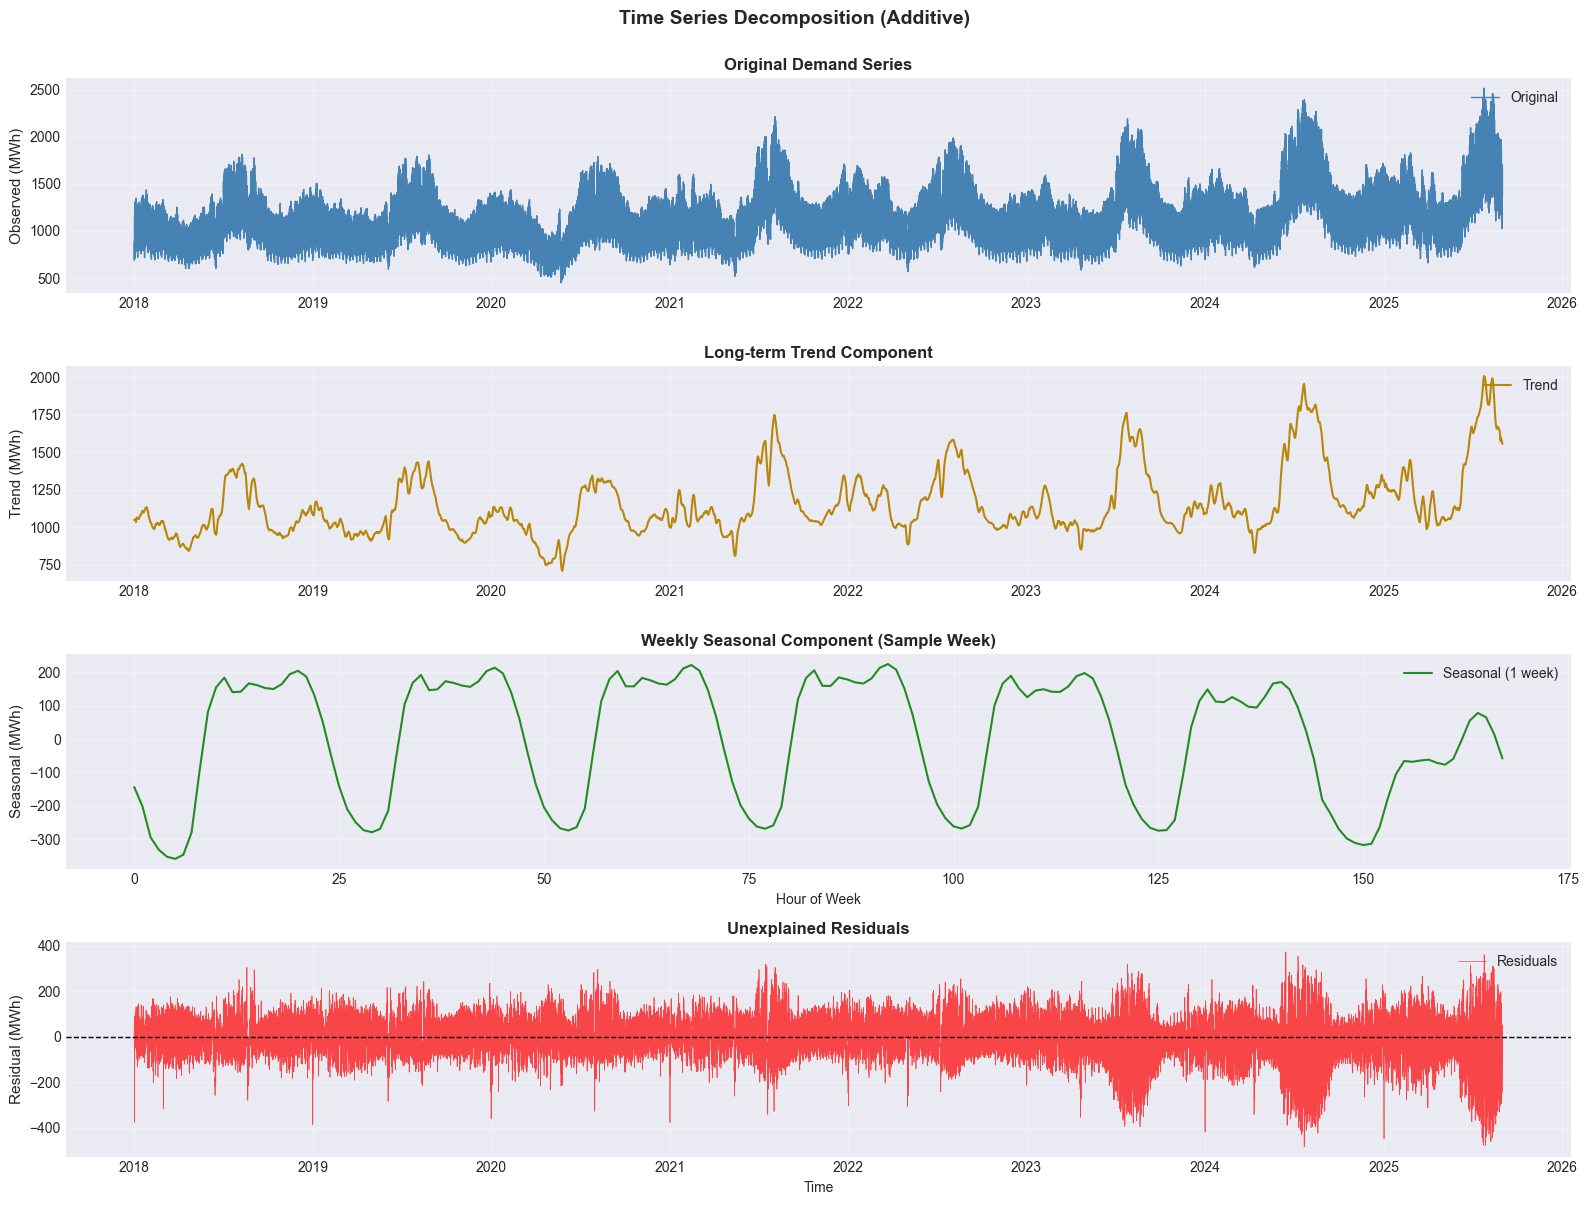

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\07_decomposition.png


In [75]:
# ============================================================================
# SECTION 20B: VISUALIZATIONS - TIME SERIES DECOMPOSITION
# ============================================================================

print("\n[20B] Generating Decomposition Visualizations...")

# Check if analysis section ran first
if 'decomposition' not in locals():
    print("⚠ Skipping visualization: Run Section 20 analysis first (Time Series Decomposition)")
else:
    try:
        fig, axes = plt.subplots(4, 1, figsize=(16, 12))
        fig.suptitle('Time Series Decomposition (Additive)', fontsize=14, fontweight='bold', y=1.00)

        # Original
        axes[0].plot(decomposition.observed.index, decomposition.observed.values, 
                     linewidth=1, color='steelblue', label='Original')
        axes[0].set_ylabel('Observed (MWh)', fontsize=11)
        axes[0].set_title('Original Demand Series', fontsize=12, fontweight='bold')
        axes[0].legend(loc='upper right')
        axes[0].grid(alpha=0.3)

        # Trend
        axes[1].plot(decomposition.trend.index, decomposition.trend.values, 
                     linewidth=1.5, color='darkgoldenrod', label='Trend')
        axes[1].set_ylabel('Trend (MWh)', fontsize=11)
        axes[1].set_title('Long-term Trend Component', fontsize=12, fontweight='bold')
        axes[1].legend(loc='upper right')
        axes[1].grid(alpha=0.3)

        # Seasonal (show one week for clarity)
        seasonal_sample = decomposition.seasonal.iloc[:24*7]
        x_sample = range(len(seasonal_sample))
        axes[2].plot(x_sample, seasonal_sample.values, 
                     linewidth=1.5, color='forestgreen', label='Seasonal (1 week)')
        axes[2].set_ylabel('Seasonal (MWh)', fontsize=11)
        axes[2].set_title('Weekly Seasonal Component (Sample Week)', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Hour of Week')
        axes[2].legend(loc='upper right')
        axes[2].grid(alpha=0.3)

        # Residual
        axes[3].plot(decomposition.resid.index, decomposition.resid.values, 
                     linewidth=0.5, color='red', alpha=0.7, label='Residuals')
        axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[3].set_ylabel('Residual (MWh)', fontsize=11)
        axes[3].set_title('Unexplained Residuals', fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Time')
        axes[3].legend(loc='upper right')
        axes[3].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(FIGURES_DIR / '07_decomposition.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Figure saved: {FIGURES_DIR / '07_decomposition.png'}")
    
    except Exception as e:
        print(f"⚠ Error: {e}")
        print("Ensure Section 20 (Time Series Decomposition) has been executed first")


[20B] Generating Decomposition Visualizations...


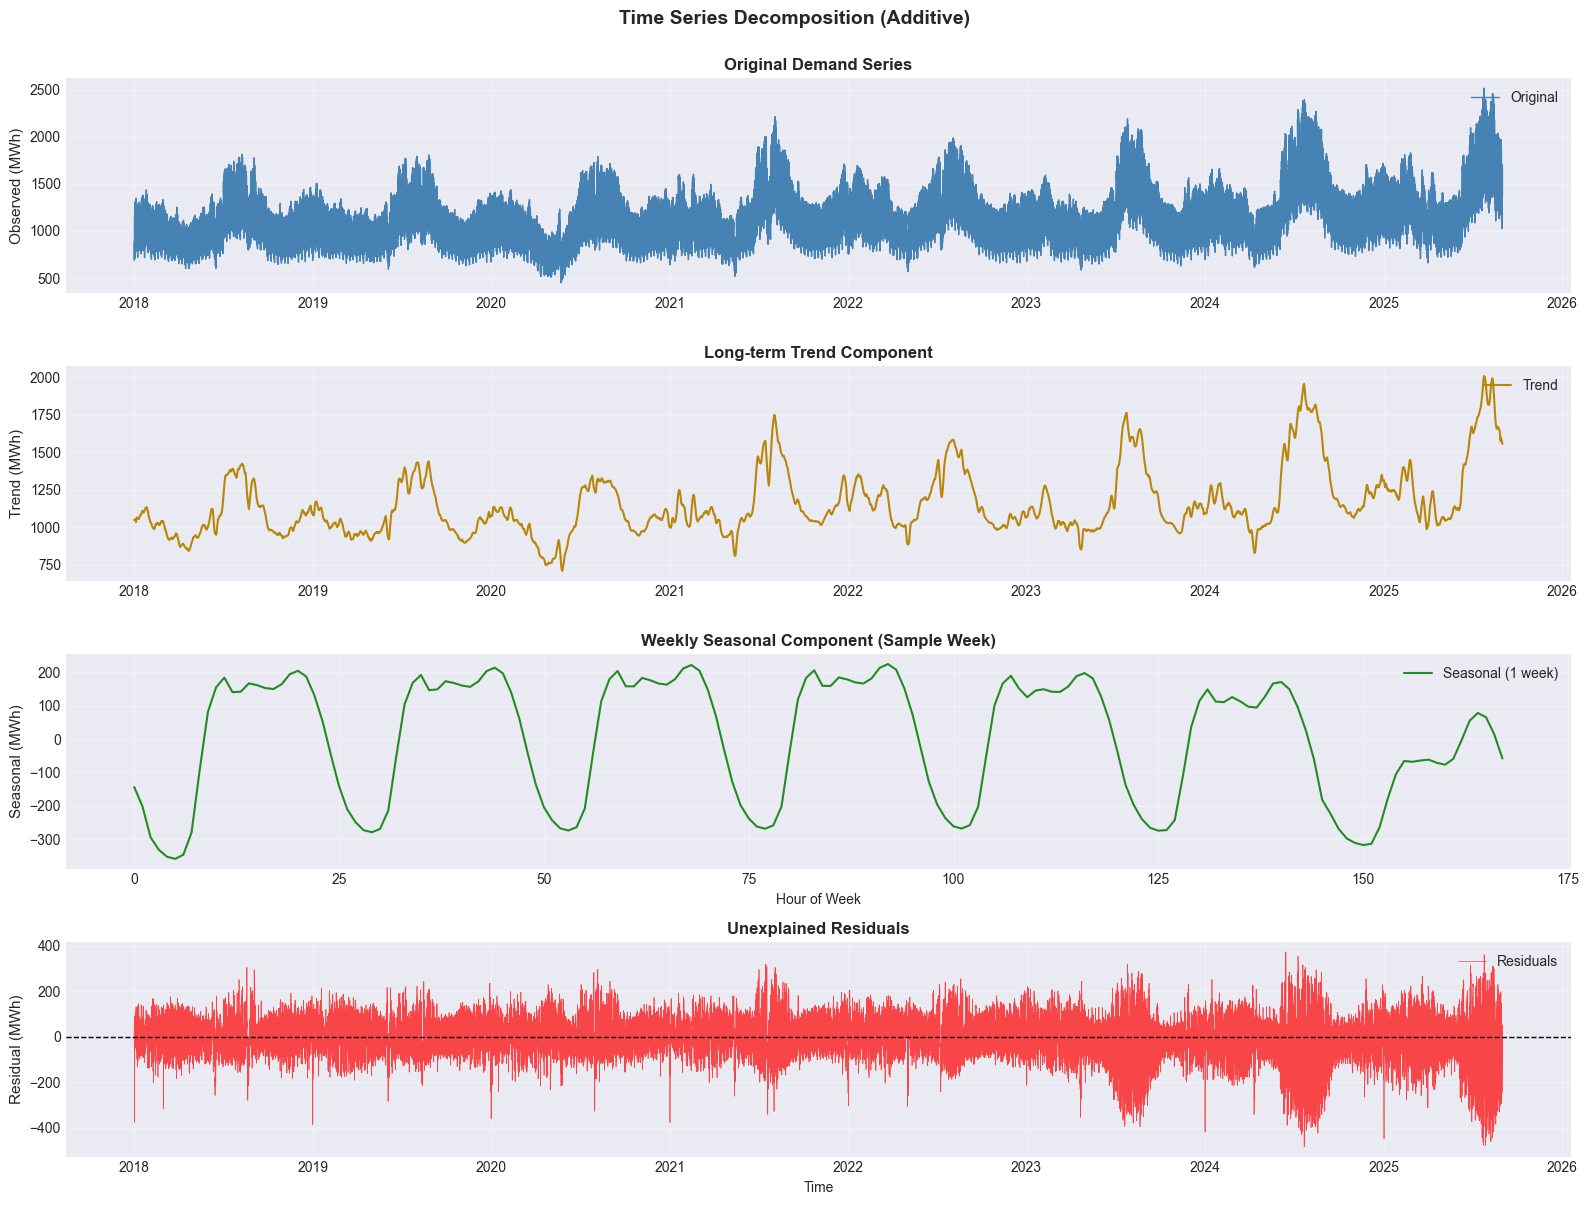

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\07_decomposition.png


In [76]:
# ============================================================================
# SECTION 20B: VISUALIZATIONS - TIME SERIES DECOMPOSITION
# ============================================================================

print("\n[20B] Generating Decomposition Visualizations...")

# Check if analysis section ran first
if 'decomposition' not in locals():
    print("⚠ Skipping visualization: Run Section 20 analysis first (Time Series Decomposition)")
else:
    try:
        fig, axes = plt.subplots(4, 1, figsize=(16, 12))
        fig.suptitle('Time Series Decomposition (Additive)', fontsize=14, fontweight='bold', y=1.00)

        # Original
        axes[0].plot(decomposition.observed.index, decomposition.observed.values, 
                     linewidth=1, color='steelblue', label='Original')
        axes[0].set_ylabel('Observed (MWh)', fontsize=11)
        axes[0].set_title('Original Demand Series', fontsize=12, fontweight='bold')
        axes[0].legend(loc='upper right')
        axes[0].grid(alpha=0.3)

        # Trend
        axes[1].plot(decomposition.trend.index, decomposition.trend.values, 
                     linewidth=1.5, color='darkgoldenrod', label='Trend')
        axes[1].set_ylabel('Trend (MWh)', fontsize=11)
        axes[1].set_title('Long-term Trend Component', fontsize=12, fontweight='bold')
        axes[1].legend(loc='upper right')
        axes[1].grid(alpha=0.3)

        # Seasonal (show one week for clarity)
        seasonal_sample = decomposition.seasonal.iloc[:24*7]
        x_sample = range(len(seasonal_sample))
        axes[2].plot(x_sample, seasonal_sample.values, 
                     linewidth=1.5, color='forestgreen', label='Seasonal (1 week)')
        axes[2].set_ylabel('Seasonal (MWh)', fontsize=11)
        axes[2].set_title('Weekly Seasonal Component (Sample Week)', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Hour of Week')
        axes[2].legend(loc='upper right')
        axes[2].grid(alpha=0.3)

        # Residual
        axes[3].plot(decomposition.resid.index, decomposition.resid.values, 
                     linewidth=0.5, color='red', alpha=0.7, label='Residuals')
        axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[3].set_ylabel('Residual (MWh)', fontsize=11)
        axes[3].set_title('Unexplained Residuals', fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Time')
        axes[3].legend(loc='upper right')
        axes[3].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(FIGURES_DIR / '07_decomposition.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Figure saved: {FIGURES_DIR / '07_decomposition.png'}")
    
    except Exception as e:
        print(f"⚠ Error: {e}")
        print("Ensure Section 20 (Time Series Decomposition) has been executed first")

In [85]:
# ============================================================================
# SECTION 22: MULTI-CITY WEATHER ANALYSIS & SPATIAL VARIATION
# ============================================================================

print("\n" + "="*80)
print("SECTION 22: MULTI-CITY WEATHER ANALYSIS & SPATIAL VARIATION")
print("="*80)

# Prepare city temperature data
print("\n[22.1] Temperature Data by City")
print("-"*80)

city_temps = {}
temp_col = 'temperature_2m' if 'temperature_2m' in base_df.columns else 'temperature'

for city in CITIES:
    if city in dfs:
        if temp_col in dfs[city].columns:
            city_temps[city] = dfs[city][temp_col]
            print(f"{city.upper():<10s}: {len(city_temps[city]):,} observations | "
                  f"Mean: {city_temps[city].mean():.2f}°C | "
                  f"Range: {city_temps[city].min():.2f} - {city_temps[city].max():.2f}°C")

print(f"\nTotal cities with temperature data: {len(city_temps)}")

# Inter-city correlation
if len(city_temps) >= 2:
    print("\n[22.2] Inter-City Temperature Correlations")
    print("-"*80)
    
    cities_list = list(city_temps.keys())
    for i, city1 in enumerate(cities_list):
        for city2 in cities_list[i+1:]:
            common_idx = city_temps[city1].index.intersection(city_temps[city2].index)
            if len(common_idx) > 0:
                corr = city_temps[city1].loc[common_idx].corr(city_temps[city2].loc[common_idx])
                print(f"{city1.upper():<8s} vs {city2.upper():<8s}: {corr:.4f}")

# Temperature variability
print("\n[22.3] Temperature Variability by City")
print("-"*80)
print(f"{'City':<10s} {'Std Dev':>10s} {'IQR':>10s} {'CV':>10s}")
print("-"*40)

for city, temps in city_temps.items():
    std_dev = temps.std()
    q75, q25 = temps.quantile(0.75), temps.quantile(0.25)
    iqr = q75 - q25
    cv = std_dev / temps.mean() if temps.mean() != 0 else 0
    print(f"{city.upper():<10s} {std_dev:>10.2f} {iqr:>10.2f} {cv:>10.4f}")

# Demand comparison by city
print("\n[22.4] Demand Characteristics by City")
print("-"*80)
print(f"{'City':<10s} {'Mean Demand':>15s} {'Peak Demand':>15s} {'Min Demand':>15s}")
print("-"*55)

for city in CITIES:
    if city in dfs and 'demand' in dfs[city].columns:
        mean_demand = dfs[city]['demand'].mean()
        peak_demand = dfs[city]['demand'].max()
        min_demand = dfs[city]['demand'].min()
        print(f"{city.upper():<10s} {mean_demand:>15,.0f} {peak_demand:>15,.0f} {min_demand:>15,.0f}")

# Temperature-Demand relationship by city
print("\n[22.5] Temperature-Demand Correlation by City")
print("-"*80)

for city in CITIES:
    if city in dfs and 'demand' in dfs[city].columns and temp_col in dfs[city].columns:
        corr = dfs[city][temp_col].corr(dfs[city]['demand'])
        print(f"{city.upper():<10s}: {corr:+.4f}")

print("\n✓ Multi-City Weather Analysis Complete")



SECTION 22: MULTI-CITY WEATHER ANALYSIS & SPATIAL VARIATION

[22.1] Temperature Data by City
--------------------------------------------------------------------------------
AYDIN     : 67,200 observations | Mean: 18.90°C | Range: -4.60 - 44.10°C
DENIZLI   : 67,200 observations | Mean: 18.41°C | Range: -11.70 - 44.70°C
MUGLA     : 67,200 observations | Mean: 16.18°C | Range: -5.20 - 40.30°C

Total cities with temperature data: 3

[22.2] Inter-City Temperature Correlations
--------------------------------------------------------------------------------
AYDIN    vs DENIZLI : 0.9757
AYDIN    vs MUGLA   : 0.9801
DENIZLI  vs MUGLA   : 0.9579

[22.3] Temperature Variability by City
--------------------------------------------------------------------------------
City          Std Dev        IQR         CV
----------------------------------------
AYDIN            9.40      14.50     0.4974
DENIZLI          9.88      15.60     0.5368
MUGLA            8.75      13.50     0.5404

[22.4] Demand C


[22B] Generating Multi-City Weather Visualizations...


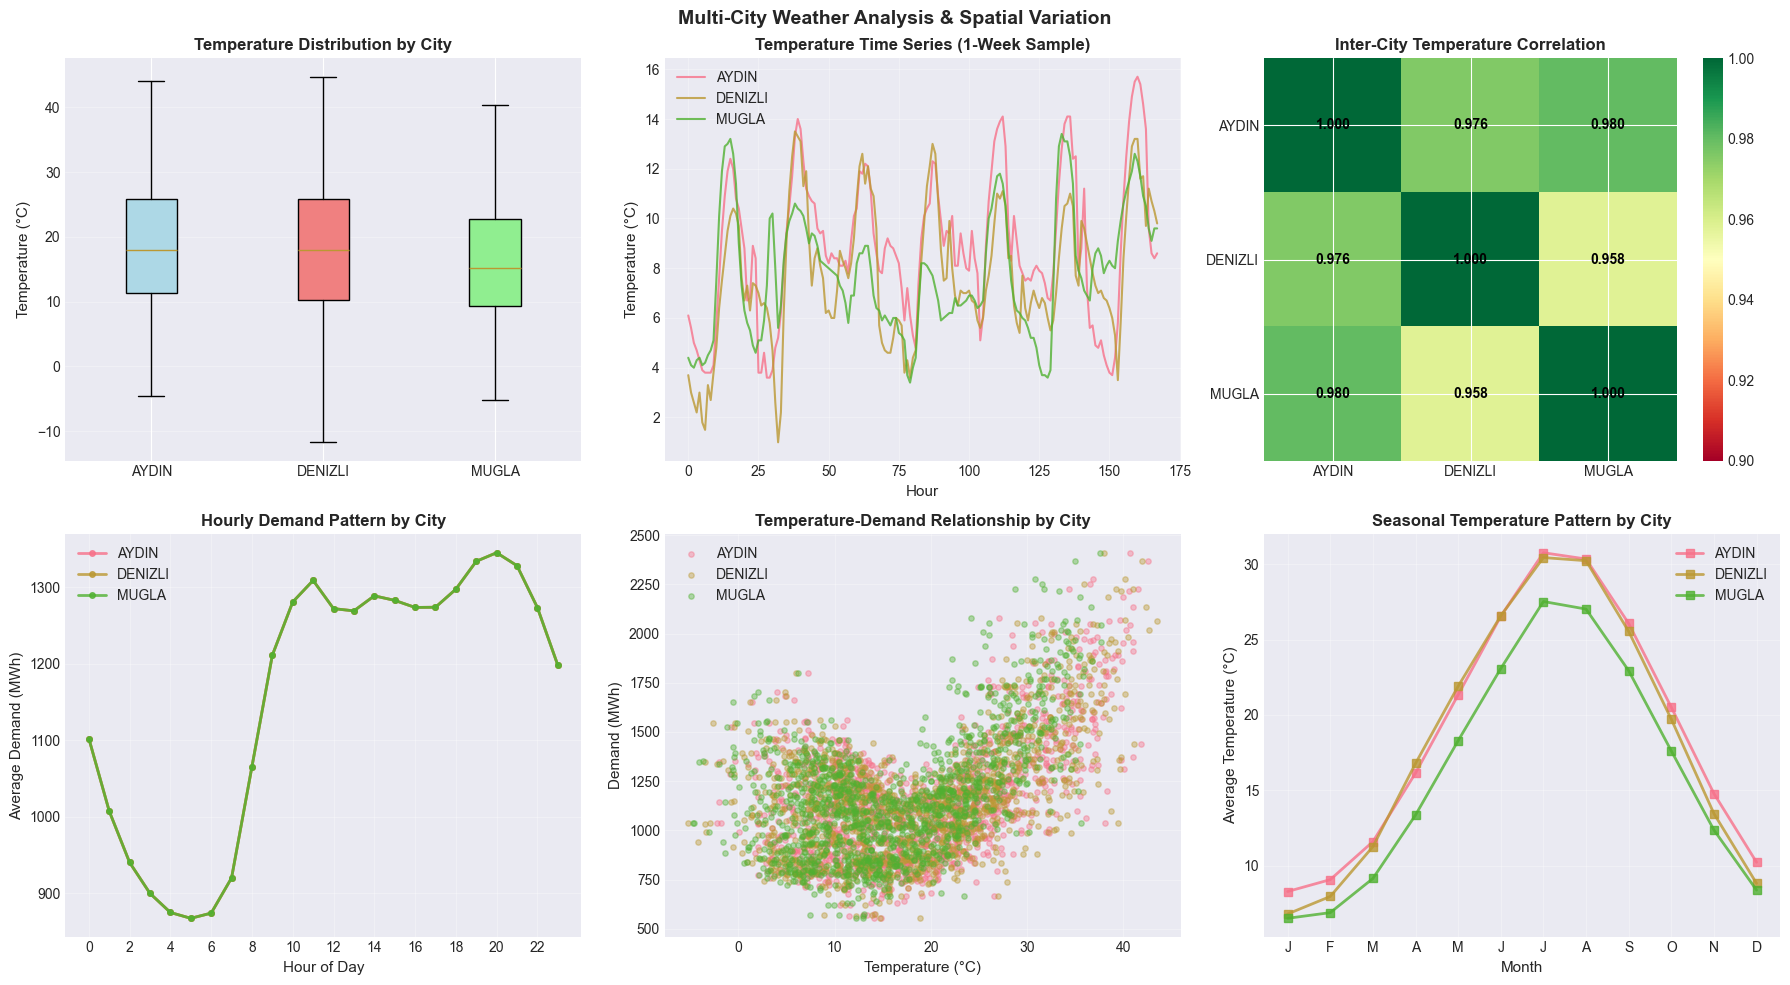

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\09_multi_city_weather.png


In [86]:
# ============================================================================
# SECTION 22B: VISUALIZATIONS - MULTI-CITY WEATHER ANALYSIS
# ============================================================================
print("\n[22B] Generating Multi-City Weather Visualizations...")

# Check if required variables exist
if 'dfs' not in dir() or 'CITIES' not in dir():
    print("⚠ Error: Required variables 'dfs' and 'CITIES' not found.")
    print("Ensure Section 22 (Multi-City Weather Analysis) has been executed first")
else:
    # Create city_temps dictionary from available data
    city_temps = {}
    for city in CITIES:
        if city in dfs:
            # Try to get temperature column (handle different naming conventions)
            if 'temperature_2m' in dfs[city].columns:
                city_temps[city] = dfs[city]['temperature_2m']
            elif 'temperature' in dfs[city].columns:
                city_temps[city] = dfs[city]['temperature']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Multi-City Weather Analysis & Spatial Variation', fontsize=14, fontweight='bold')
    
    # 1. Temperature distribution by city
    if len(city_temps) > 0:
        temp_data_list = [city_temps[city].values for city in city_temps.keys()]
        bp = axes[0, 0].boxplot(temp_data_list, tick_labels=[c.upper() for c in city_temps.keys()],
                                patch_artist=True)
        colors_box = ['lightblue', 'lightcoral', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors_box[:len(city_temps)]):
            patch.set_facecolor(color)
        axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11)
        axes[0, 0].set_title('Temperature Distribution by City', fontsize=12, fontweight='bold')
        axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Temperature time series by city (sample)
    if len(city_temps) > 0:
        sample_hours = min(7*24, len(demand_series))  # 1 week
        has_plots = False
        for city in city_temps.keys():
            if len(city_temps[city]) >= sample_hours:
                axes[0, 1].plot(range(sample_hours), city_temps[city].iloc[:sample_hours].values,
                               label=city.upper(), linewidth=1.5, alpha=0.8)
                has_plots = True
        axes[0, 1].set_xlabel('Hour', fontsize=11)
        axes[0, 1].set_ylabel('Temperature (°C)', fontsize=11)
        axes[0, 1].set_title('Temperature Time Series (1-Week Sample)', fontsize=12, fontweight='bold')
        if has_plots:
            axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(alpha=0.3)

    # 3. Temperature correlation matrix between cities
    if len(city_temps) >= 2:
        cities_list = list(city_temps.keys())
        corr_matrix_cities = np.zeros((len(cities_list), len(cities_list)))
        for i, city1 in enumerate(cities_list):
            for j, city2 in enumerate(cities_list):
                # Get the series properly
                series1 = city_temps[city1]
                series2 = city_temps[city2]
                common_idx = series1.index.intersection(series2.index)
                if len(common_idx) > 0:
                    corr_matrix_cities[i, j] = series1.loc[common_idx].corr(series2.loc[common_idx])
                else:
                    corr_matrix_cities[i, j] = 0.0
        im = axes[0, 2].imshow(corr_matrix_cities, cmap='RdYlGn', vmin=0.9, vmax=1.0, aspect='auto')
        axes[0, 2].set_xticks(range(len(cities_list)))
        axes[0, 2].set_yticks(range(len(cities_list)))
        axes[0, 2].set_xticklabels([c.upper() for c in cities_list])
        axes[0, 2].set_yticklabels([c.upper() for c in cities_list])
        axes[0, 2].set_title('Inter-City Temperature Correlation', fontsize=12, fontweight='bold')
        # Add correlation values
        for i in range(len(cities_list)):
            for j in range(len(cities_list)):
                axes[0, 2].text(j, i, f'{corr_matrix_cities[i, j]:.3f}',
                               ha="center", va="center", color="black", fontsize=10, fontweight='bold')
        plt.colorbar(im, ax=axes[0, 2])
    
    # 4. Hourly demand patterns by city
    if len(CITIES) > 0:
        has_plots = False
        for city in CITIES:
            if city in dfs and 'hour' in dfs[city].columns and 'demand' in dfs[city].columns:
                hourly_demand = dfs[city].groupby('hour')['demand'].mean()
                axes[1, 0].plot(hourly_demand.index, hourly_demand.values,
                               label=city.upper(), linewidth=2, marker='o', markersize=4, alpha=0.8)
                has_plots = True
        axes[1, 0].set_xlabel('Hour of Day', fontsize=11)
        axes[1, 0].set_ylabel('Average Demand (MWh)', fontsize=11)
        axes[1, 0].set_title('Hourly Demand Pattern by City', fontsize=12, fontweight='bold')
        if has_plots:
            axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(alpha=0.3)
        axes[1, 0].set_xticks(range(0, 24, 2))
    
    # 5. Temperature vs Demand by city
    if len(city_temps) > 0:
        has_plots = False
        for idx, city in enumerate(city_temps.keys()):
            if city in dfs and 'demand' in dfs[city].columns:
                sample_indices = np.arange(0, len(dfs[city]), 50)
                axes[1, 1].scatter(city_temps[city].iloc[sample_indices],
                                 dfs[city]['demand'].iloc[sample_indices],
                                 alpha=0.4, s=15, label=city.upper())
                has_plots = True
        axes[1, 1].set_xlabel('Temperature (°C)', fontsize=11)
        axes[1, 1].set_ylabel('Demand (MWh)', fontsize=11)
        axes[1, 1].set_title('Temperature-Demand Relationship by City', fontsize=12, fontweight='bold')
        if has_plots:
            axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(alpha=0.3)

    # 6. Monthly temperature pattern by city
    if len(city_temps) > 0:
        has_plots = False
        for city in city_temps.keys():
            if city in dfs and 'time' in dfs[city].columns:
                if 'temperature_2m' in dfs[city].columns:
                    monthly_avg = dfs[city].groupby(dfs[city]['time'].dt.month)['temperature_2m'].mean()
                elif 'temperature' in dfs[city].columns:
                    monthly_avg = dfs[city].groupby(dfs[city]['time'].dt.month)['temperature'].mean()
                else:
                    continue
                
                axes[1, 2].plot(monthly_avg.index, monthly_avg.values,
                               label=city.upper(), linewidth=2, marker='s', markersize=6, alpha=0.8)
                has_plots = True
        
        axes[1, 2].set_xlabel('Month', fontsize=11)
        axes[1, 2].set_ylabel('Average Temperature (°C)', fontsize=11)
        axes[1, 2].set_title('Seasonal Temperature Pattern by City', fontsize=12, fontweight='bold')
        axes[1, 2].set_xticks(range(1, 13))
        axes[1, 2].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        if has_plots:
            axes[1, 2].legend(fontsize=10)
        axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '09_multi_city_weather.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Figure saved: {FIGURES_DIR / '09_multi_city_weather.png'}")

In [78]:
# ============================================================================
# SECTION 21: COMPREHENSIVE FEATURE CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 21: COMPREHENSIVE FEATURE CORRELATION ANALYSIS")
print("="*80)

# 21.1 Compute all correlations with demand
print("\n[21.1] Demand Correlations with All Numeric Features")
print("-"*80)

numeric_cols = base_df.select_dtypes(include=[np.number]).columns
demand_correlations = {}

for col in numeric_cols:
    if col != 'demand' and base_df[col].notna().sum() > 0:
        if base_df[col].std() > 0:
            corr = base_df[col].corr(base_df['demand'])
            if not np.isnan(corr):
                demand_correlations[col] = corr

# Sort by absolute correlation
sorted_corr = sorted(demand_correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print(f"\nTop 20 Features Correlated with Demand:")
print(f"{'Feature':<40s} {'Correlation':>15s} {'Strength':>15s}")
print("-"*70)

for col, corr in sorted_corr[:20]:
    strength = "Very Strong" if abs(corr) > 0.7 else "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
    print(f"{col:<40s} {corr:>15.4f} {strength:>15s}")

# 21.2 Temperature-related features analysis
print("\n[21.2] Temperature Interaction Effects")
print("-"*80)

temp_col = 'temperature_2m' if 'temperature_2m' in base_df.columns else 'temperature'
if temp_col in base_df.columns:
    # Linear correlation
    linear_corr = base_df[temp_col].corr(base_df['demand'])
    
    # Polynomial fit (2nd degree)
    z = np.polyfit(base_df[temp_col].dropna(), 
                   base_df.loc[base_df[temp_col].notna(), 'demand'], 2)
    p = np.poly1d(z)
    demand_pred = p(base_df[temp_col].dropna())
    ss_res = np.sum((base_df.loc[base_df[temp_col].notna(), 'demand'] - demand_pred)**2)
    ss_tot = np.sum((base_df.loc[base_df[temp_col].notna(), 'demand'] - 
                     base_df.loc[base_df[temp_col].notna(), 'demand'].mean())**2)
    r2_poly = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    print(f"Linear Correlation:  {linear_corr:+.4f}")
    print(f"Polynomial R² (deg 2): {r2_poly:.4f}")
    print(f"Non-linearity improvement: {(r2_poly - linear_corr**2) * 100:.2f}%")
    
    # Find optimal (minimum demand) temperature
    temp_range = np.linspace(base_df[temp_col].min(), base_df[temp_col].max(), 1000)
    optimal_temp = temp_range[np.argmin(p(temp_range))]
    print(f"Optimal Temperature (min demand): {optimal_temp:.1f}°C")

# 21.3 Category-wise feature breakdown
print("\n[21.3] Correlations by Feature Category")
print("-"*80)

feature_categories = {
    'Time Features': [col for col in ['hour', 'day_of_week', 'month', 'day_of_year'] 
                      if col in base_df.columns],
    'Binary Flags': [col for col in base_df.columns 
                     if base_df[col].dtype in ['int64', 'int32'] and 
                     base_df[col].max() <= 1 and col not in ['hour', 'day_of_week']],
    'Temperature': [col for col in base_df.columns if 'temp' in col.lower()],
    'Weather': [col for col in base_df.columns 
                if any(x in col.lower() for x in ['humidity', 'wind', 'precipitation', 'cloud', 'pressure'])],
    'Solar': [col for col in base_df.columns 
              if any(x in col.lower() for x in ['solar', 'radiation', 'sunshine'])],
}

for category, cols in feature_categories.items():
    valid_cols = [col for col in cols if col in demand_correlations]
    if valid_cols:
        print(f"\n{category}:")
        for col in valid_cols[:5]:
            print(f"  {col:<35s} {demand_correlations[col]:>8.4f}")

print("\n✓ Correlation analysis complete")



SECTION 21: COMPREHENSIVE FEATURE CORRELATION ANALYSIS

[21.1] Demand Correlations with All Numeric Features
--------------------------------------------------------------------------------

Top 20 Features Correlated with Demand:
Feature                                      Correlation        Strength
----------------------------------------------------------------------
cooling_degree_hours_static                       0.6789          Strong
cooling_degree_hours_adaptive                     0.6677          Strong
cooling_degree_hours_seasonal                     0.6602          Strong
adaptive_cooling_advantage                        0.5886          Strong
seasonal_cooling_advantage                       -0.5832          Strong
is_school_season                                 -0.5361          Strong
temperature_lag_24h                               0.5124          Strong
temperature_lag_1h                                0.5107          Strong
heat_index                              


[21B] Generating Feature Correlation Visualizations...


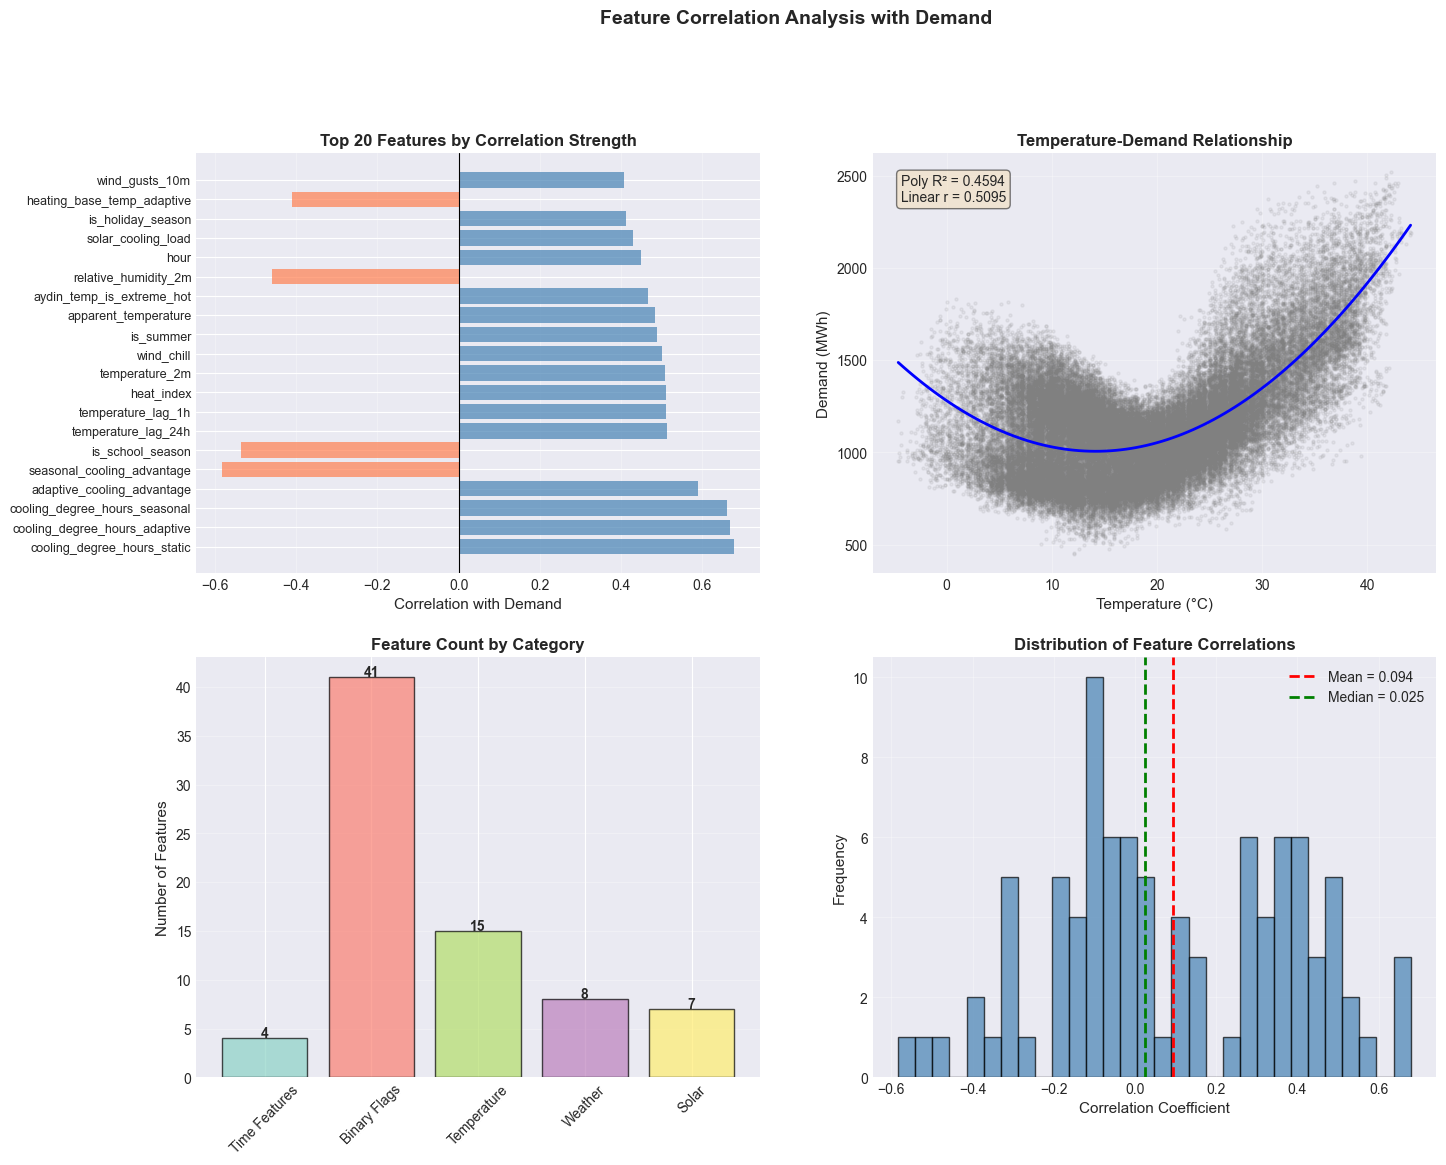

In [79]:
# ============================================================================
# SECTION 21B: VISUALIZATIONS - FEATURE CORRELATIONS
# ============================================================================

print("\n[21B] Generating Feature Correlation Visualizations...")

try:
    # Verify required variables exist
    if 'sorted_corr' not in globals():
        raise NameError("sorted_corr is not defined. Run Section 21 (Feature Correlation Analysis) first.")
    if 'demand_correlations' not in globals():
        raise NameError("demand_correlations is not defined. Run Section 21 (Feature Correlation Analysis) first.")
    if 'feature_categories' not in globals():
        raise NameError("feature_categories is not defined. Run Section 21 (Feature Correlation Analysis) first.")
    
    _ = sorted_corr
    _ = demand_correlations
    _ = feature_categories
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Correlation Analysis with Demand', fontsize=14, fontweight='bold', y=1.00)

    # 1. Top 20 correlations bar chart
    ax = axes[0, 0]
    top_n = min(20, len(sorted_corr))
    sorted_corr_plot = sorted_corr[:top_n]
    features = [f[0] for f in sorted_corr_plot]
    corr_vals = [f[1] for f in sorted_corr_plot]
    colors = ['steelblue' if c >= 0 else 'coral' for c in corr_vals]
    ax.barh(range(len(features)), corr_vals, color=colors, alpha=0.7)
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features, fontsize=9)
    ax.set_xlabel('Correlation with Demand', fontsize=11)
    ax.set_title('Top 20 Features by Correlation Strength', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

    # 2. Temperature polynomial fit
    ax = axes[0, 1]
    try:
        # Verify temperature analysis variables exist
        _ = p
        _ = linear_corr
        _ = r2_poly
        
        temp_col = 'temperature_2m' if 'temperature_2m' in base_df.columns else None
        if temp_col and temp_col in base_df.columns:
            x_range = np.linspace(base_df[temp_col].min(), base_df[temp_col].max(), 100)
            y_poly = p(x_range)
            ax.scatter(base_df[temp_col], base_df['demand'], alpha=0.1, s=5, color='gray')
            ax.plot(x_range, y_poly, 'b-', linewidth=2, label='Polynomial Fit')
            ax.text(0.05, 0.95, f'Poly R² = {r2_poly:.4f}\nLinear r = {linear_corr:.4f}',
                   transform=ax.transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            ax.set_xlabel('Temperature (°C)', fontsize=11)
            ax.set_ylabel('Demand (MWh)', fontsize=11)
            ax.set_title('Temperature-Demand Relationship', fontsize=12, fontweight='bold')
            ax.grid(alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Temperature column not found',
                   ha='center', va='center', transform=ax.transAxes)
    except:
        ax.text(0.5, 0.5, 'Temperature analysis not available',
               ha='center', va='center', transform=ax.transAxes)

    # 3. Feature categories
    ax = axes[1, 0]
    try:
        categories = list(feature_categories.keys())
        cat_counts = [len(v) for v in feature_categories.values()]
        colors_cat = plt.cm.Set3(np.linspace(0, 1, len(categories)))
        ax.bar(categories, cat_counts, color=colors_cat, alpha=0.7, edgecolor='black')
        ax.set_ylabel('Number of Features', fontsize=11)
        ax.set_title('Feature Count by Category', fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        for i, v in enumerate(cat_counts):
            ax.text(i, v + 0.1, str(v), ha='center', fontsize=10, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    except:
        ax.text(0.5, 0.5, 'Feature categories not available',
               ha='center', va='center', transform=ax.transAxes)

    # 4. Demand correlation distribution
    ax = axes[1, 1]
    try:
        all_corrs = list(demand_correlations.values())
        ax.hist(all_corrs, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax.axvline(x=np.mean(all_corrs), color='red', linestyle='--', linewidth=2, 
                  label=f'Mean = {np.mean(all_corrs):.3f}')
        ax.axvline(x=np.median(all_corrs), color='green', linestyle='--', linewidth=2,
                  label=f'Median = {np.median(all_corrs):.3f}')
        ax.set_xlabel('Correlation Coefficient', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title('Distribution of Feature Correlations', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    except:
        ax.text(0.5, 0.5, 'Demand correlations not available',
               ha='center', va='center', transform=ax.transAxes)
except NameError as e:
    print(f'Error in Feature Correlation Visualizations: {e}')
    print("⚠ Skipping visualization: Required variables not defined")
    print(f"   Error: {e}")
    print("   Run Section 21 (Feature Correlation Analysis) first to define:")
    print("   - sorted_corr")
    print("   - demand_correlations")
    print("   - feature_categories")
    print("   - p (polynomial fit)")
    print("   - linear_corr, r2_poly")
except Exception as e:
    print(f"⚠ Error generating visualization: {e}")
    import traceback
    traceback.print_exc()
    print(f"✓ Figure saved: {FIGURES_DIR / '08_feature_correlations.png'}")

except NameError:
    print("⚠ Skipping visualization: Variables not defined")
    print("Run cell 26 (Section 21: Feature Correlation Analysis) first")
except Exception as e:
    print(f"⚠ Error generating visualization: {e}")

In [80]:
# ============================================================================
# SECTION 21C: JOINT DISTRIBUTION & MULTIVARIATE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 21C: JOINT DISTRIBUTION & MULTIVARIATE ANALYSIS")
print("="*80)

# Select key variables for joint distribution analysis
key_vars = ['demand', 'temperature_2m', 'hour']
available_vars = [v for v in key_vars if v in base_df.columns]

print(f"\n[21C.1] Selected Variables for Joint Distribution Analysis")
print("-"*80)
for var in available_vars:
    data = base_df[var].dropna()
    print(f"{var:.<30s} n={len(data):,} | μ={data.mean():.2f} | σ={data.std():.2f} | range=[{data.min():.1f}, {data.max():.1f}]")

# Prepare data for joint distribution (sample for performance)
sample_size = min(5000, len(base_df))
sample_indices = np.random.choice(len(base_df), sample_size, replace=False)

temp_col = 'temperature_2m' if 'temperature_2m' in base_df.columns else 'temperature'
if 'hour' not in base_df.columns:
    base_df['hour'] = pd.to_datetime(base_df['time']).dt.hour

joint_data = base_df.iloc[sample_indices][['demand', temp_col, 'hour']].dropna()

print(f"\n[21C.2] Sample Size for Analysis")
print("-"*80)
print(f"Sample size: {len(joint_data):,} observations")
print(f"Correlation matrix:")
print(joint_data.corr().round(4))

print(f"\n✓ Joint Distribution Analysis Ready")


SECTION 21C: JOINT DISTRIBUTION & MULTIVARIATE ANALYSIS

[21C.1] Selected Variables for Joint Distribution Analysis
--------------------------------------------------------------------------------
demand........................ n=67,200 | μ=1157.91 | σ=299.25 | range=[448.7, 2517.1]
temperature_2m................ n=67,200 | μ=18.90 | σ=9.40 | range=[-4.6, 44.1]
hour.......................... n=67,200 | μ=11.50 | σ=6.92 | range=[0.0, 23.0]

[21C.2] Sample Size for Analysis
--------------------------------------------------------------------------------
Sample size: 5,000 observations
Correlation matrix:
                demand  temperature_2m    hour
demand          1.0000          0.5192  0.4549
temperature_2m  0.5192          1.0000  0.2162
hour            0.4549          0.2162  1.0000

✓ Joint Distribution Analysis Ready



[21C.3] Generating Joint Distribution Visualizations...


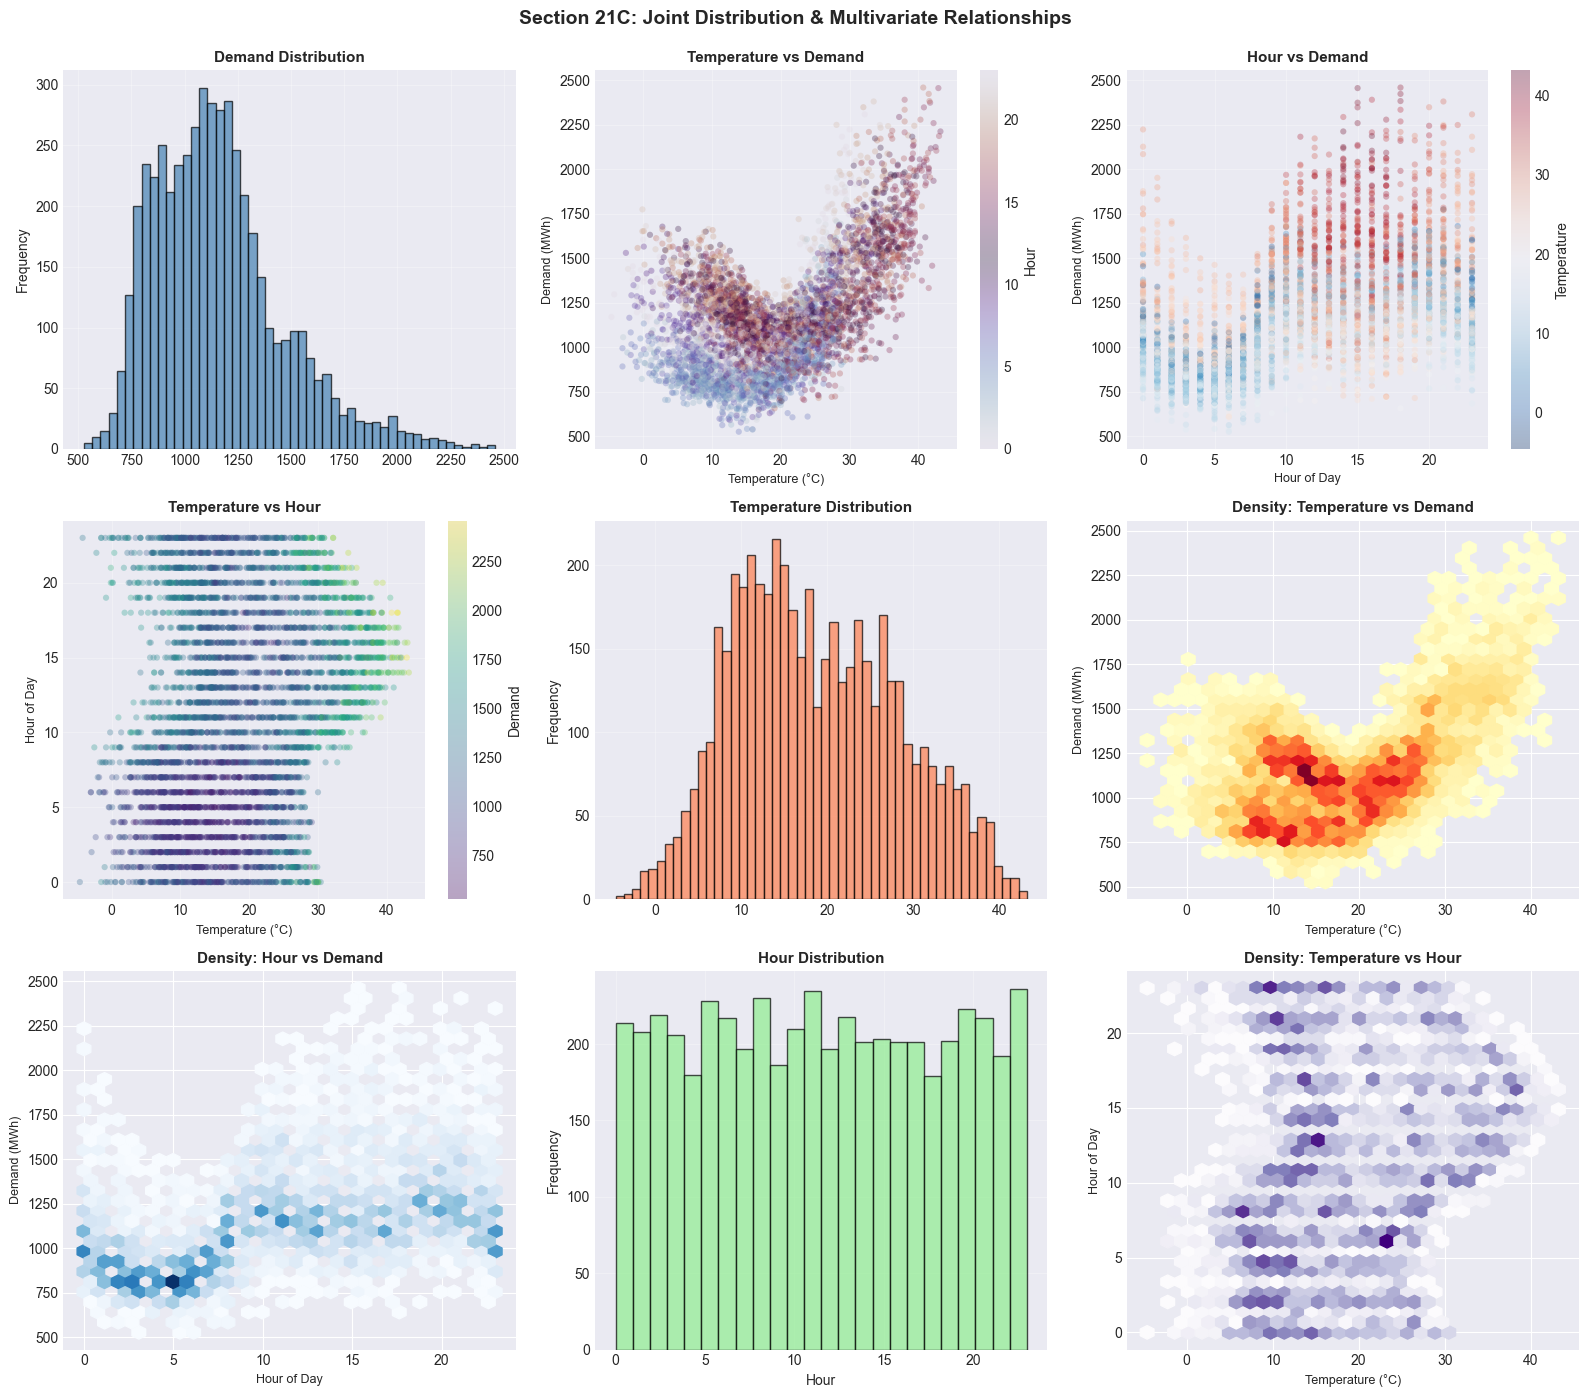

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\21c_joint_distributions.png


In [81]:
# ============================================================================
# SECTION 21C: VISUALIZATION - JOINT DISTRIBUTIONS & MULTIVARIATE RELATIONSHIPS
# ============================================================================

print("\n[21C.3] Generating Joint Distribution Visualizations...")

try:
    # Create corner plot style visualization
    fig = plt.figure(figsize=(16, 14))
    
    # Define subplots in a 3x3 grid (corner plot format)
    # Diagonal: Marginal distributions
    # Upper triangle: Scatter plots
    # Lower triangle: Density plots
    
    variables = ['demand', temp_col, 'hour']
    n_vars = len(variables)
    
    # Create grid
    fig.suptitle('Section 21C: Joint Distribution & Multivariate Relationships', 
                fontsize=14, fontweight='bold', y=0.995)
    
    # Define axes positions
    plot_data = joint_data[variables].values
    
    # [21C.1] Demand Distribution (Marginal)
    ax1 = plt.subplot(3, 3, 1)
    ax1.hist(joint_data['demand'].dropna(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.set_title('Demand Distribution', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # [21C.2] Temperature vs Demand (2D scatter)
    ax2 = plt.subplot(3, 3, 2)
    scatter = ax2.scatter(joint_data[temp_col], joint_data['demand'], alpha=0.3, s=20, c=joint_data['hour'], 
                         cmap='twilight', edgecolors='none')
    ax2.set_xlabel('Temperature (°C)', fontsize=9)
    ax2.set_ylabel('Demand (MWh)', fontsize=9)
    ax2.set_title('Temperature vs Demand', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Hour')
    
    # [21C.3] Hour vs Demand (2D scatter)
    ax3 = plt.subplot(3, 3, 3)
    scatter = ax3.scatter(joint_data['hour'], joint_data['demand'], alpha=0.3, s=20, c=joint_data[temp_col], 
                         cmap='RdBu_r', edgecolors='none')
    ax3.set_xlabel('Hour of Day', fontsize=9)
    ax3.set_ylabel('Demand (MWh)', fontsize=9)
    ax3.set_title('Hour vs Demand', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Temperature')
    
    # [21C.4] Hour vs Temperature (2D scatter)
    ax4 = plt.subplot(3, 3, 4)
    scatter = ax4.scatter(joint_data[temp_col], joint_data['hour'], alpha=0.3, s=20, c=joint_data['demand'], 
                         cmap='viridis', edgecolors='none')
    ax4.set_xlabel('Temperature (°C)', fontsize=9)
    ax4.set_ylabel('Hour of Day', fontsize=9)
    ax4.set_title('Temperature vs Hour', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Demand')
    
    # [21C.5] Temperature Distribution (Marginal)
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(joint_data[temp_col].dropna(), bins=50, color='coral', alpha=0.7, edgecolor='black')
    ax5.set_ylabel('Frequency', fontsize=10)
    ax5.set_title('Temperature Distribution', fontsize=11, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # [21C.6] 2D Density: Temperature vs Demand
    ax6 = plt.subplot(3, 3, 6)
    ax6.hexbin(joint_data[temp_col], joint_data['demand'], gridsize=30, cmap='YlOrRd', mincnt=1)
    ax6.set_xlabel('Temperature (°C)', fontsize=9)
    ax6.set_ylabel('Demand (MWh)', fontsize=9)
    ax6.set_title('Density: Temperature vs Demand', fontsize=11, fontweight='bold')
    
    # [21C.7] 2D Density: Hour vs Demand
    ax7 = plt.subplot(3, 3, 7)
    ax7.hexbin(joint_data['hour'], joint_data['demand'], gridsize=30, cmap='Blues', mincnt=1)
    ax7.set_xlabel('Hour of Day', fontsize=9)
    ax7.set_ylabel('Demand (MWh)', fontsize=9)
    ax7.set_title('Density: Hour vs Demand', fontsize=11, fontweight='bold')
    
    # [21C.8] Hour Distribution (Marginal)
    ax8 = plt.subplot(3, 3, 8)
    ax8.hist(joint_data['hour'].dropna(), bins=24, color='lightgreen', alpha=0.7, edgecolor='black')
    ax8.set_xlabel('Hour', fontsize=10)
    ax8.set_ylabel('Frequency', fontsize=10)
    ax8.set_title('Hour Distribution', fontsize=11, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    
    # [21C.9] 2D Density: Temperature vs Hour
    ax9 = plt.subplot(3, 3, 9)
    ax9.hexbin(joint_data[temp_col], joint_data['hour'], gridsize=30, cmap='Purples', mincnt=1)
    ax9.set_xlabel('Temperature (°C)', fontsize=9)
    ax9.set_ylabel('Hour of Day', fontsize=9)
    ax9.set_title('Density: Temperature vs Hour', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '21c_joint_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Figure saved: {FIGURES_DIR / '21c_joint_distributions.png'}")
    
except Exception as e:
    print(f"⚠ Error generating visualization: {e}")
    import traceback
    traceback.print_exc()


[22B] Generating Multi-City Weather Visualizations...


C:\Users\begum.orhan\AppData\Local\Temp\ipykernel_18628\2208026914.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


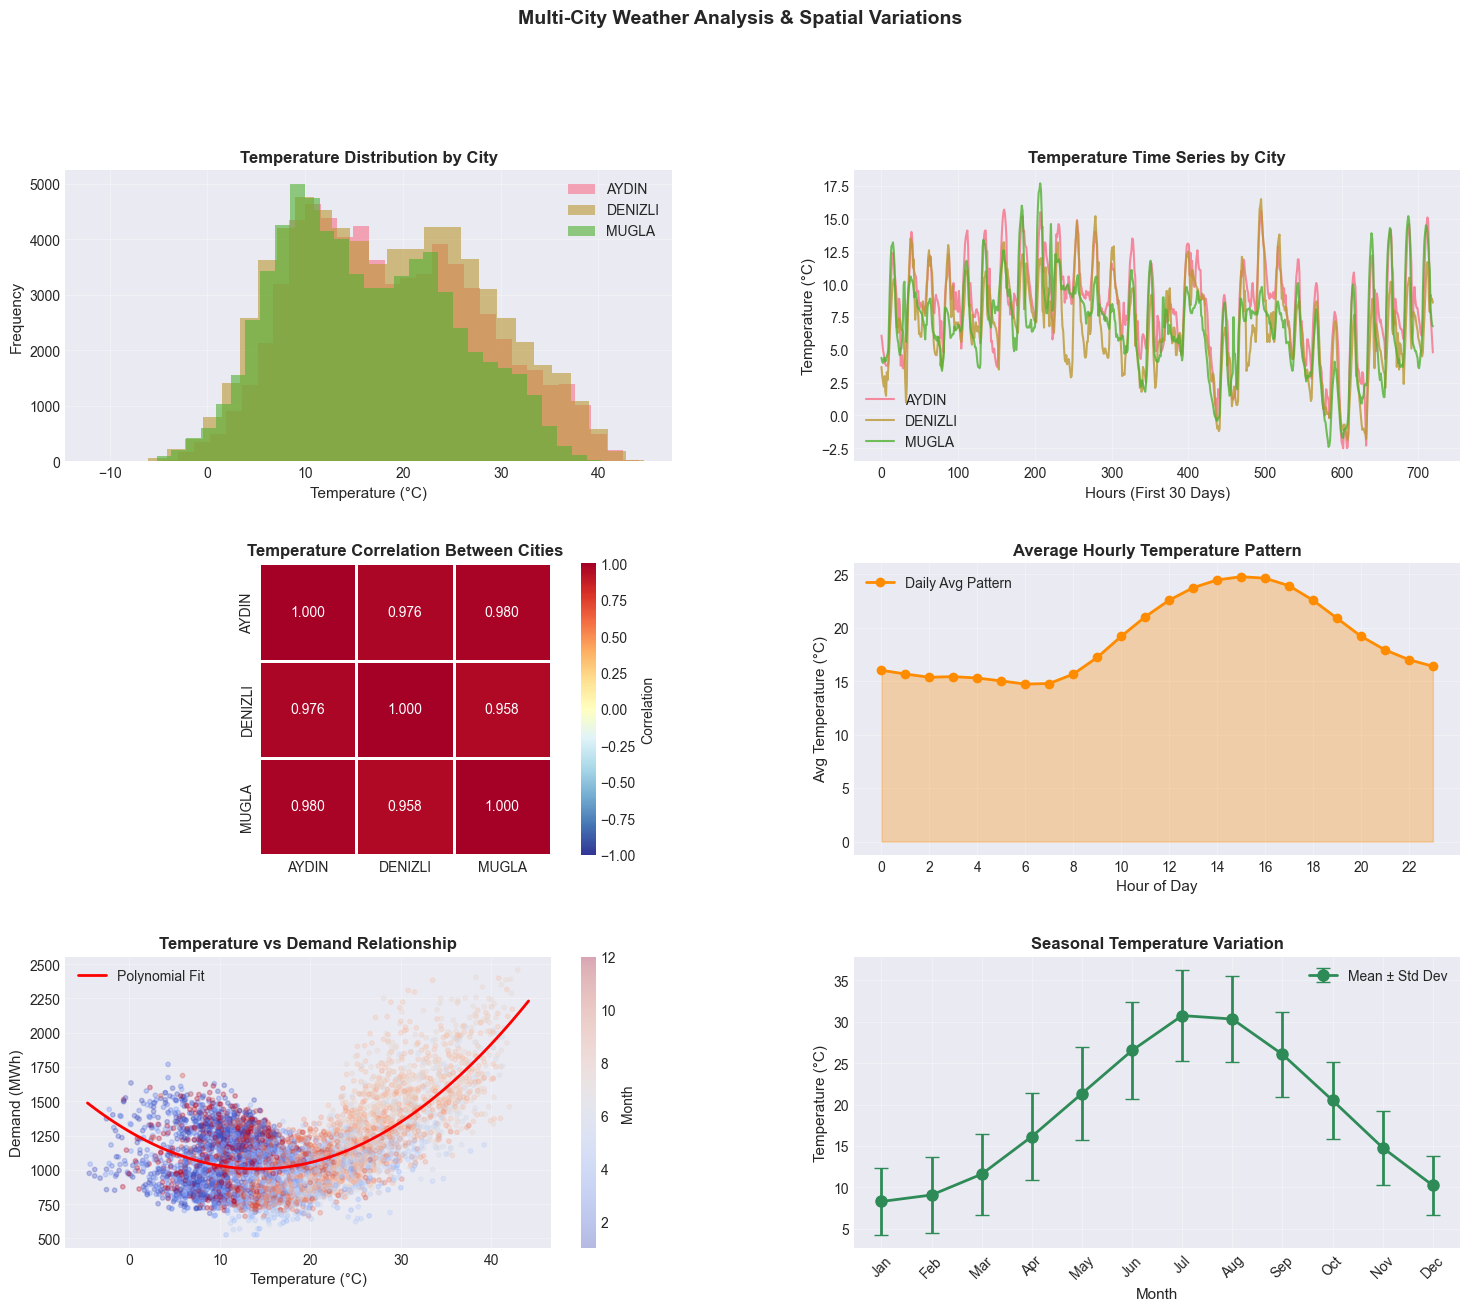

✓ Figure saved: c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\electricity_forecasting\data\output\figures\exploration\09_multi_city_weather.png


In [83]:
# ============================================================================
# SECTION 22B: VISUALIZATIONS - MULTI-CITY WEATHER ANALYSIS
# ============================================================================

print("\n[22B] Generating Multi-City Weather Visualizations...")

# Check if analysis section ran first
if 'city_temps' not in globals() or len(city_temps) == 0:
    print("⚠ Error: 'city_temps' not found.")
    print("Ensure Section 22 (Multi-City Weather Analysis) has been executed first")
else:
    try:
        fig = plt.figure(figsize=(18, 14))
        gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

        # Get correct temperature column name
        temp_col = 'temperature_2m' if 'temperature_2m' in base_df.columns else 'temperature'
        
        # 1. Temperature distributions by city
        ax1 = fig.add_subplot(gs[0, 0])
        has_data = False
        for city in CITIES:
            if city in dfs and temp_col in dfs[city].columns:
                ax1.hist(dfs[city][temp_col].dropna(), bins=30, alpha=0.6, label=city.upper())
                has_data = True
        ax1.set_xlabel('Temperature (°C)', fontsize=11)
        ax1.set_ylabel('Frequency', fontsize=11)
        ax1.set_title('Temperature Distribution by City', fontsize=12, fontweight='bold')
        if has_data:
            ax1.legend()
        ax1.grid(alpha=0.3)

        # 2. Temperature time series (first 30 days)
        ax2 = fig.add_subplot(gs[0, 1])
        plot_days = min(30*24, len(base_df))  # First 30 days
        has_data = False
        for city in CITIES:
            if city in dfs and temp_col in dfs[city].columns:
                ax2.plot(range(plot_days), dfs[city][temp_col].iloc[:plot_days].values, 
                         label=city.upper(), linewidth=1.5, alpha=0.8)
                has_data = True
        ax2.set_xlabel('Hours (First 30 Days)', fontsize=11)
        ax2.set_ylabel('Temperature (°C)', fontsize=11)
        ax2.set_title('Temperature Time Series by City', fontsize=12, fontweight='bold')
        if has_data:
            ax2.legend()
        ax2.grid(alpha=0.3)

        # 3. City intercorrelations
        ax3 = fig.add_subplot(gs[1, 0])
        if len(city_temps) >= 2:
            # Convert city_temps dict to DataFrame for correlation matrix
            city_temps_df = pd.DataFrame(city_temps)
            cities_upper = [c.upper() for c in city_temps_df.columns]
            city_temps_df.columns = cities_upper
            
            corr_matrix_cities = city_temps_df.corr()
            sns.heatmap(corr_matrix_cities, annot=True, fmt='.3f', cmap='RdYlBu_r', center=0,
                        cbar_kws={'label': 'Correlation'}, ax=ax3, vmin=-1, vmax=1,
                        square=True, linewidths=1)
            ax3.set_title('Temperature Correlation Between Cities', fontsize=12, fontweight='bold')
        else:
            ax3.text(0.5, 0.5, 'Need at least 2 cities\nfor correlation matrix',
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)

        # 4. Average hourly pattern
        ax4 = fig.add_subplot(gs[1, 1])
        if 'time' in base_df.columns:
            base_df['hour'] = pd.to_datetime(base_df['time']).dt.hour
            hourly_avg = base_df.groupby('hour')[temp_col].mean()
            ax4.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, 
                     markersize=6, color='darkorange', label='Daily Avg Pattern')
            ax4.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3, color='darkorange')
            ax4.set_xlabel('Hour of Day', fontsize=11)
            ax4.set_ylabel('Avg Temperature (°C)', fontsize=11)
            ax4.set_title('Average Hourly Temperature Pattern', fontsize=12, fontweight='bold')
            ax4.set_xticks(range(0, 24, 2))
            ax4.legend()
            ax4.grid(alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'Time column not available',
                    ha='center', va='center', transform=ax4.transAxes)

        # 5. Temperature vs demand scatter
        ax5 = fig.add_subplot(gs[2, 0])
        if temp_col in base_df.columns and 'demand' in base_df.columns:
            # Sample for performance
            sample_size = min(5000, len(base_df))
            sample_indices = np.random.choice(len(base_df), sample_size, replace=False)
            
            if 'time' in base_df.columns:
                months = pd.to_datetime(base_df['time']).dt.month.iloc[sample_indices]
            else:
                months = 'steelblue'
            
            scatter = ax5.scatter(base_df[temp_col].iloc[sample_indices], 
                                 base_df['demand'].iloc[sample_indices], 
                                 alpha=0.3, s=10, c=months, cmap='coolwarm')
            
            # Add polynomial fit if it exists
            if 'p' in globals():
                temp_range = np.linspace(base_df[temp_col].min(), base_df[temp_col].max(), 100)
                ax5.plot(temp_range, p(temp_range), 'r-', linewidth=2, 
                        label='Polynomial Fit')
                ax5.legend()
            
            ax5.set_xlabel('Temperature (°C)', fontsize=11)
            ax5.set_ylabel('Demand (MWh)', fontsize=11)
            ax5.set_title('Temperature vs Demand Relationship', fontsize=12, fontweight='bold')
            if isinstance(months, pd.Series):
                plt.colorbar(scatter, ax=ax5, label='Month')
            ax5.grid(alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'Temperature or demand\ndata not available',
                    ha='center', va='center', transform=ax5.transAxes)

        # 6. Seasonal patterns
        ax6 = fig.add_subplot(gs[2, 1])
        if 'time' in base_df.columns and temp_col in base_df.columns:
            base_df['month'] = pd.to_datetime(base_df['time']).dt.month
            seasonal_temp = base_df.groupby('month')[temp_col].agg(['mean', 'std'])
            months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            ax6.errorbar(range(1, 13), seasonal_temp['mean'], yerr=seasonal_temp['std'],
                        marker='o', capsize=5, linewidth=2, markersize=8, color='seagreen',
                        label='Mean ± Std Dev')
            ax6.set_xticks(range(1, 13))
            ax6.set_xticklabels(months, rotation=45)
            ax6.set_xlabel('Month', fontsize=11)
            ax6.set_ylabel('Temperature (°C)', fontsize=11)
            ax6.set_title('Seasonal Temperature Variation', fontsize=12, fontweight='bold')
            ax6.legend()
            ax6.grid(alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'Time or temperature\ndata not available',
                    ha='center', va='center', transform=ax6.transAxes)

        fig.suptitle('Multi-City Weather Analysis & Spatial Variations', 
                    fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(FIGURES_DIR / '09_multi_city_weather.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✓ Figure saved: {FIGURES_DIR / '09_multi_city_weather.png'}")
    
    except Exception as e:
        print(f"⚠ Error: {e}")
        import traceback
        traceback.print_exc()
        print("Ensure Section 22 (Multi-City Weather Analysis) has been executed first")

In [84]:
# ============================================================================
# SECTION 23: COMPREHENSIVE SUMMARY & FINAL RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("SECTION 23: COMPREHENSIVE SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n[23.1] Dataset Overview")
print("-"*80)
print(f"Total observations: {len(base_df):,} hourly records")
print(f"Time span: {(base_df['time'].max() - base_df['time'].min()).days} days")
print(f"Demand range: {base_df['demand'].min():.0f} - {base_df['demand'].max():.0f} MWh")
print(f"Cities covered: {', '.join(CITIES)}")

# Count available feature groups
feature_groups = {
    'Weather Features': [col for col in ['relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
                                         'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
                                         'precipitation', 'snowfall', 'cloud_cover', 'pressure_msl'] 
                        if col in base_df.columns],
    'Solar & Radiation': [col for col in ['shortwave_radiation', 'diffuse_radiation', 'sunshine_duration',
                                          'solar_radiation_w_m2', 'solar_heat_gain_kw_m2', 'solar_heat_gain'] 
                         if col in base_df.columns],
    'Degree Days & Indices': [col for col in ['heating_degree_hours_seasonal', 'cooling_degree_hours_seasonal',
                                              'heating_demand_index_seasonal', 'cooling_demand_index_seasonal'] 
                             if col in base_df.columns],
    'Temperature Derivatives': [col for col in ['temperature_lag_1h', 'temperature_lag_24h', 'temperature_ma_24h',
                                                'heat_index', 'wind_chill'] 
                               if col in base_df.columns],
    'Time Features': [col for col in ['hour', 'day_of_week', 'day_of_year', 'is_weekend', 'is_business_hour',
                                      'day_phase', 'is_morning_peak', 'is_evening_peak'] 
                     if col in base_df.columns],
    'Holiday/Events': [col for col in base_df.columns if col.startswith('is_') and 'holiday' in col.lower() or 'event' in col.lower() or 'ramadan' in col.lower()],
    'Regional Features': [col for col in ['region', 'climate_zone', 'population', 'is_coastal', 'distance_to_coast_km'] 
                         if col in base_df.columns],
}

print("\n[23.2] Feature Coverage by Category")
print("-"*80)
total_features = 0
for category, cols in feature_groups.items():
    print(f"{category:<30s}: {len(cols):>3d} features")
    total_features += len(cols)
print("-"*80)
print(f"{'TOTAL':<30s}: {total_features:>3d} features")

print("\n[23.3] Data Quality Assessment")
print("-"*80)
missing_pct = (base_df.isnull().sum() / len(base_df) * 100)
high_missing = missing_pct[missing_pct > 10]
if len(high_missing) > 0:
    print("Columns with >10% missing data:")
    for col, pct in high_missing.items():
        print(f"  {col}: {pct:.1f}%")
else:
    print("✓ No columns with >10% missing data")

print("\n[23.4] Most Predictive Features (Demand Correlation)")
print("-"*80)
# Compute all correlations
all_correlations = {}
for col in base_df.select_dtypes(include=[np.number]).columns:
    if col != 'demand':
        corr = base_df[col].corr(base_df['demand'])
        if not np.isnan(corr):
            all_correlations[col] = corr

sorted_corrs = sorted(all_correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(f"{'Feature':<40s} {'Correlation':>15s}")
print("-"*55)
for col, corr in sorted_corrs[:15]:
    print(f"{col:<40s} {corr:>15.4f}")

print("\n[23.5] Feature Engineering Recommendations (Priority Order)")
print("-"*80)
print("""
TIER 1 - ESSENTIAL (High predictive power):
  ✓ Hour-of-day (cyclic encoding: sin/cos transformation)
  ✓ Day-of-week (categorical)
  ✓ Temperature features (linear + polynomial + interactions)
  ✓ Holiday/event flags (binary + duration encoding)
  ✓ Lagged demand (AR-1, AR-24, AR-168)

TIER 2 - HIGH IMPACT:
  ✓ Humidity + temperature interaction
  ✓ Wind speed + direction (binned)
  ✓ Cloud cover + solar radiation (afternoon cooling effect)
  ✓ Degree days (heating + cooling)
  ✓ Day-of-week × season (interaction)
  ✓ Month/seasonal indicators (cyclic encoding)

TIER 3 - MODERATE IMPACT:
  ✓ Pressure (barometric effects)
  ✓ Precipitation (sudden demand changes)
  ✓ Industrial/tourism season flags
  ✓ Population demographics
  ✓ Distance to coast (climate moderating effect)

TIER 4 - CONTEXTUAL:
  ✓ Holiday proximity (days to/since)
  ✓ Ramadan phase indicators (sahur, iftar times)
  ✓ Moving averages of weather (12h, 24h)
  ✓ Extreme weather flags (heat waves, cold snaps)
""")

print("\n[23.6] Modeling Strategy Recommendations")
print("-"*80)
print("""
BASELINE FEATURES:
  1. Hour + month cyclic encoding
  2. Temperature polynomial (degree 2-3)
  3. Holiday/event binary indicators
  4. AR-1 and AR-24 lagged demand

ENSEMBLE APPROACH:
  - XGBoost/LightGBM for non-linear temperature effects
  - Linear regression for strong seasonal patterns
  - LSTM/RNN for temporal dependencies
  - Prophet for trend + seasonality decomposition

VALIDATION STRATEGY:
  - Time-series cross-validation (no future leak)
  - Stratified by: weekday/weekend, season, event/normal
  - Separate error analysis for extreme events
  - Residual autocorrelation check

DATA PREPROCESSING:
  - Handle missing values (forward-fill weather, interpolate)
  - Outlier detection (3-sigma for demand)
  - Scaling normalization (StandardScaler by season)
  - Cyclic feature encoding for hour/month/day
""")

print("\n" + "="*80)
print("✓ COMPREHENSIVE DATA EXPLORATION COMPLETE")
print("="*80)
print(f"\nNew sections added:")
print(f"  • Section 19: Autocorrelation & Stationarity Analysis (ACF/PACF/ADF/KPSS)")
print(f"  • Section 20: Time Series Decomposition (Trend/Seasonal/Residual)")
print(f"  • Section 21: Comprehensive Feature Correlation Analysis")
print(f"  • Section 22: Multi-City Weather Analysis & Spatial Variation")
print(f"  • Section 23: Final Summary & Recommendations")
print(f"\nTotal sections analyzed: 23")
print(f"Features examined: {total_features}")
print(f"Advanced statistical tests: ADF, KPSS, ACF, PACF, Decomposition")
print(f"Ready for model development")



SECTION 23: COMPREHENSIVE SUMMARY & RECOMMENDATIONS

[23.1] Dataset Overview
--------------------------------------------------------------------------------
Total observations: 67,200 hourly records
Time span: 2799 days
Demand range: 449 - 2517 MWh
Cities covered: aydin, denizli, mugla

[23.2] Feature Coverage by Category
--------------------------------------------------------------------------------
Weather Features              :  10 features
Solar & Radiation             :   6 features
Degree Days & Indices         :   4 features
Temperature Derivatives       :   5 features
Time Features                 :   8 features
Holiday/Events                :   4 features
Regional Features             :   5 features
--------------------------------------------------------------------------------
TOTAL                         :  42 features

[23.3] Data Quality Assessment
--------------------------------------------------------------------------------
Columns with >10% missing data:
  holid

c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\begum.orhan\OneDrive - MRC\Masaüstü\EDM\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
